In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plot
import seaborn as sns
from collections import Counter
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from numba import jit
from scipy import spatial
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

adata = ad.read_csv("Data/ss_counts.csv").T
sample_info = pd.read_csv("Data/sample_info_NEW.tsv", sep = '\t') #sample info about library depth, etc. 
metadata = pd.read_csv("Data/metadata_old.csv")  #metadata file
#adata.obs_names_make_unique()
adata.var_names_make_unique()
adata.raw = adata
adata.obs['Run lane'] = list(metadata['Run.lane'])
adata.obs['Sample'] = list(metadata['Sample'])
adata.obs['Cell#'] = list(metadata['Cell.'])
adata.obs['Stage'] = list(metadata['Stage'])
bdata = ad.read_csv("Data/ss2_counts.csv").T
sample_info2 = pd.read_csv("Data/sample_info_rec.tsv", sep = '\t') #sample info about library depth, etc. 
metadata2 = pd.read_csv("Data/metadata_new.csv")  #metadata file
bdata.var_names_make_unique()
bdata.obs['Run lane'] = list(metadata2['Run.lane'])
bdata.obs['Sample'] = list(metadata2['Sample'])
bdata.obs['Cell#'] = list(metadata2['Cell.'])
bdata.obs['Stage'] = list(metadata2['Stage'])
bdata.obs['Plate'] = list(metadata2['Plate'])
qc_metrics = sc.pp.calculate_qc_metrics(adata)
sample_info = pd.read_csv("Data/sample_info_NEW.tsv", sep = '\t') #sample info about library depth, etc. 
sample_info['Unnamed: 0'] = sample_info['Unnamed: 0'].str[:-11]
sample_info['Unnamed: 0'] = 'X' + sample_info['Unnamed: 0'].astype(str)  
sample_info['Unnamed: 0'] = sample_info['Unnamed: 0'].str.replace('#','.')
sample_info = sample_info[sample_info['Unnamed: 0'].isin(list(qc_metrics[0].index.values))]
batch_group = sample_info['Unnamed: 0'].str[:8] # extracting batch names for each cell
adata.obs['Plate'] = list(batch_group)
qc_metrics = sc.pp.calculate_qc_metrics(bdata)
sample_info2 = pd.read_csv("Data/sample_info_rec.tsv", sep = '\t') #sample info about library depth, etc. 
sample_info2['Unnamed: 0'] = sample_info2['Unnamed: 0'].str.slice(0,12)
sample_info2['Unnamed: 0'] = sample_info2['Unnamed: 0'].str.replace('-','.')
sample_info2 = sample_info2[sample_info2['Unnamed: 0'].isin(list(qc_metrics[0].index.values))]
adata = adata.concatenate(bdata)
sample_info = pd.concat([sample_info, sample_info2])
#adata = adata[adata.obs['Stage']=='CS6']

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/merge.py:918: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


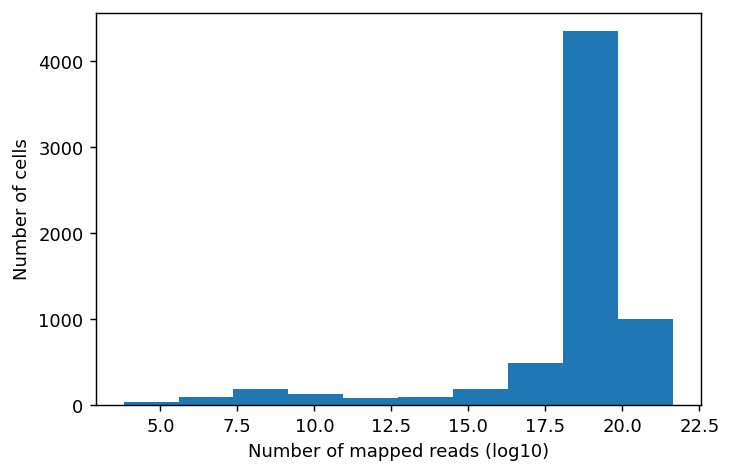

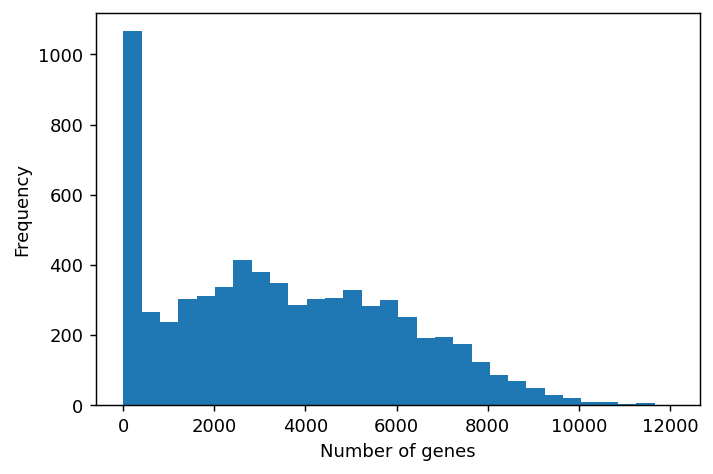

In [3]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

qc_metrics = sc.pp.calculate_qc_metrics(adata)
#sample_info['Unnamed: 0'] = sample_info['Unnamed: 0']+'-1'
#sample_info=sample_info[sample_info['Unnamed: 0'].isin(list(adata.obs_names))]
reads_cell = sample_info['num_processed']
sc.set_figure_params(scanpy = False, dpi = 65, transparent=False)
np.log2(reads_cell).plot.hist();
plot.xlabel('Number of mapped reads (log10)')
plot.ylabel('Number of cells')
plot.show();
counts_cell = qc_metrics[0]['n_genes_by_counts']
plot.xlabel('Number of genes')
plot.ylabel('Number of cells')

counts_cell.plot.hist(bins = 30)
plot.show()


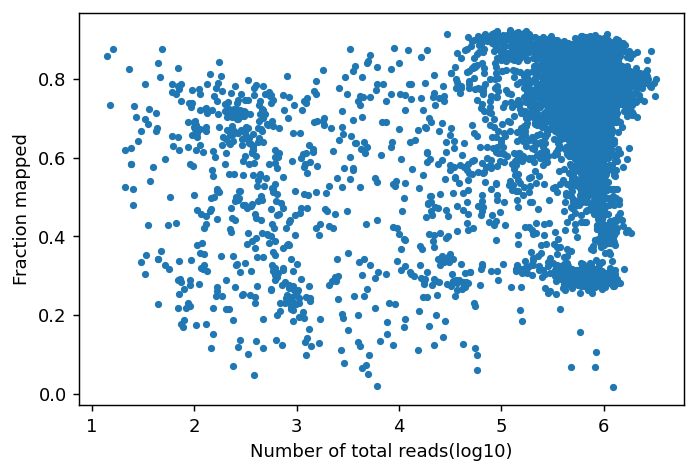

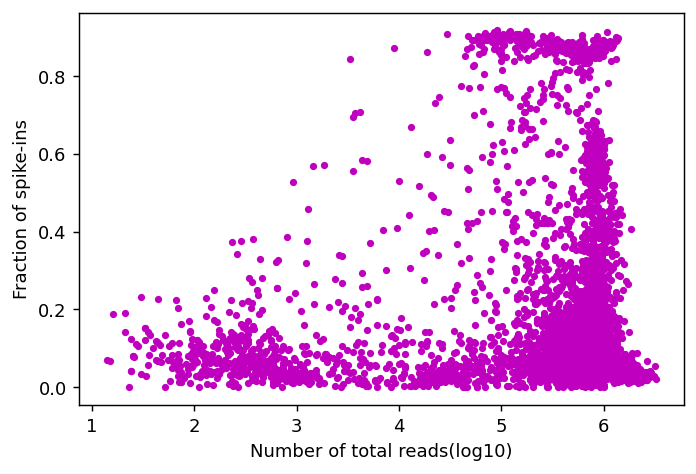

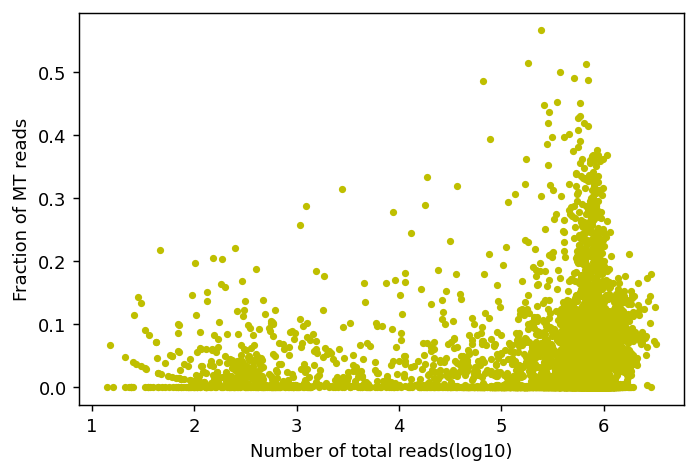

... storing 'Sample' as categorical
... storing 'Cell#' as categorical
... storing 'Stage' as categorical
... storing 'Plate' as categorical


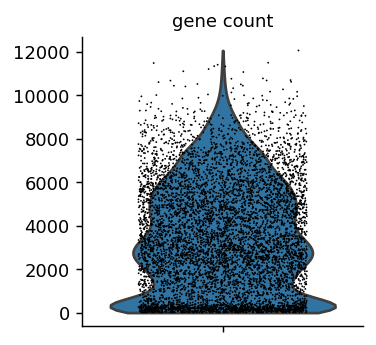

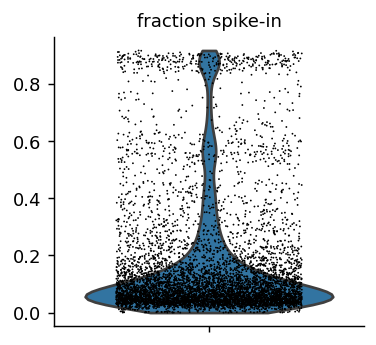

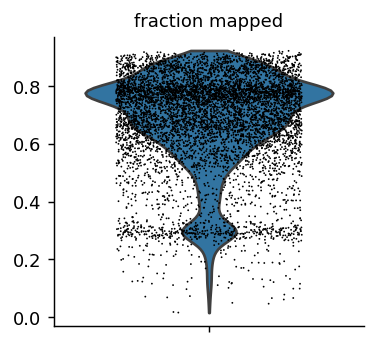

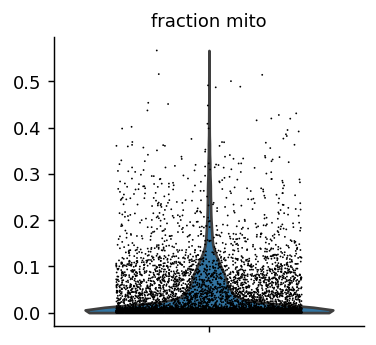

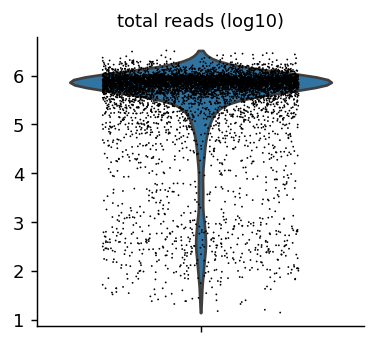

In [4]:
tot_counts = list(qc_metrics[0]['total_counts'])
percent_mapped = np.divide(tot_counts, reads_cell)
plot.plot(list(np.log10(reads_cell)), percent_mapped,'.')
plot.xlabel('Number of total reads(log10)'), plot.ylabel('Fraction mapped')

plot.show()
plot.close()
#%%
ercc_counts = adata.var_names.str.startswith('ERCC-') #selecting spike-in counts

percent_ercc = np.sum(adata[:, ercc_counts].X, axis=1)/reads_cell #fraction spike-in calc.
plot.plot(np.log10(reads_cell), percent_ercc, 'm.')
plot.xlabel('Number of total reads(log10)'), plot.ylabel('Fraction of spike-ins')
plot.show(), plot.close()

mt_counts = adata.var_names.str.startswith('MT-') #selecting mitochondrial gene counts
percent_mt = np.sum(adata[:, mt_counts].X, axis=1)/reads_cell #fraction mito calc.
plot.plot(np.log10(reads_cell), percent_mt, 'y.')
plot.xlabel('Number of total reads(log10)'), plot.ylabel('Fraction of MT reads')
plot.show(), plot.close()

adata.obs['gene count'] = list(counts_cell)
adata.obs['fraction mapped'] = list(percent_mapped)
adata.obs['fraction mito'] = list(percent_mt)
adata.obs['fraction spike-in'] = list(percent_ercc)
adata.obs['total reads (log10)'] = list(np.log10(reads_cell))


pltbad_list = ['gene count', 'fraction spike-in','fraction mapped','fraction mito','total reads (log10)']
for l in pltbad_list: 
    sc.pl.violin(adata, l, jitter = 0.3,multi_panel = True)

#plot good cells
#filtering cells
good_data = adata[adata.obs['gene count'] > 2000, :] 
#good_data = good_data.copy()
good_data = good_data[good_data.obs['fraction mapped'] > 0.55, :]
good_data = good_data.copy()
good_data = good_data[good_data.obs['fraction mito'] < 0.02, :]
#good_data = good_data.copy()
good_data = good_data[good_data.obs['fraction spike-in'] < 0.2, :]
#good_data = good_data.copy()
#good_data.obs_names_make_unique()
good_data.var_names_make_unique()


In [ ]:
sc.pl.violin(good_data,groupby = 'Plate' ,
             keys= ['gene count', 'fraction spike-in', 'fraction mapped', 'fraction mito', 'total reads (log10)'], jitter = 0.3)
# selecting only bad cells
gd_df = good_data.to_df()
adata_df = adata.to_df()
bd_df = pd.concat([adata_df, gd_df]).loc[adata_df.index.symmetric_difference(gd_df.index)]
gd_df['cells'] = 'good cells'
bd_df['cells'] = 'bad cells'
frames = [gd_df, bd_df]
all_df = pd.concat(frames)
all_df.sort_index(inplace=True)
all_df = all_df.loc[list(adata.obs_names)]
cells = all_df['cells']
adata.obs['cells'] = list(cells)
bad_data= adata[adata.obs['cells']=='bad cells']
pltbad_list = ['gene count', 'fraction spike-in','fraction mapped','fraction mito','total reads (log10)']
sc.pl.violin(bad_data, ['gene count', 'fraction spike-in', 'fraction mapped', 'fraction mito', 'total reads (log10)'], jitter = 0.3,group_by = 'Plate', multi_panel=True)
sc.tl.pca(adata)
sc.pl.pca(adata, color = 'cells')
gd_df = good_data.to_df()
gast_dat = good_data[good_data.obs['Stage']=='CS6']
gast_df = gast_dat.to_df()

gast_dat


   

In [ ]:
#cls = list(adata.obs['cells'])
adata = ad.read_csv("Data/ss2_counts.csv").T
sample_info2 = pd.read_csv("Data/sample_info_rec.tsv", sep = '\t') #sample info about library depth, etc. 
metadata2 = pd.read_csv("Data/metadata_new.csv")  #metadata file
#bdata.var_names_make_unique()
adata.obs['Run lane'] = list(metadata2['Run.lane'])
adata=adata[adata.obs['Run lane'].isin(list(good_data.obs['Run lane']))]
df = adata.to_df()
gdata = df.groupby(df.columns, axis=1).sum()
gdata=ad.AnnData(gdata)

gdata.obs=adata.obs
#gast_dat = gast_dat[gast_dat.obs['Sample']!='Exclude']

gdata=gdata[gdata.obs['Run lane'].isin(list(gast_dat.obs['Run lane']))]
gast_df = gdata.to_df()

In [17]:
%get gast_df 
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(scran, quietly = TRUE, warn.conflicts = FALSE)
data<-gast_df #get good cells from python kernel
#data<-select(data, -cells)
data<- data[, -grep("ERCC", colnames(data))]
sce<-SingleCellExperiment(assays = list(counts = t(as.matrix(data))))
clusters <- quickCluster(sce)
sce<-computeSumFactors(sce, cluster=clusters)
sf<-sizeFactors(sce)
#sce<-normalize(sce,return_log=FALSE)
#data<-data.frame(as.matrix(normcounts(sce)))

#write.csv(data, file = 'norm_true_data.csv')




Warning message:
“package ‘dplyr’ was built under R version 3.5.1”Warning message:
“package ‘scran’ was built under R version 3.5.1”
Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapp

In [24]:
#gdata = gdata[gdata.obs['Run lane'].isin(list(high_var2.obs['Run lane']))]
%get sf --from R
gast_df = pd.read_csv('human_gastrula.csv')
#gast_df['cluster']=list(high_var2.obs['clust_id'])
#gast_df['origin']= list(high_var2.obs['Sample_mod'])
gast_df['size_factor'] = sf
#gast_df.to_csv('human_gastrula.csv')

Unnamed: 0  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A2ML1-AS2  ...  ZYG11AP1  ZYG11B    ZYX  ZYXP1  ZZEF1  hsa-mir-1253                            cluster    origin  size_factor
0     SS.sc7785290   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0  157.0    0.0    0.0           0.0  Hemogenic Endothelial Progenitors  Yolk Sac     0.973131
1     SS.sc7786612   2.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                           Endoderm   Rostral     0.677075
2     SS.sc7786605   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     5.0    0.0    0.0    0.0           0.0                  Advanced Mesoderm   Rostral     1.136933
3     SS.sc7785737   2.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0   163.0    0.0    0.0    0.0           0.0                   Primitive Streak    Caudal     0.751143
4     SS.sc7785398   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                        YS Mesoderm  Yolk Sac     0.817608
...            ...   ...       ...   ...  ...      ...    ...        ...        ...  ...       ...     ...    ...    ...    ...           ...                                ...       ...          ...
1190  SS.sc7785965   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0    7.0    0.0    0.0           0.0                           Epiblast    Caudal     0.554371
1191  SS.sc7788259   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                   Primitive Streak    Caudal     0.849631
1192  SS.sc7786123   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                   Primitive Streak    Caudal     0.804777
1193  SS.sc7786212   8.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     3.0    0.0    0.0    0.0           0.0                           Epiblast    Caudal     1.056203
1194  SS.sc7785932   0.0       0.0   0.0  0.0      0.0    0.0        0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                   Nascent Mesoderm    Caudal     0.851783

[1195 rows x 57596 columns]

In [ ]:
import scanpy as sc
import leidenalg
sc.settings.verbosity = 4         
high_var2 = ad.read_csv('normf_data.csv').T    #load the normalized data
#log_data= sc.pp.log1p(high_var,copy = True)
#high_var2.raw=gast_dat
#log_data.raw=gast_dat
sc.pp.log1p(high_var2)
high_var2.var_names_make_unique()#ss

#sc.pp.highly_variable_genes(high_var2,max_mean=10,n_top_genes=4000) 
sc.pp.highly_variable_genes(high_var2,max_mean=10) 

high_var2=high_var2[:,high_var2.var['highly_variable']] 
import scipy
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));


high_var2 = sc.tl.pca(high_var2, svd_solver = 'arpack', n_comps = 50,copy=True)
sc.pp.neighbors(high_var2, n_pcs=30, n_neighbors=50, method = 'umap',metric = spearman_dist)
high_var2.obs = gast_dat.obs

high_var2 = high_var2[high_var2.obs['Sample']!='Exclude']

sc.tl.leiden(high_var2,resolution = 0.75, n_iterations=-1)

sc.tl.umap(high_var2)
sc.pl.umap(high_var2, color = 'leiden',palette = ["#a1def0", "#2c647e", "#39eec0", "black", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"])
sc.pl.umap(high_var2, color = 'Sample',palette = ["#a1def0", "#2c647e", "#39eec0", "yellow", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"])
#ori = pd.read_csv('ori_gast_umap.csv')
#high_var2.obsm['X_umap']=np.array(ori.iloc[:,2:4])

computing Diffusion Maps using n_comps=15(=n_dcs)
        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9848057  0.97841114 0.9729149  0.96336365 0.958468
     0.9503873  0.94321984 0.93646663 0.91487    0.91291255 0.89540684
     0.8744806  0.87039644 0.8688513 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


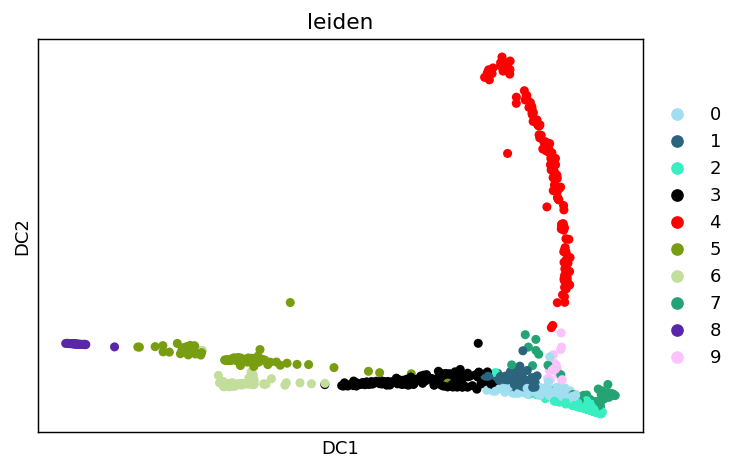

In [11]:

sc.tl.diffmap(high_var2)
sc.pl.diffmap(high_var2,color='leiden')

#high_var2.raw = ad.read_csv('script_heart+gastr/norm_true_data.csv')  
#sc.pl.umap(high_var2,color='leiden')
#sc.pl.umap(high_var2,color='TBXT')

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


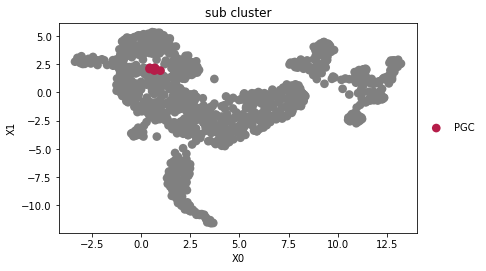

In [36]:
#ect = ad.read_csv('script_heart+gastr/norm_true_data.csv')  
#ect.obs=pd.read_csv('ori_gast_umap.csv')
#um = pd.read_csv('ori_gast_umap.csv').iloc[:,2:4]
#ect.obsm['X_umap']=um
ax = sc.pl.scatter(ect,x='X0',y='X1', size=300,frameon=False,show=False)
sc.pl.scatter(ect[ect.obs['sub_cluster']=='PGC'],x='X0',y='X1', size=300,color='sub_cluster',palette=["#b51d49"],frameon=False,show=True,ax=ax,save='pgc_umap')
#sc.pl.scatter(ect[ect.obs['sub_cluster']=='PGC'],color='sub_cluster')

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'cluster_id' as categorical
... storing 'sub_cluster' as categorical


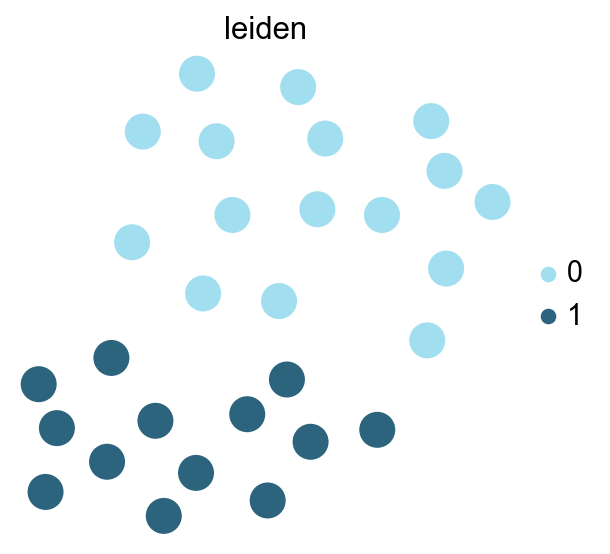

In [2]:
ect = ad.read_csv('script_heart+gastr/norm_true_data.csv')  
ect.obs=pd.read_csv('ori_gast_umap.csv')
ect = ect[ect.obs['cluster_id']=='Ectoderm']
sc.pp.highly_variable_genes(ect,max_mean=10,n_top_genes=500)  #calculate highly variable genes
ect2=ect[:,ect.var['highly_variable']]  #select only highly variable genes
import scipy
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));


ect2 = sc.tl.pca(ect2, svd_solver = 'arpack', n_comps = 20,copy=True)
sc.pp.neighbors(ect2, n_pcs=5, n_neighbors=10, method = 'umap',metric = spearman_dist)
sc.tl.leiden(ect2,resolution = 0.5, n_iterations=-1)
sc.tl.umap(ect2)

import scvelo as scv
sc.settings.set_figure_params('scanpy',vector_friendly=False,format='pdf')

sc.pl.umap(ect2, color = 'leiden',size = 1050,frameon=False,
palette = ["#a1def0", "#2c647e", "#39eec0", "black", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363"
, "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"],save='ecto_sub_umap.pdf')


In [8]:
#ect2.raw=ect
#sc.pl.umap(ect2,color='VTCN1',size = 1050,cmap = 'winter',save='VTCN1_exp.pdf')
nne = ect2.obs[['cell_name','leiden']]
nne.columns=['cell_name','sub-cluster']
nne.to_csv('nne_subclusters.csv',index=False)

In [219]:
sc.tl.rank_genes_groups(ect2, groupby='leiden', method= 'wilcoxon', corr_method='benjamini-hochberg'
                     ,n_genes=50)
#sc.pl.rank_genes_groups_matrixplot(ect2,groupby='leiden',cmap='mako',n_genes=8,save='ecto_heatmap.pdf')
pd.DataFrame(ect2.uns['rank_genes_groups']['names']).to_excel('ecto_list.xlsx',sheet_name='Sheet_name1')

ranking genes
    consider 'leiden' groups:
    with sizes: [16 13]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [25]:
%get hvd
%get spca
library(Seurat)
xenopus.combined<-t(hvd)

xenopus.combined <- CreateSeuratObject(counts = xenopus.combined, project = "embryo2")
xenopus.combined<-FindVariableFeatures(xenopus.combined,nfeatures=11601)
colnames(spca)<- paste0("PC_", 1:50)
rownames(spca)<-rownames(xenopus.combined@meta.data)
xenopus.combined[["pca"]] <- CreateDimReducObject(embeddings = as.matrix(spca), key = "PC_", assay = DefaultAssay(xenopus.combined))

#xenopus.combined<-ScaleData(xenopus.combined)
spearman.dist <- function(x, y) return(sqrt(0.5*(1-cor(x,y,method='spearman'))))
input.data <- GetAssayData(xenopus.combined,slot='data')
cell.spearman.dist <- CustomDistance(input.data, spearman.dist)

#xenopus.combined<-RunPCA(xenopus.combined, npcs = 50, verbose = FALSE)
xenopus.combined[["adt_snn"]] <- FindNeighbors(cell.spearman.dist,reduction = "pca", dims = 1:30,k.param=50)$snn


#xenopus.combined <- FindNeighbors(xenopus.combined, reduction = "pca", dims = 1:30,k.param=50,)



Attaching SeuratObject

Warning message:
“The following arguments are not used: reduction, dims”
Warning message:
“The following arguments are not used: reduction, dims”
Building SNN based on a provided distance matrix

Computing SNN

Warning message:
“Adding a Graph without an assay associated with it”


In [61]:
#%get distc
xenopus.combined <- FindClusters(xenopus.combined, resolution =2.1,graph.name = "adt_snn",algorithm=4 ,verbose=TRUE)

sleiden<-xenopus.combined@meta.data$seurat_clusters
sleiden<-as.vector(sleiden)
#xenopus.combined@reductions$pca
#head(distc)

1 singletons identified. 10 final clusters.

Warning message:
“Adding a command log without an assay associated with it”


In [ ]:
%get sleiden --from R
high_var2.obs['sleiden']=sleiden
sc.pl.umap(high_var2,color='sleiden')

In [54]:
from sklearn.metrics import silhouette_score
from pyitlib import discrete_random_variable as drv
#drv.information_variation(list(ld1),list(ld3k))
#silhouette_score(high_var2.X,label s=list(high_var2.obs['leiden']),metric=spearman_dist)
#ld3k= high_var2.obs['sleiden']
#ld1= high_var2.obs['leiden']


In [55]:
from sklearn.metrics import normalized_mutual_info_score
sl = pd.read_csv('meta_sleiden.csv')
normalized_mutual_info_score(sleiden,sl['leiden'],average_method='min')

0.7507187653730235

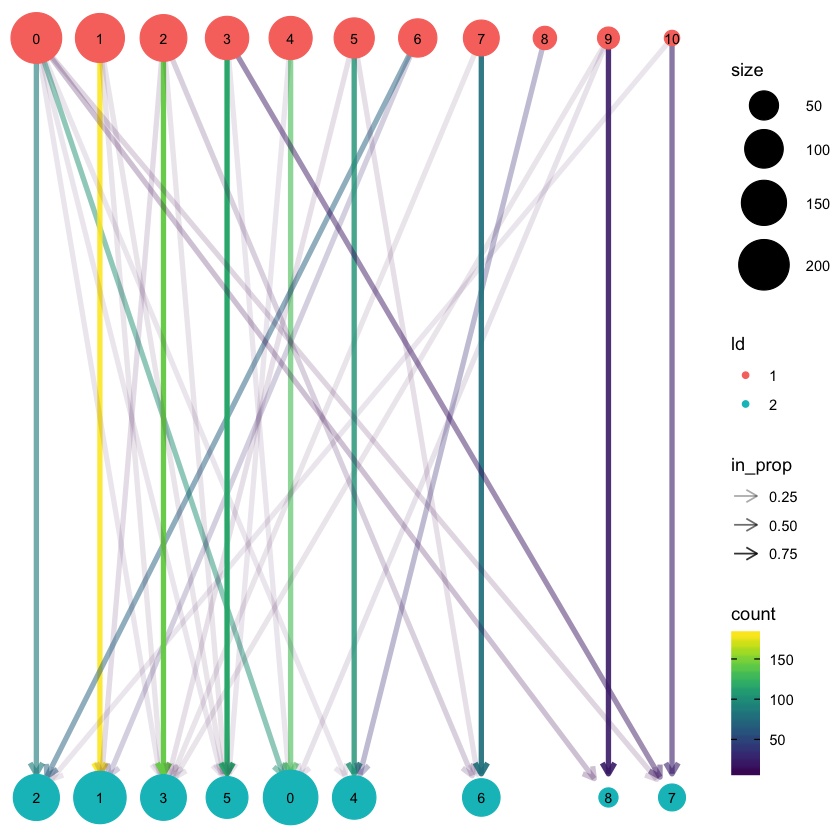

In [464]:
%get ld3k
%get ld1

library(clustree)
Sys.setenv(lang='en')
clt<-cbind(ld1,ld3k)
colnames(clt)<-c('ld1','ld2')
clt<-as.data.frame(clt)

clustree(clt,prefix='ld',prop_filter=0)

... storing 'Sample_mod' as categorical


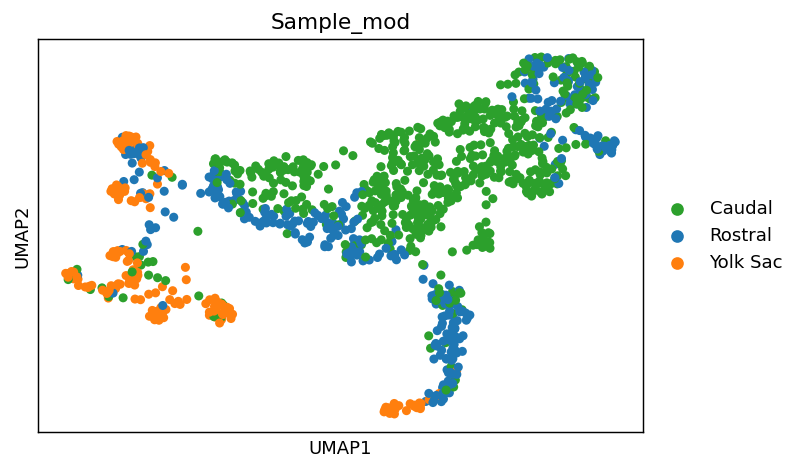

['#2ca02c', '#1f77b4', '#ff7f0e']

In [12]:
import re
def trunc_at(s, d, n):
    return d.join(s.split(d, n)[:n])

sampless = []

samples = list(high_var2.obs['Sample'])

for s in samples:
    
    if (s == 'Group1'):
        s = 'Rostral'
    if (s == 'Group2'):
        s = 'Caudal'
    if (s == 'Group2 '):
        s = 'Caudal'
    if (s == 'Group3'):
        s = 'Yolk Sac'
    if (s =='Exclude'):
        s ==''
    sampless.append(s)
high_var2.obs['Sample_mod'] = sampless

sc.pl.umap(high_var2,color = 'Sample_mod',palette=['#2ca02c','#1f77b4',  '#ff7f0e'])
spat = list(high_var2.obs['Sample_mod'])
high_var2.uns['Sample_mod_colors']

In [23]:
spca = pd.DataFrame(high_var2.obsm["X_pca"])
hvd = high_var2.to_df()

#spca.index=list(high_var2.obs.index)
#sc.tl.diffmap(high_var2)
#sc.pl.diffmap(high_var2, color='leiden')

... storing 'clust_id' as categorical


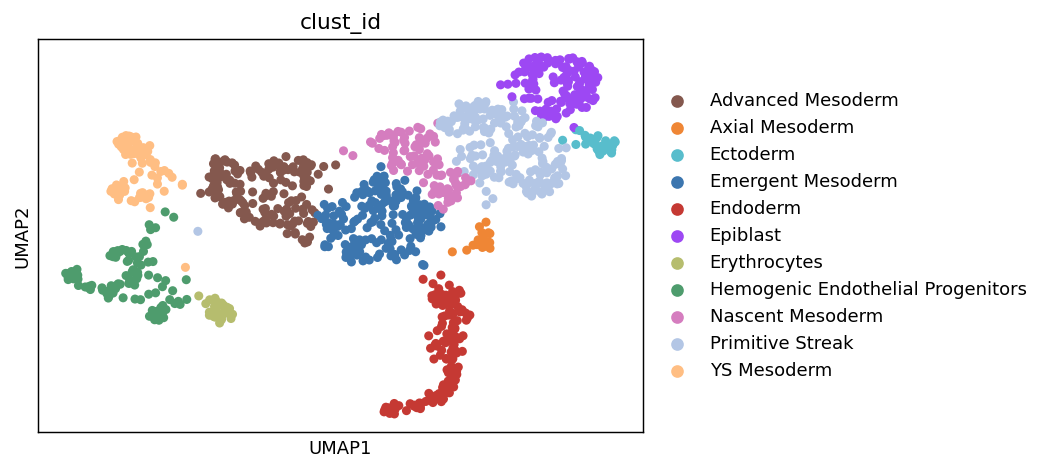

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [11]:
#4E9C6D,Mature Mesoderm
#EF8635,Endoderm
#58BDCC,Ectoderm
#9D48F3,Hemogenic Endothelial Progenitors
#C53933,Erythrocytes
#3C76AF,Epiblast
#84584E,Axial Mesoderm
#B6BD6E,Immature Mesoderm
#D57DBF,Nascent Mesoderm
#B3C6E5,Primitive Streak
#FFBE83,YS Mesoderm

cl_id = []
for i in list(high_var2.obs['leiden']):
    if i == '0':
        cl_id.append('Primitive Streak')
    if i == '1':
        cl_id.append('Emergent Mesoderm')
    if i == '2':
        cl_id.append('Advanced Mesoderm')
    if i == '3':
        cl_id.append('Endoderm')
    if i == '4':
        cl_id.append('Epiblast')
    if i == '5':
        cl_id.append('Hemogenic Endothelial Progenitors')
    if i == '6':
        cl_id.append('Nascent Mesoderm')
    if i == '7':
        cl_id.append('YS Mesoderm')
    if i == '8':
        cl_id.append('Erythrocytes')
    if i == '9':
        cl_id.append('Ectoderm')
    if i == '10':
        cl_id.append('Axial Mesoderm')
        
high_var2.obs['clust_id']=cl_id
sc.pl.umap(high_var2,color='clust_id',palette=['#84584E','#EF8635','#58BDCC','#3C76AF','#C53933','#9D48F3',
'#B6BD6E','#4E9C6D','#D57DBF','#B3C6E5','#FFBE83'])
log_data2 = ad.read_csv('normf_data.csv').T    #load the normalized data
log_data2= sc.pp.log1p(log_data2,copy = True)

log_data2.obs = gast_dat.obs

log_data2 = log_data2[log_data2.obs['Sample']!='Exclude']

high_var2.raw=log_data2
log_data2.obs=high_var2.obs


computing Diffusion Maps using n_comps=15(=n_dcs)
        initialized `.distances` `.connectivities` `.eigen_values` `.eigen_basis` `.distances_dpt`
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9815124  0.97587246 0.9685877  0.96112144 0.95462054
     0.9429724  0.9401714  0.9330151  0.90760034 0.89788526 0.8935756
     0.8906383  0.8682357  0.8653591 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


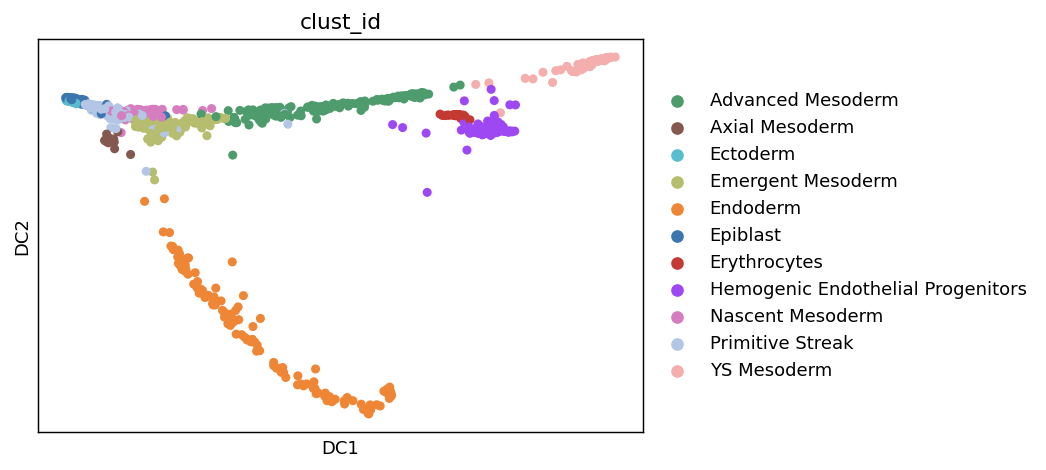

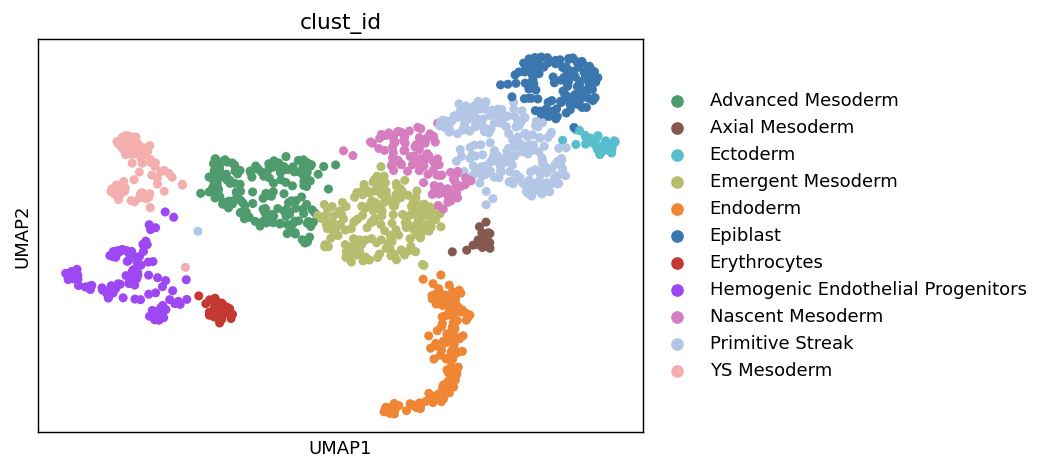

In [14]:
sc.tl.diffmap(high_var2)
sc.pl.diffmap(high_var2,color='clust_id',palette=['#4E9C6D','#84584E','#58BDCC','#B6BD6E','#EF8635','#3C76AF',
'#C53933','#9D48F3','#D57DBF','#B3C6E5','#f4aeae'])
sc.pl.umap(high_var2,color='clust_id',palette=['#4E9C6D','#84584E','#58BDCC','#B6BD6E','#EF8635','#3C76AF',
'#C53933','#9D48F3','#D57DBF','#B3C6E5','#f4aeae'])
cm = high_var2.copy()

In [129]:
import matplotlib.pyplot as plot

#sc.set_figure_params(scanpy=False,vector_friendly=True,format='eps')
#sc.pl.umap(high_var2,color='cluster_id',palette=['#84584E', "#58bdcc",    "#EF8635","#3C76AF",  "#c53933","#9D48F3","#B6BD6E","#4E9C6D","#D57DBF","#B3C6E5",  "#FFBE83"],save='.pdf')

#sc.pl.umap(high_var2,color='BMP4',palette=['#2ca02c','#1f77b4', '#ff7f0e'], save='_spatial.pdf')
for_snn= high_var2.to_df()


In [355]:
'''spat = list(high_var2.obs['Sample_mod'])
clust_id = list(high_var2.obs['cluster_id'])
df=pd.DataFrame(dict(spat = spat, cid=clust_id))
df = df.groupby(['cid','spat']).size().groupby(level = 0).transform(lambda x: x/x.sum())*100
df.to_excel("spat_percent.xlsx", sheet_name='Sheet_name_1')  '''
#pd.DataFrame(high_var2.obsm['X_umap']).to_csv('gast_umap.csv')
'''log_data2 = ad.read_csv('norm_true_data.csv').T    #load the normalized data
log_data2= sc.pp.log1p(log_data2,copy = True)

log_data2.obs = gast_dat.obs

log_data2 = log_data2[log_data2.obs['Sample']!='Exclude']

high_var2.raw=log_data2
log_data2.to_df().to_csv('norm_true_data.csv')
'''
#high_var2.obsm['X_umap'][:,0]=high_var2.obsm['X_umap'][:,0]*-1
humap = pd.DataFrame(high_var2.obsm['X_umap'])
humap['cluster_id']=list(high_var2.obs['clust_id'])
humap.to_csv('gast_umap.csv',sep=',')

In [ ]:
%get clust_id
%get spat
location<-spat
library(ggplot2)
#value<-abs(rnorm(1195 , 0 , 21))
data <- data.frame(clust_id,spat,value=value*100)
data<-data[order(as.character(data$spat)),]
data$clust_id<-factor(data$clust_id, levels= c('Axial Mesoderm','Nascent Mesoderm','Primitive Streak',
                                              'Immature Mesoderm','Mature Mesoderm','Epiblast','Ectoderm',
                                              'Endoderm','YS Mesoderm','Hemogenic Endothelial Progenitors',
                                              'Erythrocytes'))
p<-ggplot() + geom_bar(data=data,aes(x=factor(clust_id), fill=factor(spat)),position="fill", color='black')+scale_fill_manual(values=c('#2ca02c','#1f77b4',  '#ff7f0e'))+theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_blank())+labs(fill = "Spatial location",x='Cell Type',y='% of cells')+ scale_y_continuous(labels = scales::percent_format())

ggsave('figures/Fig1e_percentages.pdf',plot=p)

In [ ]:
#sc.tl.diffmap(high_var2)
#sc.pl.diffmap(high_var2, color='cluster_id',components='1,2',save='Fig2a_DC1_2.pdf')

In [95]:
gast_dat = good_data[good_data.obs['Stage']=='CS6']
gast_dat = gast_dat[gast_dat.obs['Sample']!='Exclude']
gast_dat.obs=high_var2.obs

In [96]:
mm = gast_dat[gast_dat.obs['clust_id']=='Immature Mesoderm']
cl1 = mm.to_df()
ld = list(mm.obs['Sample_mod'])
pl = list(mm.obs['Plate'])

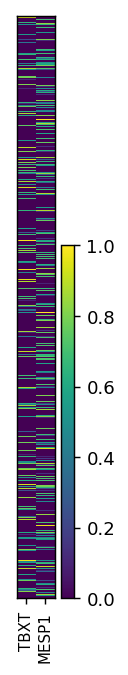

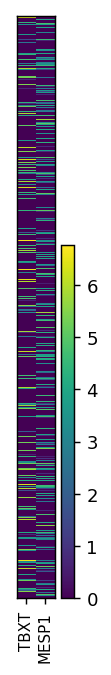

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0, 0.6, 0, 0.2])

In [101]:
sc.pl.heatmap(log_data2,var_names=['TBXT','MESP1'],standard_scale='var')
sc.pl.heatmap(log_data2,var_names=['TBXT','MESP1'])

In [97]:
%get cl1
%get ld
%get pl
library(DESeq2)
library(dplyr)
library(Seurat)

data<-cl1 #get good cells from python kernel
#data<-select(data, -cells)
data<- data[, -grep("ERCC", colnames(data))]
data<- t(data)
data <- round(data, digits = 0)
library(Seurat)
library(scran)
sce<-SingleCellExperiment(assays = list(counts = as.matrix(data)))
sce$clusterLabel <- ld
#sce$plate <- pl

cl01 <- (sce$clusterLabel == "Rostral") | (sce$clusterLabel == "Caudal")
#cl01 <- (sce$plate == "SCGC--3858") |  (sce$plate == "SCGC--3859") |  (sce$plate == "SCGC--3860") |  (sce$plate == "SCGC--3857") |  (sce$plate == "SCGC--3861") 

dds1 <- convertTo(sce[,cl01], type="DESeq2") # we take all genes!
dds1$layers <- sce[,cl01]$clusterLabel
#dds1$plate <- sce[,cl01]$plate

# fit linear model for genotype controlling for the batch effect
dds1 <- DESeqDataSet(dds1, design = ~ layers)
dds1 <- DESeq(dds1)
res <- results(dds1, contrast = c("layers", "Rostral", "Caudal"))
# sort res by increasing padj
res <- res[order(res$padj, decreasing = F),]
# sort res by decreasing log2FoldChange
res <- res[order(res$log2FoldChange, decreasing = T),]
# filter put NA
res <- res[!is.na(res$padj),]
# filter genes with padj < 0.1
res <- res[res$padj< 0.1,]
# filer genes that have log fild change > 1 and < -1
res <- res[abs(res$log2FoldChange) > 1,]
res <- as.data.frame.matrix(res)



Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, rank, rbind,
    rowMeans, rowSums, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

In [98]:
res_up <- res[res$log2FoldChange> 0,]
res_down <- res[res$log2FoldChange < 0,]
res_up<-res_up[order(res_up$padj),]
res_down<-res_down[order(res_down$padj),]

ress <-data.frame(row.names(res_up)[1:100],row.names(res_down)[1:100])
write.table(ress,'rost_vs_caud.csv')

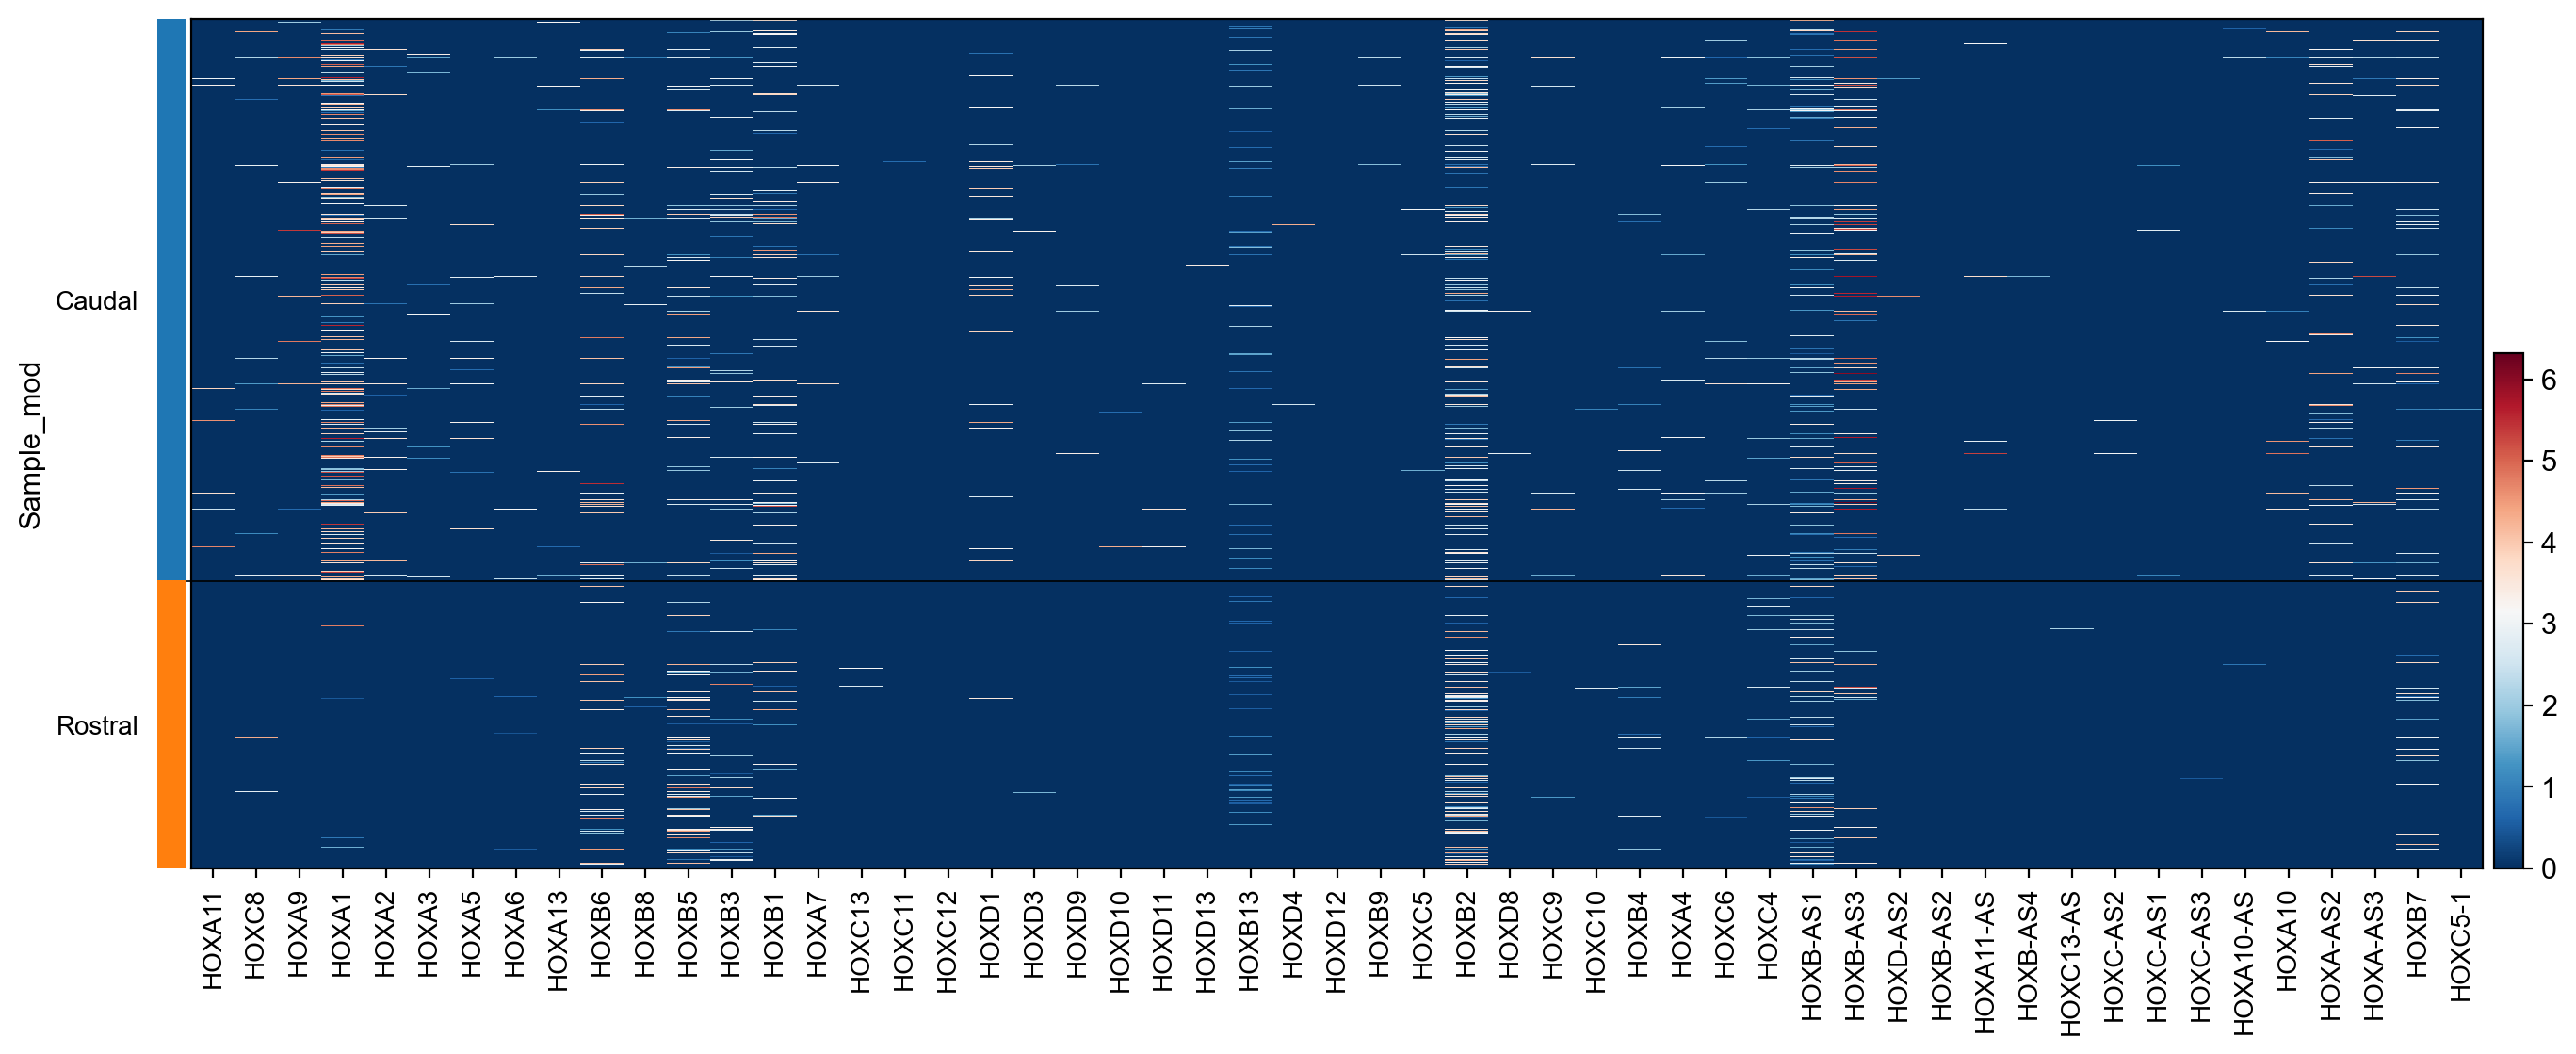

In [25]:
#mm = log_data2[log_data2.obs['clust_id']=='Mature Mesoderm']
import scvelo as scv
scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')

#sc.pp.log1p(log_data2)
#high_var2.raw=log_data2

hox=[]
for h in log_data2.var_names:
    if(h.startswith('HOX')):
        hox.append(h)
sc.pl.heatmap(high_var2[high_var2.obs['Sample_mod'].isin(['Caudal','Rostral'])],groupby='Sample_mod',var_names=hox,show_gene_labels=True)


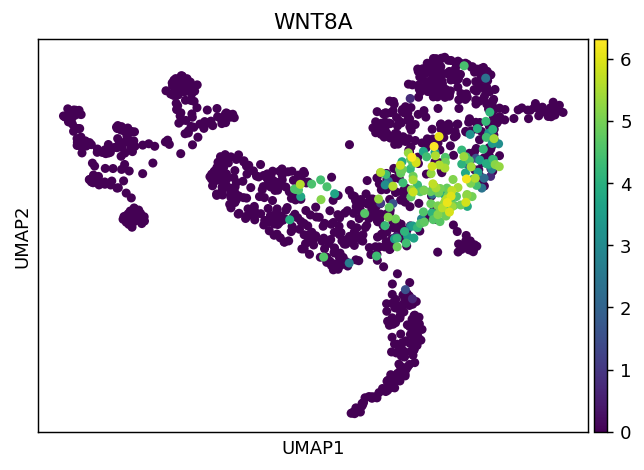

In [13]:
high_var2.raw=log_data2

sc.pl.umap(high_var2,color='WNT8A')

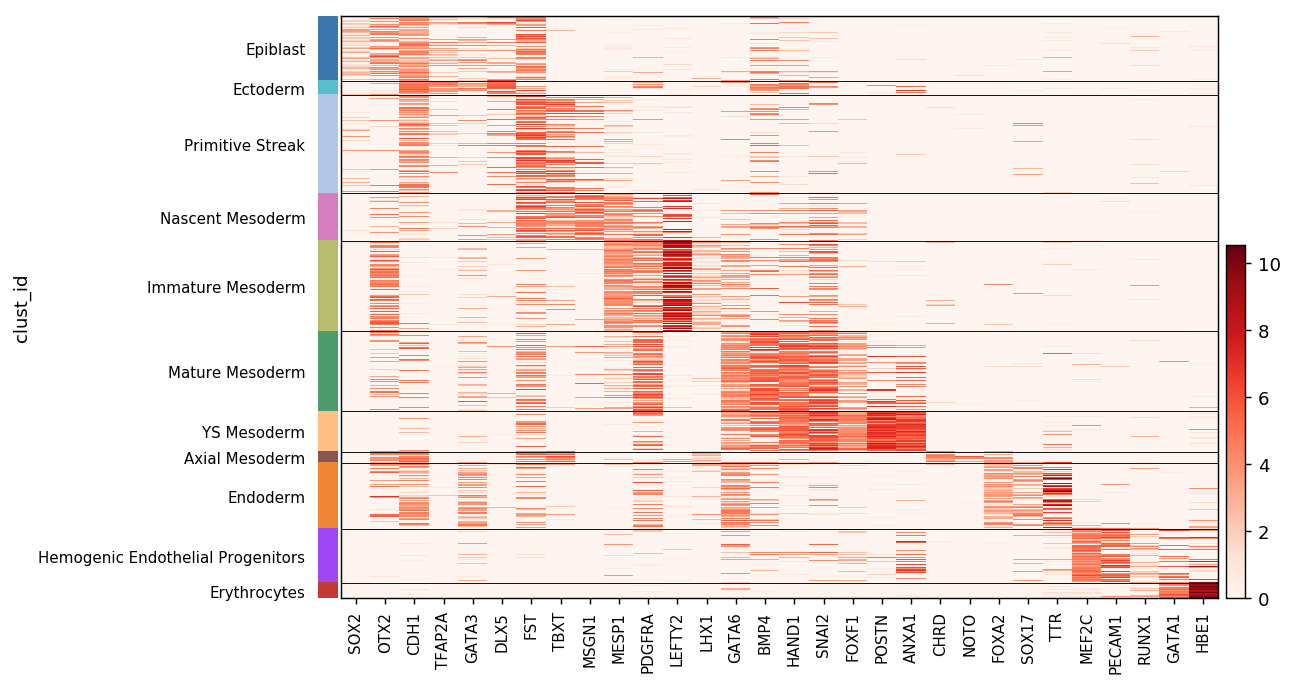

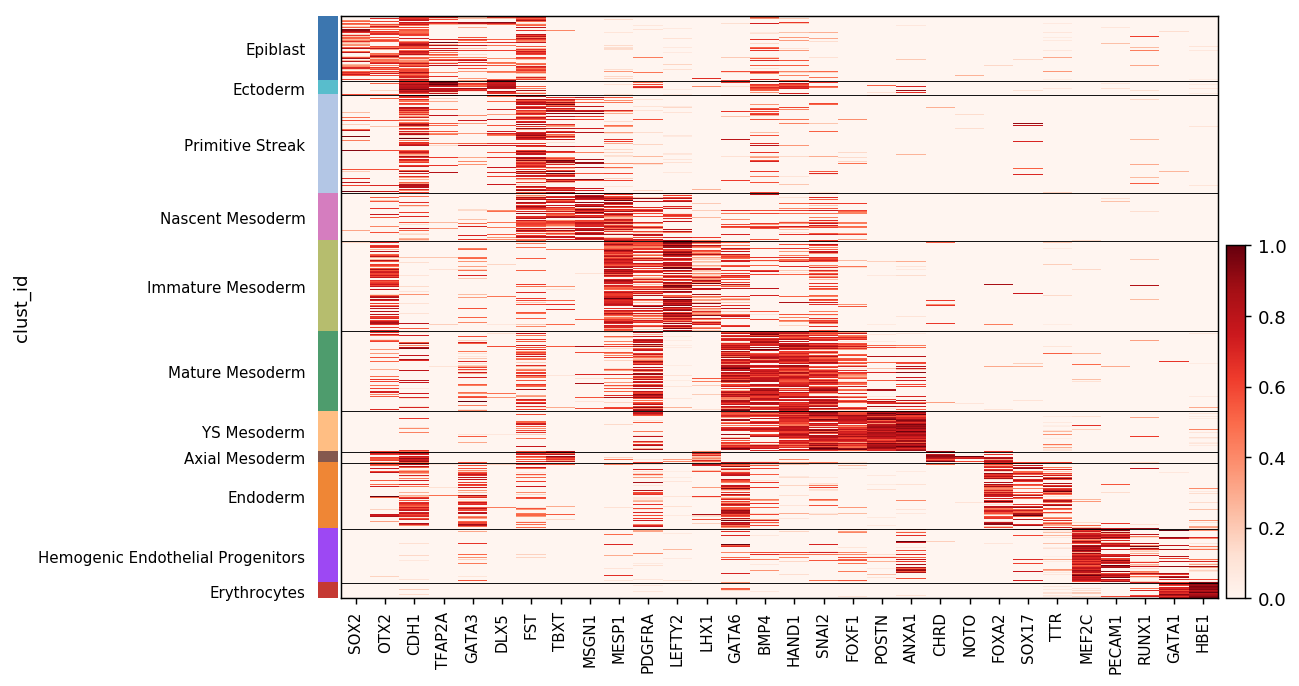

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 9.0, 0, 0.2])

In [106]:
#high_var2.raw=log_data2

log_data2.obs['clust_id']=log_data2.obs['clust_id'].cat.reorder_categories(['Epiblast', 'Ectoderm', 'Primitive Streak', 'Nascent Mesoderm','Immature Mesoderm', 'Mature Mesoderm', 'YS Mesoderm', 'Axial Mesoderm', 'Endoderm', 
                                                  'Hemogenic Endothelial Progenitors', 'Erythrocytes'])
#4E9C6D,Mature Mesoderm
#EF8635,Endoderm
#58BDCC,Ectoderm
#9D48F3,Hemogenic Endothelial Progenitors
#C53933,Erythrocytes
#3C76AF,Epiblast
#84584E,Axial Mesoderm
#B6BD6E,Immature Mesoderm
#D57DBF,Nascent Mesoderm
#B3C6E5,Primitive Streak
#FFBE83,YS Mesoderm
log_data2[:,'LHX1'].X=log_data2[:,'LHX1-1'].X
log_data2.uns['clust_id_colors']=['#3C76AF','#58BDCC','#B3C6E5','#D57DBF','#B6BD6E','#4E9C6D','#FFBE83','#84584E','#EF8635'
                                                                                                               ,'#9D48F3','#C53933']

with open('Genes/mouse_genes.txt', 'r') as f:
    x = f.read().splitlines()
sc.pl.heatmap(log_data2,var_names=x,groupby='clust_id',cmap='Reds')
sc.pl.heatmap(log_data2,var_names=x,groupby='clust_id',cmap='Reds',standard_scale='var')


In [20]:
ps_n = high_var2[high_var2.obs['clust_id']=='Hemogenic Endothelial Progenitors'].obs_names
ps_names = []
for p in ps_n:
    ps_names.append(p[:-2].replace('.','-')+'.cram')
with open('hep_names.txt', 'w') as f:
    for item in ps_names:
        f.write("%s\n" % item)


In [ ]:

for x in list(log_data2.var_names):
    if str(x) in str(x) and x[-2] =='-':
        print(x)
        
    

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


ArrayView([  0.      ,  15.322488,   0.      , ..., 185.56654 ,
           236.88885 , 158.48724 ], dtype=float32)

In [6]:
adata[adata.obs['fraction mito']>0.02].obs

Cell#       Plate      Run lane                          Sample Stage  ... fraction mapped  fraction mito  fraction spike-in  total reads (log10)       cells
X26640_2.230-0     1    X26640_2  X26640_2.230                 Ventricle.Right  CS12  ...        0.818885       0.262340           0.031569             5.774891   bad cells
X26640_1.46-0      1    X26640_1   X26640_1.46                           Blank  CS12  ...        0.738462       0.034615           0.342308             2.414973   bad cells
X24159_1.135-0     1    X24159_1  X24159_1.135                     Outflow.Mid  CS12  ...        0.790989       0.117748           0.096244             5.938703  good cells
X23957_7.211-0     1    X23957_7  X23957_7.211               Outflow.DistalCap  CS12  ...        0.789556       0.040347           0.046918             6.028721  good cells
X23794_8.19-0      1    X23794_8   X23794_8.19  Ventricle.Right.InnerCurvature  CS12  ...        0.794691       0.033438           0.061203             5.808748  good cells
...              ...         ...           ...                             ...   ...  ...             ...            ...                ...                  ...         ...
SS.sc7787466-1     1  SCGC--3391  SS.sc7787466                 Right Ventricle  CS12  ...        0.662433       0.071810           0.304630             6.003982   bad cells
SS.sc7787245-1     1  SCGC--3391  SS.sc7787245                         Outflow  CS12  ...        0.379412       0.025858           0.175517             5.439224   bad cells
SS.sc7787819-1     1  SCGC--3390  SS.sc7787819                          Inflow  CS12  ...        0.506513       0.034748           0.105251             5.850826   bad cells
SS.sc7787120-1     1  SCGC--3392  SS.sc7787120                  Left Ventricle  CS12  ...        0.684592       0.028819           0.100496             5.997734  good cells
SS.sc7786563-1     1  SCGC--2860  SS.sc7786563                          Group1   CS6  ...        0.551587       0.044907           0.487270             5.982986   bad cells

[2520 rows x 12 columns]

G1  G2M   S
sample              
0        88  100  14
1       101   70  14
2       101   55   8
3        78   27  30
4        59   55  19
5        86   22   3
6        34   60   4
7        49   27   7
8        20    7   5
9        20    6   3
10       13    4   6

Trying to set attribute `.obs` of view, copying.


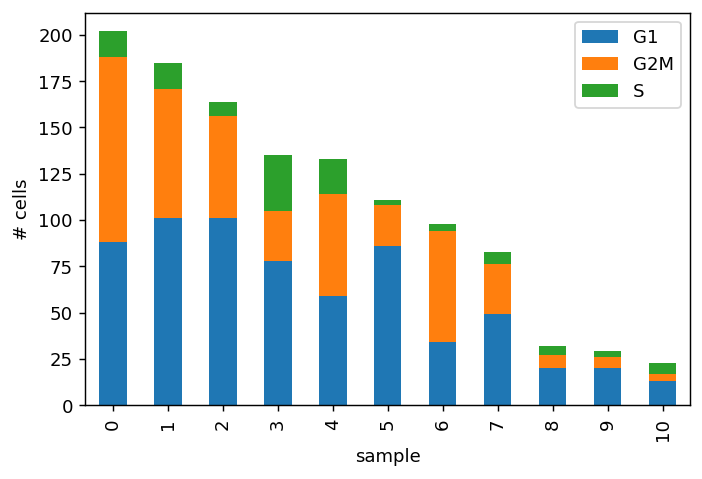

In [14]:
log_data2 = ad.read_csv('normf_data.csv').T    #load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = gast_dat.obs

log_data2 = log_data2[log_data2.obs['Sample']!='Exclude']


from pypairs import pairs, datasets
training_data = datasets.leng15(mode='sorted')
marker_pairs = pairs.sandbag(training_data, fraction=0.65)
cycle_result = pairs.cyclone(log_data2, marker_pairs)
import seaborn as sns
cc_samp2 = pd.DataFrame(dict(sample = list(high_var2.obs['leiden']), cc = cycle_result['max_class']))

cc_samp2['sample'] = cc_samp2['sample'].astype('int32')

cc_samp2 = cc_samp2.groupby(['sample','cc']).size().to_frame().unstack()
cc_samp2.columns = ['G1','G2M','S']
ax = cc_samp2.plot.bar(stacked= True)
ax.set_ylabel('# cells')
endo_cl=list(high_var2.obs['clust_id'])
spat = list( cycle_result['max_class'])

In [43]:
high_var2.obs['sub']=list(pd.read_csv('ori_gast_umap.csv')['sub_cluster'])
high_var2.obs['cluster_id']=list(pd.read_csv('ori_gast_umap.csv')['cluster_id'])

high_var2.obs['cc']=list(cycle_result['max_class'])
endo=high_var2[high_var2.obs['cluster_id']=='Endoderm']
cc_samp2 = pd.DataFrame(dict(sample = list(endo.obs['sub']), cc = list(endo.obs['Sample_mod'])))

cc_samp2=cc_samp2.groupby(['sample','cc']).size().to_frame().unstack()
cc_samp2=cc_samp2.fillna(0)
cc_samp2.apply(lambda x: 100 * x / float(x.sum()),axis=1).to_excel("cc_spat_percent.xlsx", sheet_name='Sheet_name_1')

Saving 7 x 7 in image


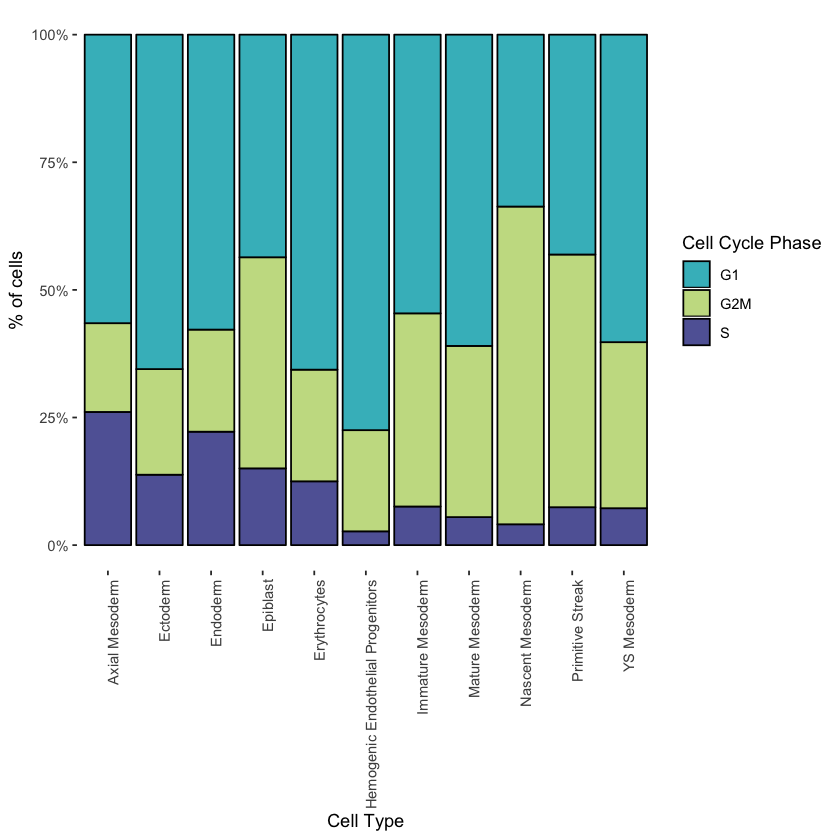

In [310]:
%get endo_cl
%get spat
#location<-spat
library(ggplot2)
#value<-abs(rnorm(1195 , 0 , 21))
data <- data.frame(endo_cl,spat)
#data<-data[order(as.character(data$spat)),]
p<-ggplot() + geom_bar(data=data,aes(x=factor(endo_cl), fill=factor(spat)),position="fill", color='black')+scale_fill_manual(values=c("#41bbc5", "#c7dd91", "#6165a5"))+theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_blank())+labs(fill = "Cell Cycle Phase",x='Cell Type',y='% of cells')+ scale_y_continuous(labels = scales::percent_format())
p
ggsave('figures/Fig2_cc_percent.pdf',plot=p)

In [ ]:
high_var2.obs['cc']=list(cycle_result['max_class'])
#sc.pl.umap(high_var2,color='PTPRC')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

clust_group = high_var.obs['leiden']
clust_samp = pd.DataFrame(dict(clust = list(clust_group), sample = cycle_result['max_class']))
s=list(clust_samp['sample'])

clust_samp.drop('sample',axis=1, inplace = True)
clust_samp['sample'] = s
batch_sample=clust_samp.groupby(['clust','sample']).size().to_frame().reset_index()
batch_sample.columns = ['clust','sample', 'count']
batch_sample = batch_sample[~batch_sample['sample'].isin(['Blank','nan'])]

i=0

pdf = PdfPages('gast_cc.pdf')

for i in range(11):
        ncc = batch_sample[batch_sample['clust']==str(i)]
        fig1, ax1 = plot.subplots()
        ax1.pie(ncc['count'], labels=ncc['sample'], startangle=90,autopct='%1.1f%%')
        ax1.set_title('cluster '+ str(i))
        centre_circle = plot.Circle((0,0),0.40,color='white')
        fig = plot.gcf()
        fig.gca().add_artist(centre_circle)
        ax1.axis('equal')  
        plot.tight_layout()
        pdf.savefig(fig)
        
        plot.show()
pdf.close()


In [ ]:
cl4 = high_var2[high_var2.obs['leiden']=='4']
sc.pl.heatmap(cl4, groupby='Sample_mod',var_names='OTX2',vmin = 0,vmax=5)

... storing 'Sample_mod' as categorical


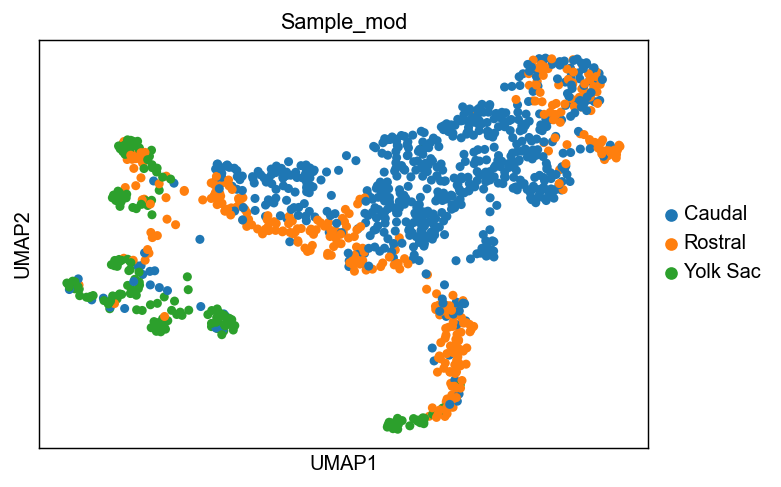

In [163]:
import re
#high_var2.obs = gast_dat.obs
samples = list(high_var2.obs['Sample'])
def trunc_at(s, d, n):
    return d.join(s.split(d, n)[:n])

sampless = []
for s in samples:
    
    if (s == 'Group1'):
        s = 'Rostral'
    if (s == 'Group2'):
        s = 'Caudal'
    if (s == 'Group2 '):
        s = 'Caudal'
    if (s == 'Group3'):
        s = 'Yolk Sac'
    if (s =='Exclude'):
        s ==''
    sampless.append(s)
high_var2.obs['Sample_mod'] = sampless
sc.pl.umap(high_var2,color = 'Sample_mod')

In [ ]:
%get hdf

library(dynamicTreeCut, quietly = TRUE, warn.conflicts = FALSE)
library(Rtsne, quietly = TRUE, warn.conflicts = FALSE)
library(mcclust, quietly = TRUE, warn.conflicts = FALSE)
data<-as.matrix(t(hdf))
cor.mat<-cor(data,method="spearman")
print(dim(cor.mat))
dissim<-sqrt((1-cor.mat)/2)
dist.mat<-as.dist(dissim)
test.clust<-hclust(dist.mat, method="average")
clust<-cutreeDynamic(test.clust,distM=as.matrix(dist.mat), minClusterSize=20, method="hybrid", deepSplit =2)
#dist.mat <- as.matrix(dist.mat)
#clust<-as.integer(clust)

In [ ]:
%get clust --from R
sc.set_figure_params(scanpy=True,color_map='seismic')

sc.pl.umap(high_var2,color='ER71', palette = ["#a1def0", "#2c647e", "#39eec0", "black", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"],frameon=False)


In [63]:
import pypairs
print(pypairs.__version__)

v3.1.1


In [9]:
def PairCmpMark(adata,group_by,cl_lab,ref):
   #Wilcoxon test between cluster labelled cl_lab and reference cluster labelled ref with benjamini-hochberg
   #correction
    tmp=sc.tl.rank_genes_groups(adata, group_by, method= 'wilcoxon', corr_method='benjamini-hochberg',
                      groups=[cl_lab],reference=ref,copy=True,n_genes=len(adata.var_names))
    d = {'names': list(pd.DataFrame(tmp.uns['rank_genes_groups']['names'])[cl_lab]) ,
    'logfoldchanges': list(pd.DataFrame(tmp.uns['rank_genes_groups']['logfoldchanges'])[cl_lab]),
   'pvals_adj': list(pd.DataFrame(tmp.uns['rank_genes_groups']['pvals_adj'])[cl_lab])}
    tmp_df = pd.DataFrame(data=d)
   #Select only genes with log2FC >1 and adjusted p-values <0.1
    tmp_df=tmp_df[tmp_df['logfoldchanges']>1]
    tmp_df=tmp_df[tmp_df['pvals_adj']<0.1]
   #tmp_df=tmp_df[tmp_df['pvals_adj']>0.0]
   #Compute -log10(pvals_adj)
    tmp_df['pvals_adj']=-np.log10(tmp_df['pvals_adj'])
    return tmp_df
#Function for finding markers for cluster labelled cl_lab
# adata: anndata object for the highly variable genes (note that the function uses the .raw attribute of the object,
#        meaning that the log normalized counts for ALL the genes in the dataset are used)
# groupby: annotation of the clusters (it is an obs of the anndata object)
# cl_lab: label of the cluster for which the marker genes are computed (NOTE: the labels are supposed to
#         start from 1)
# nr_clus: number of clusters in the dataset
def FindMarkers(adata,group_by,cl_lab,nr_clus):
    flag=0
    for i in range(nr_clus):
        if str(i)!=cl_lab and flag==0:
            df=PairCmpMark(adata,group_by,cl_lab,str(i)) #compute the first pairwise comparison
            flag=1
        elif str(i)!=cl_lab and flag==1:
            df=df.merge(PairCmpMark(adata,group_by,cl_lab,str(i)),how='outer') #merge the other pairwise comparisons
   #Sort the names in the dataframe (union of all the pairwise comparisons)
    df=df.sort_values(['names'])
   #Count duplicates in names in order to check the number of successful pairwise comparisons for each gene
    dups = df.pivot_table(index=['names'], aggfunc='size')
   #Sum the logfoldchanges and the -log10(pvals_adj)
    df = df.groupby(['names']).agg({'logfoldchanges': sum,
                               'pvals_adj': sum
                               })
   #Add a column with the number of successful pairwise comparisons for a gene
    df['succ_PC']=list(dups)
   #The mean is computed on ALL the pairwise comparisons (nr_clus-1); in this way we penalize genes
   #appearing only in a small number of pairwise comparisons
    df['logfoldchanges']/=float(nr_clus-1)
    df['pvals_adj']/=float(nr_clus-1)
   #Rename the columns
    df=df.rename(columns={"logfoldchanges": "mean_logFC","pvals_adj": "mean_log_pval","succ_PC": "succ_PC"})
   #Delete genes found only in one pairwise comparison
    df=df[df['succ_PC']>1]
   #Sort the dataframe according to the mean of -log10(pvals_adj)
    df=df.sort_values(['mean_log_pval'],ascending=False)
    return df
NR_CLUS=len(Counter(log_data2.obs['leiden']))


In [97]:
np.min(cm.obsm['X_diffmap'][:,1])

ArrayView(-0.1145164, dtype=float32)

In [ ]:
pd.DataFrame(marks).T.to_excel("gast_markers.xlsx", sheet_name='Sheet_name_1')  

In [ ]:
#log_data2.obsm['X_umap']=high_var.obsm['X_umap']
#high_var2.obs.to_csv('abc.csv')
sc.tl.diffmap(high_var2)
sc.pl.diffmap(high_var2,color='clust_id')



    ... did not find original file onefilepercell_SS-sc7785278_and_others_Q4SJ9.loom
... reading from cache file cache/onefilepercell_SS-sc7785278_and_others_Q4SJ9.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Abundance of ['spliced', 'unspliced']: [0.96 0.04]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 36063 genes that are detected 10 counts (spliced).


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 8572 genes that are detected 10 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Exctracted 2500 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations 

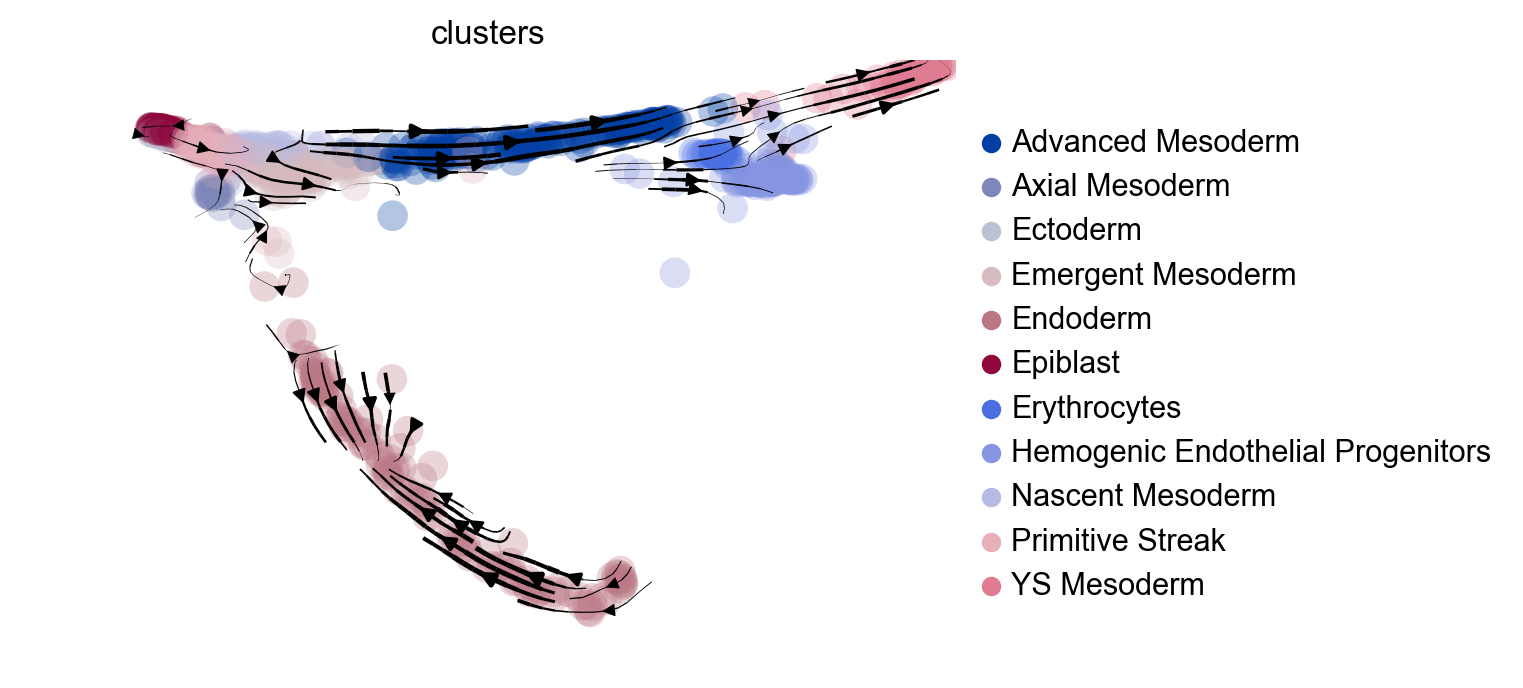

In [26]:
import scvelo as scv
scv.settings.set_figure_params('scvelo')

adata =  scv.read('onefilepercell_SS-sc7785278_and_others_Q4SJ9.loom', cache=True)
scv.utils.show_proportions(adata)
scv.utils.cleanup(adata, clean='all')
onam = []
cm = high_var2.copy()
for o in list(adata.obs.index):
    a=o[45:].replace('-','.')
    onam.append(a[:12])
adata.obs_names = onam
#high_var2.obs_names = list(cm.obs['cell_name'])
#kdata =  high_var2[onam,:]
#cm.obs_names  = list(cm.obs['cell_name'])
cm.obs_names  = list(cm.obs['Run lane'])

inter = list(set(list(cm.obs_names)).intersection(set(list(adata.obs_names))))
adata = adata[inter,:]
cm = cm[inter,:]

adata.obsm['X_umap'] = cm.obsm['X_diffmap'][:,1:4]
adata.obs['clusters'] = list(cm.obs['clust_id'])
scv.utils.cleanup(adata, clean='all')
scv.pp.filter_and_normalize(adata, min_counts=10, min_counts_u=10, n_top_genes=2500)
scv.pp.moments(adata, n_pcs=10, n_neighbors=35)
#scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
#scv.tl.velocity_graph(adata)
scv.tl.velocity_graph(adata)
#scv.tl.velocity_clusters(adata,resolution=0.2)

scv.pl.velocity_embedding_stream(adata, basis='umap',projection='2d',components='1,2',legend_loc='right margin',
                          color="clusters")



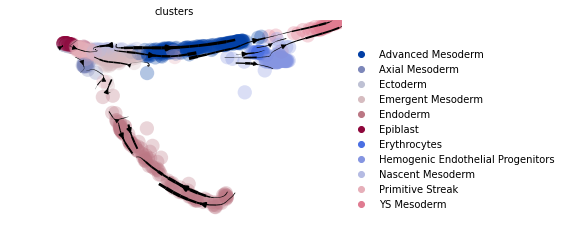

In [6]:
#adata.uns['clusters_colors']=cm.uns['clust_id_colors']
#scv.settings.set_figure_params('scvelo',vector_friendly=False,format='svg')
import scvelo as scv
get_ipython().run_line_magic('matplotlib', 'inline')
adata =  scv.read('velocity_anndata.loom', cache=True)

scv.pl.velocity_embedding_stream(adata, basis='umap',projection='2d',components='1,2',
                          color="clusters",legend_loc='right margin',density=0.5,
                             linewidth=1.8)


In [15]:
bl = pd.DataFrame(bloodh.obsm['X_diffmap'])
bl['cell_name'] = list(bloodh.obs['cell_name'])
bl.to_csv('hep_diffmap_coord.csv')

In [30]:
adata.write_loom('velocity_anndata.loom',write_obsm_varm=True)

## Hemangioblast-Blood Trajectory

In [11]:
import scipy
log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')
#sc.tl.diffmap(bloodh)
#log_data2.obs['Sample_mod'] = list(high_var2.obs['Sample_mod'])
#log_data2.obs['cluster_id'] = list(high_var2.obs['clust_id'])
#log_data2.obs['cc'] = list(high_var2.obs['cc'])
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));
bloo = log_data2[log_data2.obs['sub_cluster']=='Erythrocytes'].copy()
hemann = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors'].copy()
blood = hemann.concatenate(bloo)
#sc.pp.log1p(blood)
sc.pp.filter_genes(blood,min_cells=5)

sc.pp.highly_variable_genes(blood, max_mean=10,n_top_genes=500)
bloodh = blood[:, blood.var['highly_variable']]
bloodh = sc.tl.pca(bloodh,svd_solver = 'arpack', n_comps = 50,copy=True)
bloodh.raw=blood

sc.pp.neighbors(bloodh,n_pcs=10, n_neighbors=20, method = 'umap')

sc.tl.diffmap(bloodh)
#bloodh.obs['leiden']=heman.obs['leiden']
sc.pl.diffmap(bloodh,projection='2d',color='sub_cluster',palette= ["red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"])
#sc.pl.diffmap(bloodh,projection='2d',color='leiden',palette=["black", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"])


AnnData object with n_obs × n_vars = 143 × 500
    obs: 'Unnamed: 0', 'X', 'X0', 'X1', 'cluster_id', 'sub_cluster', 'cell_name', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'diffmap_evals', 'sub_cluster_colors'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

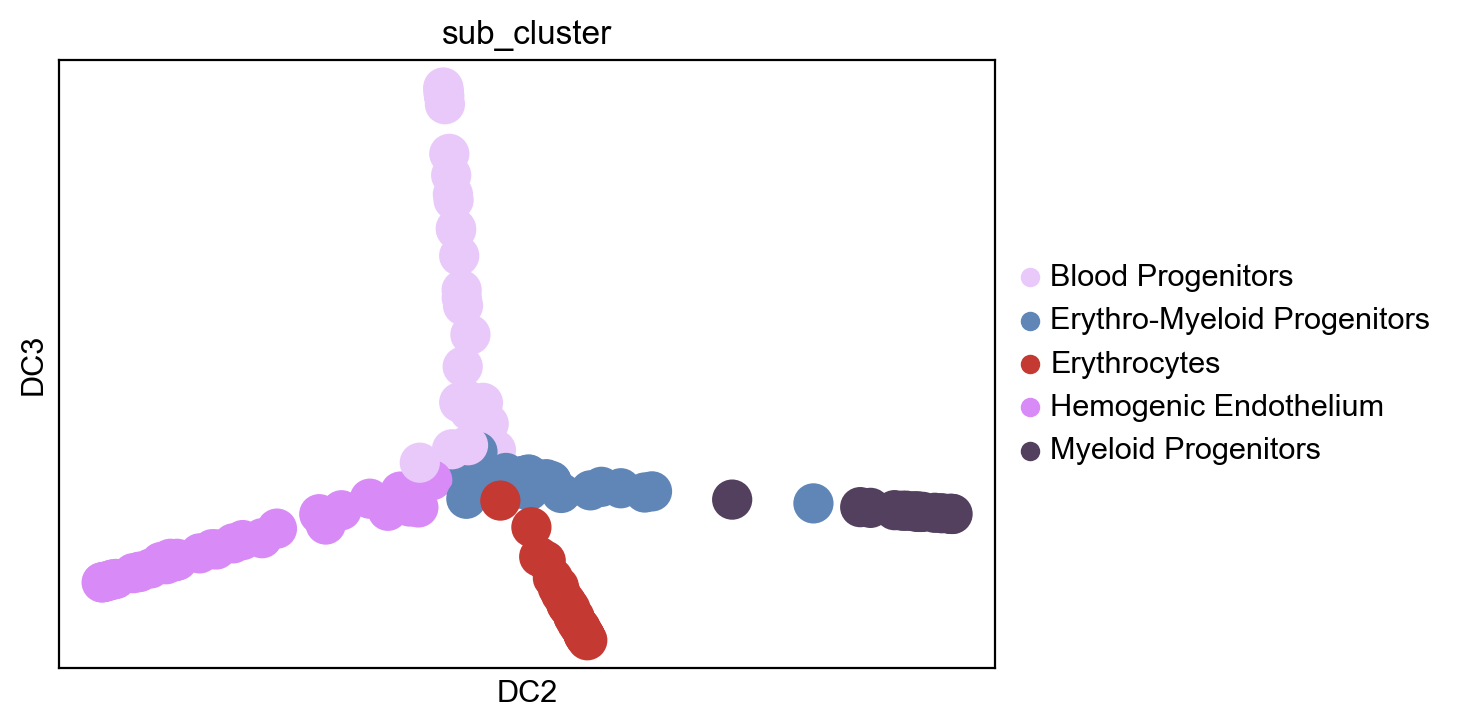

In [127]:
#sc.tl.diffmap(bloodh)
scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')

sc.pl.diffmap(bloodh,projection='2d',color='sub_cluster',palette= [ "#e9c9fa","#5f86b7", '#C53933', "#D88AF7","#533f5e"],components='2,3'
             ,save='blood_DiffMap23.pdf')


In [36]:
mesy = log_data2[log_data2.obs['cluster_id'].isin(['YS Mesoderm','Advanced Mesoderm'])]
sc.tl.rank_genes_groups(mesy,groupby='cluster_id',n_genes=100)
pd.DataFrame(mesy.uns['rank_genes_groups']['names']).to_csv('adv_ys.csv')

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'cluster_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sub_cluster' as categorical


In [ ]:
hema = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
hema.obs=heman.obs
hema.uns['cl_id_colors']=heman.uns['cl_id_colors']
hcp = hema[:,y]
#hcp.obs =hcp.obs.sort_values(by='cl_id')
hcpp = hcp.to_df()
hcpp['cl_id']=hcp.obs['cl_id']
hcpp = hcpp.sort_values(by='cl_id')
clid = hcpp['cl_id']
hcpp.drop(labels = 'cl_id',axis=1,inplace=True)
lut = dict(zip(clid.unique(), ["#5f86b7", "#e586fe", "#533f5e", "#e9c9fa"]))
row_colors = list(clid.map(lut))
'''
g = sns.clustermap(hcpp,row_cluster=False,yticklabels=False,figsize=(35,35),method='average',metric='correlation',row_colors=row_colors,cmap='Reds',standard_scale=True)
g.savefig('Fig4d_heatmap.pdf')
#sc.pl.clustermap(hcp, obs_keys='cl_id',cmap='Reds',row_cluster=True,save='fid4dhm.pdf',vmin=0,vmax=1)

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dty

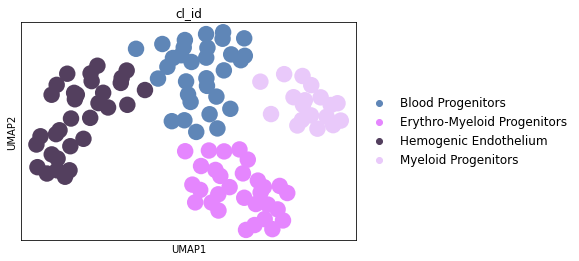

In [9]:
%matplotlib inline
log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')

#log_data2 = log_data2[log_data2.obs['Sample']!='Exclude']

#log_data2.obs['cluster_id'] = list(high_var2.obs['clust_id'])
heman = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
#sc.pp.log1p(heman)
sc.pp.highly_variable_genes(heman, max_mean=10,n_top_genes=1000)
heman = heman[:, heman.var['highly_variable']]
heman = sc.tl.pca(heman,svd_solver = 'arpack', n_comps = 50,copy=True)
sc.pp.neighbors(heman,n_pcs=10, n_neighbors=20, method = 'umap',metric=spearman_dist)

sc.tl.leiden(heman,resolution=0.75)
endo_cl = []
for c in list(heman.obs['leiden']):
    if(c =='0'):
        endo_cl.append('Hemogenic Endothelium')
    if(c =='1'):
        endo_cl.append('Blood Progenitors')
    if(c =='2'):
        endo_cl.append('Erythro-Myeloid Progenitors')
    if(c =='3'):
        endo_cl.append('Myeloid Progenitors')
heman.obs['cl_id']=endo_cl

sc.tl.umap(heman)
#heman.obs['hem_id']=hem_id
heman.raw = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
sc.pl.umap(heman,color='cl_id',palette=["#5f86b7", "#e586fe", "#533f5e", "#e9c9fa"],legend_fontsize='large',save='Fig4d.pdf')

#sc.pl.umap(heman,color='Sample_mod')


In [10]:
log_data2.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.3926721, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.1304169, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [442]:
%get g8
convertMouseGeneList <- function(x){
 
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
 
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <-genesV2[, 2]
mousex <-genesV2[, 1]
# Print the first 6 genes found to the screen
print(head(humanx))
return(list(v1=humanx,v2=mousex))

}
hmg<-convertMouseGeneList(g8)


[1] "MT-CO3"    "ARHGDIB"   "HNRNPA2B1" "CDH5"      "TMSB4X"    "GIMAP1"   


In [552]:
'''%get hmg --from R
g8= hmg['v1']
g77 = g77.mean(axis=1)
g88 = g88.mean(axis=1)
g78 = pd.concat([g77,g88],axis=1)
g78.columns=['Up E7.25','Up E8.25']
#g78['sub_cl']=list(heman.obs['cl_id'])
#g78 = pd.melt(g78, id_vars='sub_cl')
lut = dict(zip(heman.obs['cl_id'].unique(), [ "#5f86b7","#C53933", "#e586fe","#533f5e"]))
row_colors = list(heman.obs['cl_id'].map(lut))

sns.clustermap(data=g78,row_colors=row_colors,row_cluster=False)

hep = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
g77 = hep[:,(g7+g8)]
#g88 = hep[:,g8]
g77.obs['sub_cl']=list(heman.obs['cl_id'])
sc.pl.heatmap(g77,groupby='sub_cl',var_names=(g7[:20]+g8[:20]),show_gene_labels=True,var_group_positions=[(0,19),(20,40)],
              cmap='cividis',standard_scale='var')
'''
#log_data2.obs['Sample_mod'] = list(high_var2.obs['Sample_mod'])
log_data2 = ad.read_csv('script_heart+gastr/norm_true_data.csv')    #load the normalized data
log_data2= sc.pp.log1p(log_data2,copy = True)


log_data2.obs['cluster_id'] = list(high_var2.obs['clust_id'])
heman = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
g77.obs['sub_cl'].to_csv('heman_cl.csv')


In [290]:
log_data2.obs=high_var2.obs
cl4 = log_data2[log_data2.obs['clust_id']=='Hemogenic Endothelial Progenitors']
cl4.obs=heman.obs
sc.pp.filter_genes(cl4,min_cells=5)
sc.pp.log1p(cl4)
cl4.uns['cl_id_colors']=["#5f86b7", "#e586fe", "#533f5e", "#e9c9fa"]

sc.tl.rank_genes_groups(cl4,groupby='cl_id', method= 'wilcoxon', corr_method='benjamini-hochberg',)
ros_cau=pd.DataFrame(cl4.uns['rank_genes_groups']['pvals_adj']).head(100)
#sc.pl.rank_genes_groups_heatmap(cl4,groupby='cl_id',n_genes=5,cmap='Reds',save='Supp_fig5.pdf',standard_scale='var')
ros_cau.to_excel('Hema_list_padj.xlsx',sheet_name='Sheet_name1')

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.
... storing 'Cell#' as categorical
... storing 'Plate' as categorical
... storing 'Sample' as categorical
... storing 'cluster_id' as categorical


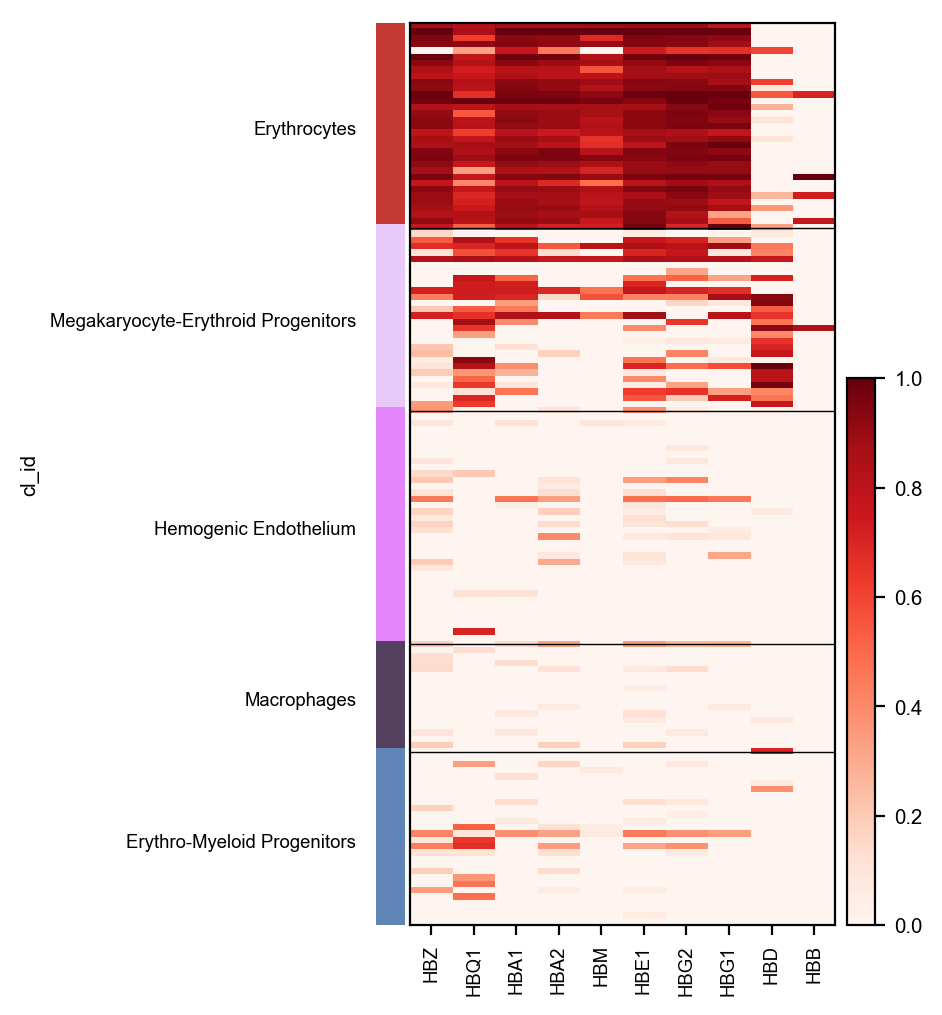

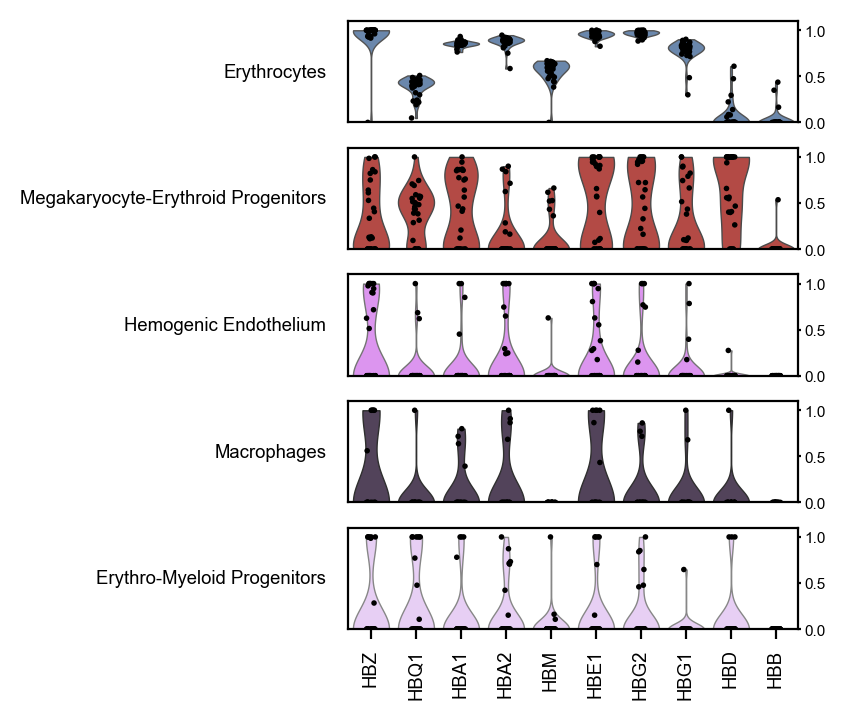

In [837]:
with open('Genes/hem_ery_genes.txt', 'r') as f:
    x = f.readlines()
y = []
for x in x:
    y.append(x[:-1])
log_data2.obs['cluster_id'] = high_var2.obs['clust_id']
blood = log_data2[log_data2.obs['cluster_id']=='Erythrocytes']
hema= log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
blood.obs['cl_id']='Erythrocytes'
hema.obs['cl_id']=endo_cl
hebl = blood.concatenate(hema)
hebl.obs['cl_id'] = hebl.obs['cl_id'].astype('category')
hebl.obs['cl_id']=hebl.obs['cl_id'].cat.reorder_categories(['Erythrocytes','Megakaryocyte-Erythroid Progenitors','Hemogenic Endothelium','Macrophages','Erythro-Myeloid Progenitors'])
hebl.uns['cl_id_colors']=["#C53933", "#e9c9fa","#e586fe", "#533f5e", "#5f86b7"]
sc.pl.heatmap(hebl, var_names = y,groupby='cl_id',cmap='Reds',standard_scale='var',save='Blood_heatmap.pdf')

#fig = plot.figure(figsize=(8,8)) 
ax = sc.pl.stacked_violin(hebl, var_names=y, groupby='cl_id',swap_axes=False,
                     jitter=True,stripplot=True,size=2,standard_scale='obs',
                     row_palette=["#5f86b7","#C53933", "#e586fe", "#533f5e", "#e9c9fa"],show=False)
for i in range(0,len(ax)):
    ax[i].set_ylim(ymin=0,ymax=1.1)
plot.subplots_adjust(wspace=0, hspace=0.25)
plot.savefig('figures/Fig4e.pdf',format='pdf',bbox_inches='tight')




In [838]:
#i=0
NR_CLUS=len(Counter(hep.obs['leiden']))

hep = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
hep.obs['leiden']=heman.obs['leiden']
#ch0 = FindMarkers(hep,'leiden','2',NR_CLUS)
marks = []

for i in range(3):
    mark = FindMarkers(hep,'leiden',str(i),NR_CLUS)
    mark = mark.sort_values(by=['succ_PC','mean_log_pval'],ascending=False)
    marks.append(list(map(lambda x, y: x+ ' ' +str(y), list(mark.index), list(mark['succ_PC']))))
pd.DataFrame(marks).T.to_excel("hep_markers2.xlsx", sheet_name='Sheet_name_1')  

#mark.sort_values(by=['succ_PC','mean_log_pval'],ascending=False)




---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
script_3803045364360732080 in <module>
----> NR_CLUS=len(Counter(hep.obs['leiden']))
      
      hep = log_data2[log_data2.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
      hep.obs['leiden']=heman.obs['leiden']

NameError: name 'hep' is not defined


In [ ]:
#high_var2.obsm['X_umap'][:,0]= high_var2.obsm['X_umap'][:,0]*-1
sc.pl.umap(high_var2,color='clust_id',groups=['Axial Mesoderm','Immature Mesoderm','Mature Mesoderm','Nascent Mesoderm','Primitive Streak',
'YS Mesoderm'],save='_meso.pdf')

In [ ]:
#4E9C6D,Mature Mesoderm
#EF8635,Endoderm
#58BDCC,Ectoderm
#9D48F3,Hemogenic Endothelial Progenitors
#C53933,Erythrocytes
#3C76AF,Epiblast
#84584E,Axial Mesoderm
#B6BD6E,Immature Mesoderm
#D57DBF,Nascent Mesoderm
#B3C6E5,Primitive Streak
#FFBE83,YS Mesoderm
#high_var2[high_var2.obs['leiden']=='4']


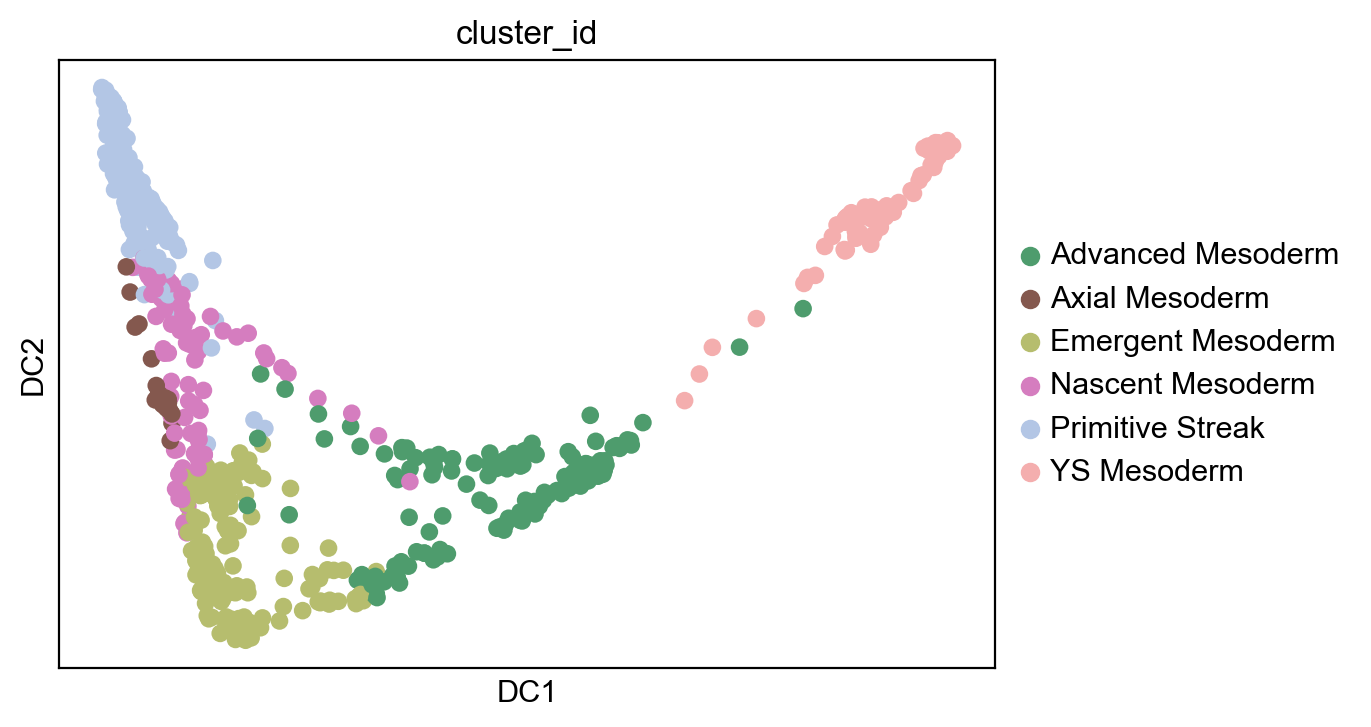

In [252]:
log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')

#log_data2.obs['Sample_mod']= list(high_var2.obs['Sample_mod'])


ps = log_data2[log_data2.obs['cluster_id']=='Primitive Streak'].copy()
nm = log_data2[log_data2.obs['cluster_id']=='Nascent Mesoderm'].copy()
im = log_data2[log_data2.obs['cluster_id']=='Emergent Mesoderm'].copy()
mm = log_data2[log_data2.obs['cluster_id']=='Advanced Mesoderm'].copy()
am = log_data2[log_data2.obs['cluster_id']=='Axial Mesoderm'].copy()
ym = log_data2[log_data2.obs['cluster_id']=='YS Mesoderm'].copy()
cm = ps.concatenate(nm,im,mm,am,ym)
sc.pp.filter_genes(cm, min_cells=10)
sc.pp.highly_variable_genes(cm, max_mean=10,n_top_genes=2000)
cm = cm[:, cm.var['highly_variable']]
cm = sc.tl.pca(cm,svd_solver = 'arpack', n_comps = 50,copy=True)

sc.pp.neighbors(cm,n_pcs=15,n_neighbors=30, method = 'umap',metric=spearman_dist)

sc.tl.diffmap(cm)
sc.pl.diffmap(cm,projection='2d',color='cluster_id',components='1,2',palette= ["#4E9C6D","#84584E", "#B6BD6E", "#D57DBF",'#B3C6E5','#f4aeae'])

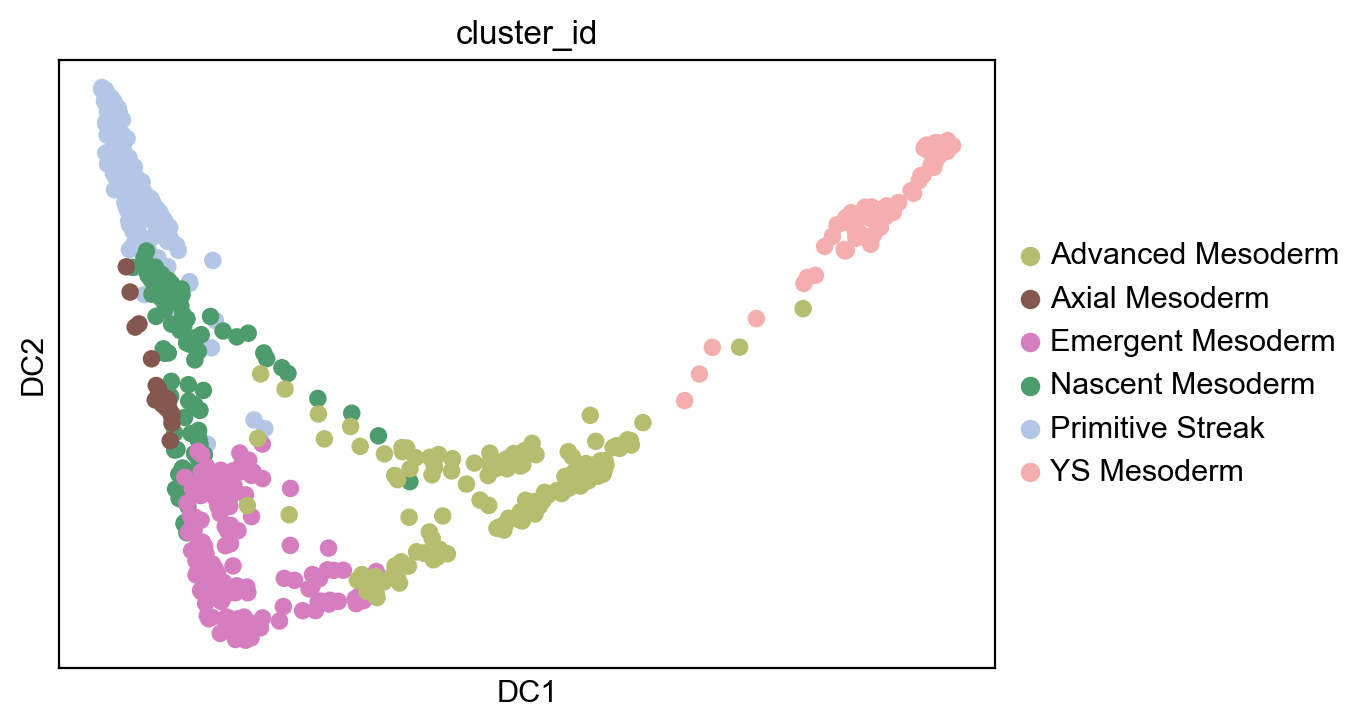


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
script_621689812517113923 in <module>
      scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')
      sc.pl.diffmap(cm,projection='2d',color='cluster_id',components='1,2',palette= ["#B6BD6E","#84584E", "#D57DBF","#4E9C6D", '#B3C6E5','#f4aeae'],save='meso_diffmap.pdf')
----> sc.pl.diffmap(cm,projection='2d',color='Sample_mod',components='2,3',palette=['#2ca02c','#1f77b4', '#ff7f0e' ],save='meso_spatial_DC23')
      

KeyError: Could not find key Sample_mod in .var_names or .obs.columns.


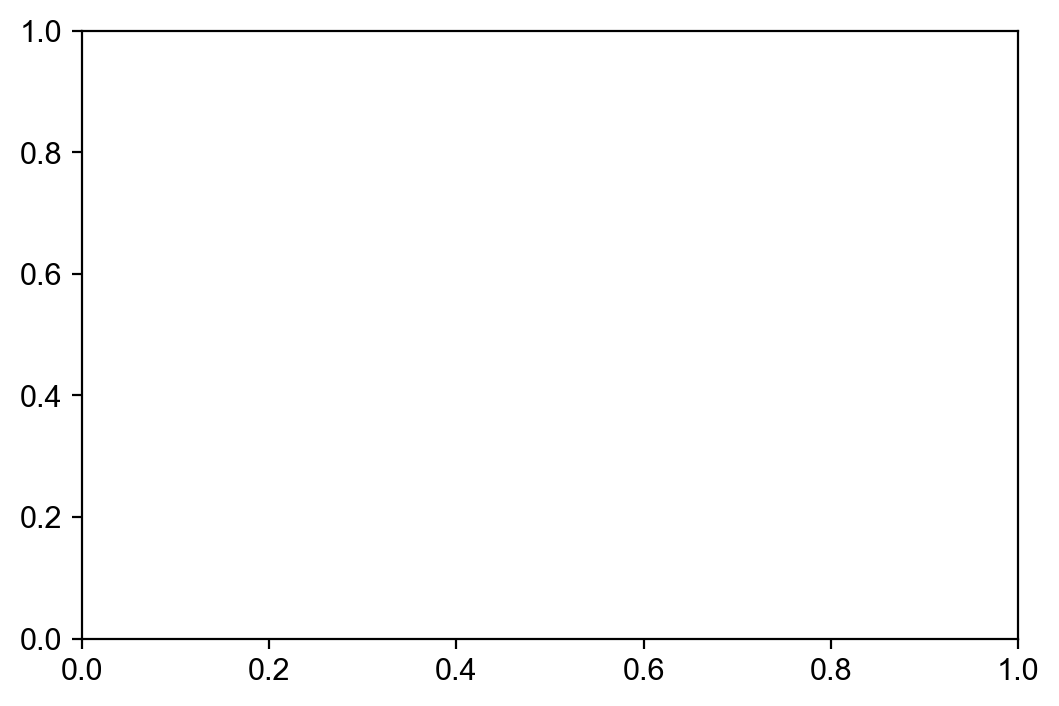

In [83]:
import scvelo as scv
scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')
sc.pl.diffmap(cm,projection='2d',color='cluster_id',components='1,2',palette= ["#B6BD6E","#84584E", "#D57DBF","#4E9C6D", '#B3C6E5','#f4aeae'],save='meso_diffmap.pdf')
#sc.pl.diffmap(cm,projection='2d',color='NKX2-5',components='1,2',palette= ["#84584E", "#B6BD6E", "#4E9C6D", "#D57DBF",'#B3C6E5','#FFBE83'])
#sc.pl.diffmap(cm,projection='2d',color='Sample_mod',components='2,3',palette=['#2ca02c','#1f77b4', '#ff7f0e' ],save='meso_spatial_DC23')
#np.savetxt('meso_expr.csv',cm.obsm['X_diffmap'][1:4],delimiter=',')
#cm.to_df().to_txt('xx.t')
#cm.raw=ps.concatenate(nm,im,mm,am,ym)
#sc.pl.diffmap(cm,color='TNNT2',cmap='cividis',components='1,3',save='tnnt2_3.pdf')
#sc.pl.diffmap(cm,color='NKX2-5',groups='YS Mesoderm',cmap='cividis',components='1,2',save='nkx25.pdf')

#pd.DataFrame(cm.obsm['X_diffmap'][:,1:4])


... storing 'Sample' as categorical
... storing 'Cell#' as categorical
... storing 'Plate' as categorical
... storing 'leiden' as categorical
... storing 'Sample_mod' as categorical
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


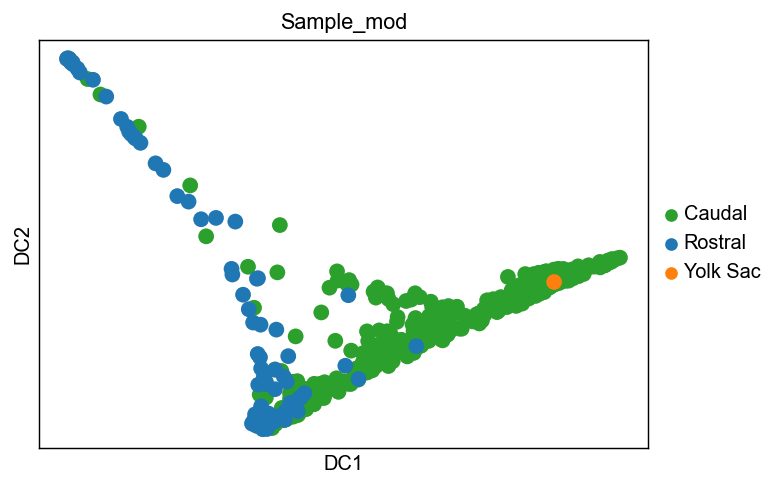

In [165]:
cm.obs = sp.obs
ax = sc.pl.diffmap(cm, size=300,components='1,2',show=False)
sc.pl.diffmap(cm[cm.obs["Sample_mod"] == 'Caudal'] , size=300,color='Sample_mod',palette=["#2ca02c"],show=False,ax=ax,components='1,2')
sc.pl.diffmap(cm[cm.obs["Sample_mod"] == 'Rostral'],size=300,color='Sample_mod',palette=["#1f77b4"],ax=ax,show=False,components='1,2')
sc.pl.diffmap(cm[cm.obs["Sample_mod"] == 'Yolk Sac'],size=300,color='Sample_mod',palette=["#ff7f0e"],ax=ax,components='1,2',save='Fig4a_spatial.pdf')



... storing 'cluster_id' as categorical
... storing 'sub_cluster' as categorical


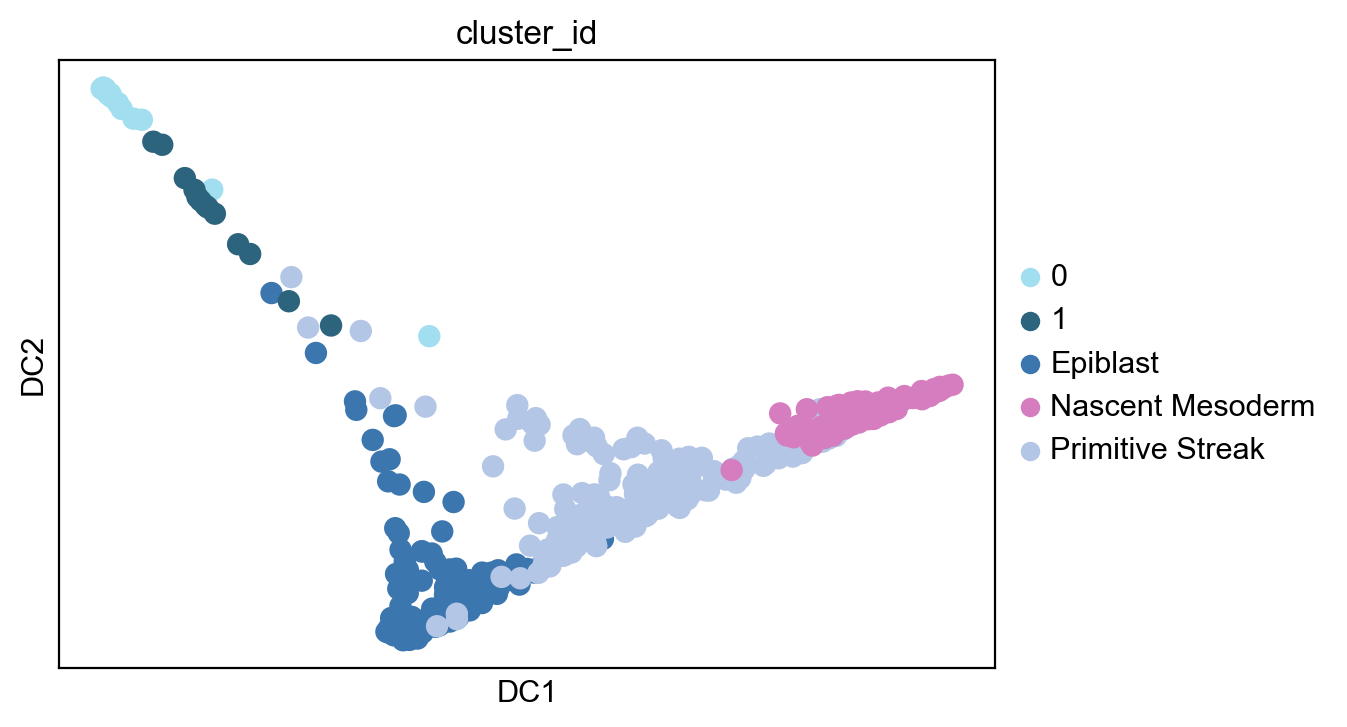

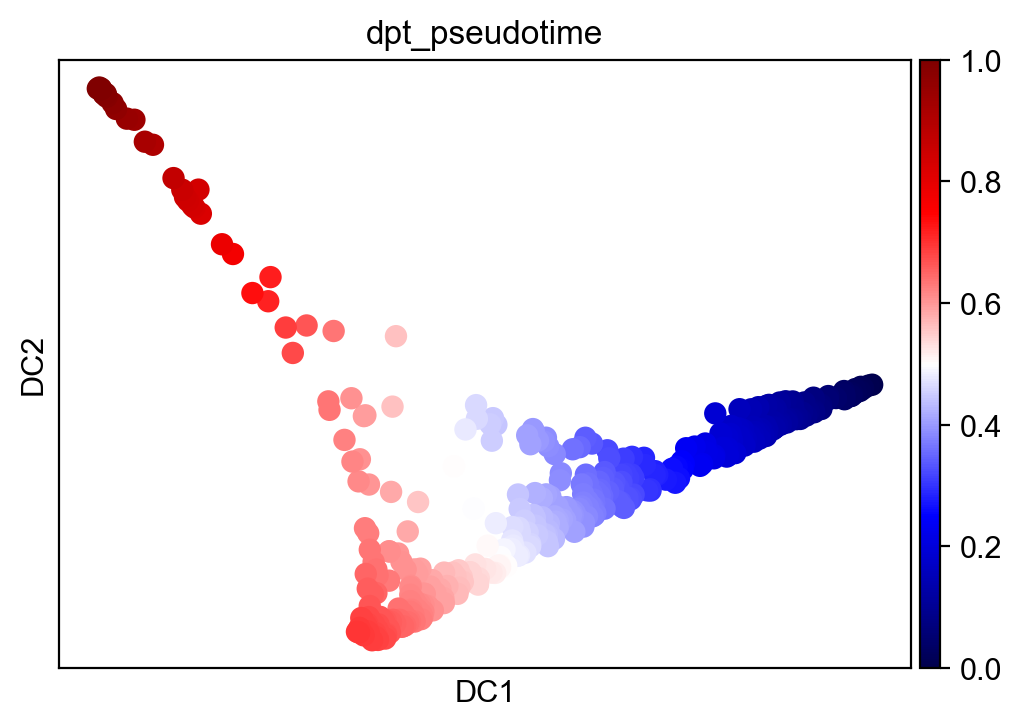

In [22]:
ect.obs['cluster_id']=list(ect2.obs['leiden'])
cm= cl1.concatenate(cl0,cl6,ect)
#sc.pp.filter_genes(cm, min_cells=10)
sc.pp.log1p(cm)
import scipy
sc.pp.highly_variable_genes(cm, max_mean=10,n_top_genes=300)
cm = cm[:, cm.var['highly_variable']]
cm = sc.tl.pca(cm,svd_solver = 'arpack', n_comps = 50,copy=True)
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));

sc.pp.neighbors(cm,n_pcs=6,n_neighbors=30, method = 'umap')

sc.tl.diffmap(cm)

import scvelo as scv
scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')

sc.pl.diffmap(cm,projection='2d',color='cluster_id',palette=["#a1def0", "#2c647e",'#3C76AF',"#D57DBF",'#B3C6E5'],save='_Ecto_Epi_sub.pdf')
a= list(cm.obsm['X_diffmap'][:,1])
root = a.index(max(a))

cm.uns['iroot']=root
sc.tl.dpt(cm,n_dcs=3)

#cm.obs['dpt_pseudotime'] = 1-cm.obs['dpt_pseudotime']
pseudo=list(cm.obs['dpt_pseudotime'])

sc.pl.diffmap(cm,color='dpt_pseudotime',cmap='seismic',save='Fig2c_dpt.pdf')


In [21]:

log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')

#log_data2 = log_data2[log_data2.obs['Sample']!='Exclude']

#log_data2.obs['leiden']=list(high_var2.obs['leiden'])
#log_data2.obs['cluster_id']=list(high_var2.obs['clust_id'])

#log_data2.obs['Sample_mod']= list(high_var2.obs['Sample_mod'])
#sc.pp.log1p(log_data2)
#sc.pp.filter_genes(log_data2,min_cells=10)
cl0 = log_data2[log_data2.obs['cluster_id']=='Primitive Streak'].copy()
cl1 = log_data2[log_data2.obs['cluster_id']=='Epiblast'].copy()
cl2 = log_data2[log_data2.obs['cluster_id']=='Ectoderm'].copy()
cl6 = log_data2[log_data2.obs['cluster_id']=='Nascent Mesoderm'].copy()
#cl4 = log_data2[log_data2.obs['leiden']=='4']


In [ ]:
'''ax = sc.pl.diffmap(cm, size=300,components='1,3',show=False)
sc.pl.diffmap(cm[cm.obs["pgc"] == 'Primitive Streak'] , size=300,color='pgc',palette=["#B3C6E5"],show=False,ax=ax,components='1,3')
sc.pl.diffmap(cm[cm.obs["pgc"] == 'PGC'],size=300,color='pgc',palette=["#b51d49"],ax=ax,components='1,3',save='PGC_diffmapDC1_3.pdf')
'''
ax = sc.pl.diffmap(cm, size=300,components='1,2',show=False)
sc.pl.diffmap(cm[cm.obs["Sample_mod"] == 'Caudal'] , size=300,color='Sample_mod',palette=["#2ca02c"],show=False,ax=ax,components='1,2')
sc.pl.diffmap(cm[cm.obs["Sample_mod"] == 'Rostral'],size=300,color='Sample_mod',palette=["#1f77b4"],ax=ax,show=False,components='1,2')
sc.pl.diffmap(cm[cm.obs["Sample_mod"] == 'Yolk Sac'],size=300,color='Sample_mod',palette=["#ff7f0e"],ax=ax,components='1,2',save='Fig2c_spatial.pdf')



In [ ]:
cm.raw= sc.pp.log1p(cl1.concatenate(cl0,cl2,cl6),copy=True)
sc.pl.violin(cm, keys=['PAX6','SOX3'],palette=["#8de4d3", "#02531d"],save='PAX_SOX_expr.pdf')

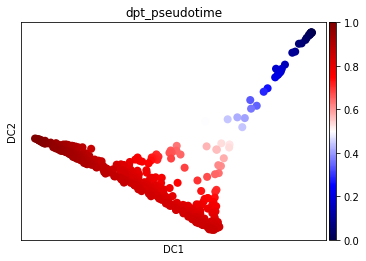

In [100]:
a= list(cm.obsm['X_diffmap'][:,1])
root = a.index(max(a))

cm.uns['iroot']=root
sc.tl.dpt(cm,n_dcs=3)

#cm.obs['dpt_pseudotime'] = 1-cm.obs['dpt_pseudotime']
pseudo=list(cm.obs['dpt_pseudotime'])

sc.pl.diffmap(cm,color='dpt_pseudotime',cmap='seismic',save='Fig2c_dpt.pdf')


In [64]:


log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')
cl0 = log_data2[log_data2.obs['leiden']=='0']
cl1 = log_data2[log_data2.obs['leiden']=='1']
cl2 = log_data2[log_data2.obs['leiden']=='6']
cl6 = log_data2[log_data2.obs['leiden']=='2']
cl4 = log_data2[log_data2.obs['leiden']=='3']
log_data2.obs = high_var2.obs
#cm= cl1.concatenate(cl0,cl2,cl6,cl4)
cm = cl4
#sc.pp.filter_genes(cm, min_cells=10)
#sc.pp.log1p(cm)
sc.pp.highly_variable_genes(cm, max_mean=10,n_top_genes=1000)
cm = cm[:, cm.var['highly_variable']]
cm = sc.tl.pca(cm,svd_solver = 'arpack', n_comps = 50,copy=True)

sc.pp.neighbors(cm,n_pcs=10,
                n_neighbors=20, method = 'umap')

cm.raw= cl4
sc.tl.diffmap(cm)
#sc.pl.diffmap(cm,projection='2d',color='cluster_id',palette= ["#a1def0", "#2c647e", "#39eec0", "black", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"])

sc.pl.diffmap(cm,projection='2d',color='leiden',components='1,2',palette=['#2ca02c',  '#1f77b4','#ff7f0e'])



---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
script_9068994133054367699 in <module>
      log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
      log_data2.obs = pd.read_csv('ori_gast_umap.csv')
----> cl0 = log_data2[log_data2.obs['leiden']=='0']
      cl1 = log_data2[log_data2.obs['leiden']=='1']
      cl2 = log_data2[log_data2.obs['leiden']=='6']
      cl6 = log_data2[log_data2.obs['leiden']=='2']

KeyError: leiden


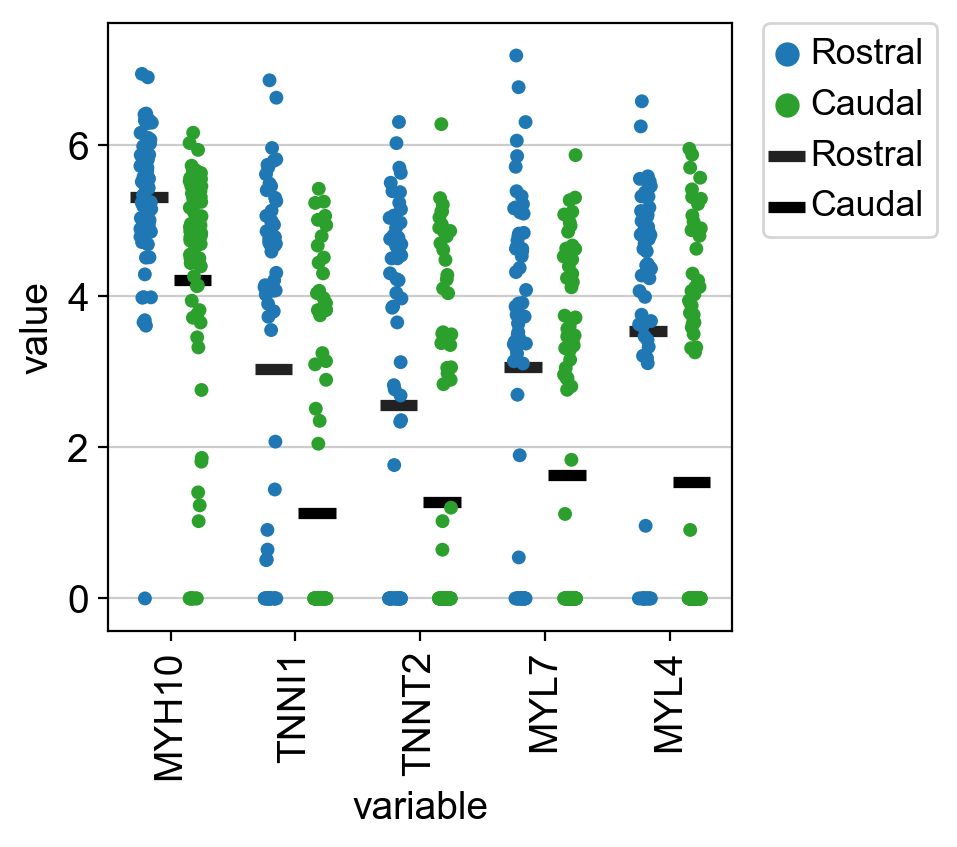

In [161]:
#sc.set_figure_params(scanpy='True',dpi_save=250, dpi=150,vector_friendly=False,format='pdf')

#sc.pl.diffmap(cm,projection='2d',color='TDGF1',components='1,3',cmap='cividis',save='tdgf1_1.pdf')
#meso.uns['Sample_mod_colors']=['#2ca02c','#1f77b4']
meso = log_data2[log_data2.obs['clust_id']=='Mature Mesoderm']
mesdf = meso.to_df()
#mesdf = mesdf[['CDH1','CDX1','HOXA1','CDX1','MYH10','TNNI1','TNNT2','MYL7','NKX2-5','TBX5','ISL1','MAB21L2']]
mesdf = mesdf[['MYH10','TNNI1', 'TNNT2','MYL7','MYL4']]
#mesdf=mesdf/mesdf.max()

mesdf['samp']=list(meso.obs['Sample_mod'])
mesdf= pd.melt(mesdf, id_vars='samp')
import seaborn as sns
from numpy import mean
fig, ax = plot.subplots()

#sns.swarmplot(x="variable", y="value", hue="samp", data=mesdf,palette=["#1f77b4","#2ca02c"],dodge=True)
ax1=sns.stripplot(x="variable", y="value", hue="samp", data=mesdf,palette=["#1f77b4","#2ca02c"],jitter=True,dodge=0.3)
sns.pointplot(x="variable", y="value", hue="samp", data=mesdf,scale=2,markers='_', color='black',join=False,dodge=0.35,ax=ax1,estimator=mean,ci=None)
plot.xticks(rotation=90)
plot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot.savefig('meso_2.pdf', bbox_inches='tight')



In [16]:
import scipy
sc.set_figure_params(scanpy='True',dpi_save=250, dpi=100,vector_friendly=False,format='pdf')
#log_data2.obs['Sample_mod'] = list(high_var2.obs['Sample_mod'])
log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")#load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')
#sc.tl.diffmap(bloodh)
#log_data2.obs['cc'] = list(high_var2.obs['cc'])
heman = log_data2[log_data2.obs['cluster_id']=='Endoderm']
#sc.pp.log1p(heman)
sc.pp.filter_genes(heman, min_cells=10)

sc.pp.highly_variable_genes(heman, max_mean=10,n_top_genes=1000)
heman = heman[:, heman.var['highly_variable']]
heman = sc.tl.pca(heman,svd_solver = 'arpack', n_comps = 50,copy=True)
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));

sc.pp.neighbors(heman,n_pcs=10, n_neighbors=15, method = 'umap',metric=spearman_dist)

sc.tl.leiden(heman,resolution=0.75)
sc.tl.umap(heman)
#heman.obs['hem_id']=hem_id
heman.raw = log_data2[log_data2.obs['cluster_id']=='Endoderm']
#sc.pl.umap(heman,color='leiden',palette=["#5f86b7", "#e586fe", "#533f5e", "#e9c9fa"])
#cm.obs['leiden']=heman.obs['leiden']
#cm.obs['cc']=heman.obs['cc']
cm = heman.copy()
endo_cl = []
for c in list(heman.obs['leiden']):
    if(c =='0'):
        endo_cl.append('YS Endoderm')
    if(c =='1'):
        endo_cl.append('DE(P)')
    if(c =='2'):
        endo_cl.append('Hypoblast')
    if(c =='3'):
        endo_cl.append('DE(NP)')
cm.obs['cl_id']=endo_cl


sc.tl.diffmap(cm)
sc.pl.diffmap(cm,color='cl_id',palette=["#df72ef", "#480f2d", "#fbcab9", "#bd836e"],components='1,3')
sc.pl.diffmap(cm,color='Sample_mod',palette=["#df72ef", "#480f2d", "#fbcab9", "#bd836e"],components='1,3')

#sc.pl.diffmap(cm,color='cl_id',components='1,3',palette=["#df72ef", "#480f2d", "#fbcab9", "#bd836e"],save='endo_diffmap_DC13.pdf')

#sc.pl.diffmap(cm,color='HHEX',cmap='copper',components='1,3',save='hhex.pdf',frameon=False)
#sc.pl.diffmap(cm,color='Sample_mod',save='endo_spatial_DC12.pdf')
#sc.pl.diffmap(cm,color='Sample_mod',components='1,3',save='endo_spatial_DC13.pdf')
#sc.pl.diffmap(cm,color='cc',palette=["#41bbc5", "#c7dd91", "#6165a5"],save='endo_ccycle_DC12.pdf')
#sc.pl.diffmap(cm,color='cc',components='1,2',palette=["#41bbc5", "#c7dd91", "#6165a5"],save='endo_ccycle_DC13.pdf')



Trying to set attribute `.var` of view, copying.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


ExecuteError: [0]: 
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
script_4207243182170413746 in <module>
          if(c =='3'):
              endo_cl.append('DE(NP)')
----> cm.obs['cl_id']=endo_cl
      
      
      sc.tl.diffmap(cm)

ValueError: Length of values (125) does not match length of index (135)

In [282]:
endo_cl = []
for c in list(heman.obs['leiden']):
    if(c =='0'):
        endo_cl.append('YS Endoderm')
    if(c =='1'):
        endo_cl.append('DE(P)')
    if(c =='2'):
        endo_cl.append('Hypoblast')
    if(c =='3'):
        endo_cl.append('DE(NP)')
cm.obs['cl_id']=endo_cl

'''#sc.pl.diffmap(cm,color='Sample_mod',components='1,3',save='endo_spatial_DC13.pdf')
#sc.pl.heatmap(cm,var_names=x,groupby='cl_id',cmap='Reds',show_gene_labels=True,standard_scale='var')
hcp = cl4.to_df()
hcpp = hcp.loc[:,x]
#hcp.obs =hcp.obs.sort_values(by='cl_id')
#hcpp = hcp.to_df()
hcpp['cl_id']=cm.obs['cl_id']
hcpp = hcpp.sort_values(by='cl_id')
clid = hcpp['cl_id']
hcpp.drop(labels = 'cl_id',axis=1,inplace=True)
lut = dict(zip(clid.unique(), ["#df72ef", "#480f2d", "#fbcab9", "#bd836e"]))
row_colors = clid.map(lut)

sns.clustermap(hcpp,row_cluster=False,figsize=(35,35),method='average',standard_scale=1,metric='correlation',cmap='Reds',row_colors=list(row_colors))
'''
#pd.DataFrame(cm.obsm['X_diffmap'][:,1:4]).to_csv('endo_diffmap.csv')
log_data2.obs=high_var2.obs
cl4 = log_data2[log_data2.obs['clust_id']=='Endoderm']
cl4.obs=cm.obs
#sc.pp.filter_genes(cl4,min_cells=10)
sc.pp.log1p(cl4)
sc.tl.rank_genes_groups(cl4,groupby='cl_id')
ros_cau=pd.DataFrame(cl4.uns['rank_genes_groups']['names']).head(100)
ros_cau.to_excel('endo_table.xlsx',sheet_name='Sheet_name1')


In [234]:
%get endo_cl
%get spat
#location<-spat
library(ggplot2)
#value<-abs(rnorm(1195 , 0 , 21))
data <- data.frame(endo_cl,spat)
#data<-data[order(as.character(data$spat)),]
p<-ggplot() + geom_bar(data=data,aes(x=factor(endo_cl), fill=factor(spat)),position="fill", color='black')+scale_fill_manual(values=c('#2ca02c','#1f77b4',  '#ff7f0e'))+theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_blank())+labs(fill = "Cell Cycle Phase",x='Cell Type',y='% of cells')+ scale_y_continuous(labels = scales::percent_format())

ggsave('figures/Fig3b_spat_percentages.pdf',plot=p)

Saving 7 x 7 in image


In [ ]:
#sc.pl.diffmap(cm,color='pgc',palette=["#b51d49", "#a7e1c1"],sort_order=True)
ax = sc.pl.diffmap(cm, size=300,components='1,3',show=False)
sc.pl.diffmap(cm[cm.obs["pgc"] == 'Primitive Streak'] , size=300,color='pgc',palette=["#B3C6E5"],show=False,ax=ax,components='1,3')
sc.pl.diffmap(cm[cm.obs["pgc"] == 'PGC'],size=300,color='pgc',palette=["#b51d49"],ax=ax,components='1,3',save='PGC_diffmapDC1_3.pdf')


In [40]:
#Scatter plot of the top significant 12 genes against pseudotime

a= list(cm.obsm['X_diffmap'][:,1])
root = a.index(max(a))

cm.uns['iroot']=root
sc.tl.dpt(cm,n_dcs=10)
pseudo=list(cm.obs['dpt_pseudotime'])

sc.pl.diffmap(cm,color='dpt_pseudotime',cmap='seismic',save='Fig2c_dpt.pdf')
'''sc.pl.diffmap(cm,color='cluster_id',cmap='seismic')
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,4, figsize=(15, 8))
ax = ax.ravel()
j=0
for i in mlist1:
    ax[j].set_title(i)
    ax[j].set_xlabel('diffusion pseudotime')
    ax[j].set_ylabel('ln(norm.exp. + 1)')
    ax[j].scatter(cm.obs['dpt_pseudotime'],cme[:,i].X)
    fig.tight_layout()
    j=j+1

#plt.savefig('scatter_topgam.pdf')
#plt.close()'''


---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
script_7342934870274430566 in <module>
----> gam_fitted=pd.read_csv('Data/Fig2c.csv',delimiter=',')

FileNotFoundError: 2


In [80]:
%matplotlib inline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
cme = ad.read_csv('Data/epi_meso.csv')  #load the normalized data
anno  = pd.read_csv('Data/epi_meso_anno.csv')
cme.obs = anno
gam_fitted=pd.read_csv('Fig2c.csv',delimiter=',')
gam_fitted=gam_fitted.drop(['Unnamed: 0'],axis=1)
gam_fitted=ad.AnnData(gam_fitted)
ecto_colors=[]
#gam_fitted.var_names=['SOX2','POU5F1','OTX2','TBXT','CDH1','CDH2','MESP1','SNAI1','pseudoh']
for i in list(cme.obs['cluster_id']):
    if(i=='Epiblast'):
        ecto_colors.append('#3C76AF')
    if(i=='Nascent Mesoderm'):
        ecto_colors.append('#D57DBF')
    if(i=='Primitive Streak'):
        ecto_colors.append("#B3C6E5")

gam_fitted[:,'POU5F1'].X = gam_fitted[:,'POU5F1.1'].X
cme[:,'POU5F1'].X = cme[:,'POU5F1-1'].X

mlist1=['SOX2','POU5F1','OTX2','TBXT','CDH1','CDH2','MESP1','SNAI1']
#cpale = ["#a0e3b7", "#6c218e", "#5fe12e", "#cf115d", "#add51f", "#8b6fed", "#155126", "#95bbef", "#3e4756", "#32e195", "#8e3344", "#2da0a1", "#cf4b15", "#758c45", "#fb5de7"]
fig = make_subplots(rows=len(mlist1), cols=1)
c = 1
#gam_fitted=gam_fitted[1:] 
pseudoh=gam_fitted[:,'pseudoh'].X
for i in mlist1:
    dh=np.array([pseudoh,list(gam_fitted[:,i].X)])
    dh=dh.T
    #print(data.shape)
    dh = dh[0]
    dh=dh[np.argsort(dh[:,0])]
    dhs=np.array([pseudoh,list(gam_fitted[:,i].X)])
    dhs=dhs.T
    #print(data.shape)
    dhs = dhs[0]
    dhs=dhs[np.argsort(dhs[:,0])]

    fig.add_trace(go.Scatter(x=list(pseudoh[:,0]),y=cme[:,i].X[:,0]/np.max((cme[:,i].X[:,0])+0.0001),name=i,mode='markers',marker_size=6,
                             marker=dict(color= ecto_colors)), row=c, col=1)
    fig.add_trace(go.Scatter(x=dh[:,0],y=dh[:,1]/np.max((cme[:,i].X[:,0])+0.0001),name="",mode='lines',line_color ='black',showlegend=False ), row=c, col=1)
    c = c + 1

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False,range=[-0.1,1.1])

fig.update_layout(height=700, width=500, title_text="Gene Expression Trend")
fig.show()
fig.write_image("Fig2c_genes_supp.pdf")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.random(100)
y = np.random.randn(100)

fh, ax = plt.subplots(1,1)
ax.scatter(cm.obs['dpt_pseudotime'],cme[:,'MESP1'].X,alpha=0.3)
ax.set_xlim(0, 1)
ax.axes.get_yaxis().set_visible(False)  # remove the x-axis and its ticks
ax.set_aspect(0.03, adjustable='box')  # adjustable='box' is important here
plt.show()


In [409]:
meso = log_data2[log_data2.obs['clust_id']=='Immature Mesoderm']
sc.pp.filter_genes(meso,min_cells=5)
sc.pp.log1p(meso)
sc.tl.rank_genes_groups(meso,groupby='Sample_mod',groups=['Rostral','Caudal'])
ros_cau=pd.DataFrame(meso.uns['rank_genes_groups']['pvals_adj']).head(100)
ros_cau.to_excel('ros_vs_cau_padj.xlsx',sheet_name='Sheet_name1')

Trying to set attribute `.var` of view, making a copy.


In [283]:
endo = log_data2[log_data2.obs['clust_id']=='Hemogenic Endothelial Progenitors']
sc.pp.filter_genes(endo,min_cells=5)
sc.pp.log1p(endo)
endo.uns['sub_cl_colors']=["#df72ef", "#480f2d", "#fbcab9", "#bd836e"]
sc.tl.rank_genes_groups(endo,groupby='sub_cl')
ros_cau=pd.DataFrame(endo.uns['rank_genes_groups']['names']).head(100)
sc.pl.rank_genes_groups_heatmap(endo,n_genes=5,standard_scale='var',cmap='copper',save='Supp5_heatmap.pdf')

Trying to set attribute `.var` of view, making a copy.
... storing 'cluster_id' as categorical

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
script_6010055314518956273 in <module>
      sc.pp.log1p(endo)
      endo.uns['sub_cl_colors']=["#df72ef", "#480f2d", "#fbcab9", "#bd836e"]
----> sc.tl.rank_genes_groups(endo,groupby='sub_cl')
      ros_cau=pd.DataFrame(endo.uns['rank_genes_groups']['names']).head(100)
      sc.pl.rank_genes_groups_heatmap(endo,n_genes=5,standard_scale='var',cmap='copper',save='Supp5_heatmap.pdf')

KeyError: sub_cl


In [8]:
log_data2 = ad.read_csv('script_heart+gastr/norm_true_data.csv')    

high_var2.raw=log_data2
log_data2.obs=high_var2.obs
log_data2.X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.3926721, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.1304169, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [13]:
def gen_df(cl):
    meso = log_data2[log_data2.obs['clust_id']==cl]
    sc.pp.highly_variable_genes(meso, max_mean=10, n_top_genes=500)
    meso=meso[:,meso.var['highly_variable']].to_df()
    n=2
    return meso[meso.columns[meso.mean()>n]]
meso = gen_df('Mature Mesoderm')
imeso = gen_df('Mature Mesoderm')
nmeso =  gen_df('Nascent Mesoderm')
ps=  gen_df('Primitive Streak')
ysm=  gen_df('YS Mesoderm')
am =  gen_df('Axial Mesoderm')
ery =  gen_df('Erythrocytes')
epi =  gen_df('Epiblast')
hep =  gen_df('Hemogenic Endothelial Progenitors')
umap = high_var2.obsm['X_Umap']

array([[-12.213498  ,  -0.5503276 ],
       [ -2.4041495 ,  -7.389468  ],
       [ -6.219126  ,  -2.5777392 ],
       ...,
       [ -0.19042633,   1.6264199 ],
       [ -0.72051144,   3.806959  ],
       [ -0.5271397 ,  -2.2009878 ]], dtype=float32)

In [ ]:
%get umap
%get 
radius.gyration<-function(x,y,w){
  r<-weightedVar(x,w = w)+weightedVar(y,w = w)
  return(r)
}
gene.radius.gyration<-function(v,umap.coord,cells){
  #v is a vector of genes for which we want to calculate the radius of gyration
  r<-sapply(v, function(x){
    w<-as.vector(log.norm.counts[x,cells])
    x<-as.vector(umap.coord[cells,1])
    y<-as.vector(umap.coord[cells,2])
    #normalized coordinates
    x.norm<-(x-mean(x))/sd(x)#(x-min(x))/(max(x)-min(x))
    y.norm<-(y-mean(y))/sd(y)#(y-min(y))/(max(y)-min(y))
    return(radius.gyration(x.norm,y.norm,w))})
  return(r)
}

samtools merge gast_all.bam *.bam

In [10]:

%get meso --from SoS
%get imeso --from SoS
%get nmeso --from SoS
%get ps --from SoS
%get ysm --from SoS
%get am --from SoS
%get ery --from SoS
%get epi --from SoS
%get hep --from SoS

transNoise <- function(df){
    data<-as.matrix(t(df))
    cor.mat<-cor(data,method="spearman")
    dissim<-sqrt((1-cor.mat)/2)
    dist <- dissim[lower.tri(dissim,diag=FALSE)]
    dist
}
meso<-transNoise(meso)
imeso<-transNoise(imeso)
nmeso<-transNoise(nmeso)
ps<-transNoise(ps)
ysm<-transNoise(ysm)
am<-transNoise(am)
ery<-transNoise(ery)
epi<-transNoise(epi)
hep<-transNoise(hep)

Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”Warning message in if (is.nan(obj)) {:
“Bedingung hat Länge > 1 und nur das erste Element wird benutzt”

"from scipy.stats import mannwhitneyu\nfrom decimal import Decimal\ndef PlotNoise1(df_1,df_2,col,str_title,n1,n2):\n    l1=len(df_1)\n    l2=len(df_2)\n    if l1<l2:\n        tmp_df1=np.zeros(l2)\n        tmp_df1[:]=np.nan\n        tmp_df1[:l1]=df_1\n        df_1=tmp_df1\n    else:\n        tmp_df2=np.zeros(l1)\n        tmp_df2[:]=np.nan\n        tmp_df2[:l2]=df_2\n        df_2=tmp_df2\n    d = {col[0]: list(df_1) , col[1]: list(df_2)}\n    df = pd.DataFrame(data=d)\n    pval=mannwhitneyu(df[col[0]].dropna(),df[col[1]].dropna())[1]\n    #print(pval)\n    ax=sns.violinplot(data=df,palette=['C0','C1'],jitter=True)\n    ax.set_title(str_title+'p-value= %.2E' % Decimal(pval))\n    ax.set_xticklabels([col[0],col[1]])\n    ax.set_ylabel('Pairwise cell-cell distance')\n    #ax.set_xticklabels([col[0],col[1]])\n    return ax;\n"

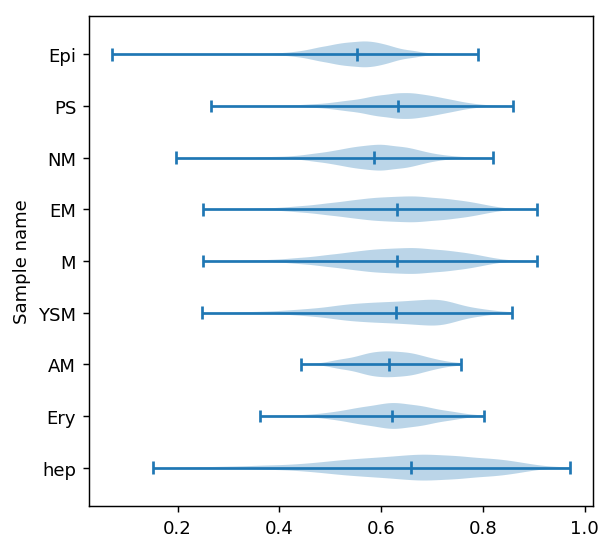

In [11]:
%get meso --from R
%get imeso --from R
%get nmeso --from R
%get ps --from R
%get ysm --from R
%get am --from R
%get ery --from R
%get epi --from R
%get hep --from R


fig, ax = plot.subplots(figsize=(5,5))
ax.violinplot([epi,ps, nmeso,imeso,meso,ysm,am,ery,hep][::-1],positions =[1,2,3,4,5,6,7,8,9],vert=False,showmeans=True)
def set_axis_style(ax, labels):
    ax.get_yaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(np.arange(1, len(labels) + 1))
    ax.set_yticklabels(labels)
    ax.set_ylim(0.25, len(labels) + 0.75)
    ax.set_ylabel('Sample name')

set_axis_style(ax,['Epi','PS','NM','EM','M','YSM','AM','Ery','hep'][::-1])


'''from scipy.stats import mannwhitneyu
from decimal import Decimal
def PlotNoise1(df_1,df_2,col,str_title,n1,n2):
    l1=len(df_1)
    l2=len(df_2)
    if l1<l2:
        tmp_df1=np.zeros(l2)
        tmp_df1[:]=np.nan
        tmp_df1[:l1]=df_1
        df_1=tmp_df1
    else:
        tmp_df2=np.zeros(l1)
        tmp_df2[:]=np.nan
        tmp_df2[:l2]=df_2
        df_2=tmp_df2
    d = {col[0]: list(df_1) , col[1]: list(df_2)}
    df = pd.DataFrame(data=d)
    pval=mannwhitneyu(df[col[0]].dropna(),df[col[1]].dropna())[1]
    #print(pval)
    ax=sns.violinplot(data=df,palette=['C0','C1'],jitter=True)
    ax.set_title(str_title+'p-value= %.2E' % Decimal(pval))
    ax.set_xticklabels([col[0],col[1]])
    ax.set_ylabel('Pairwise cell-cell distance')
    #ax.set_xticklabels([col[0],col[1]])
    return ax;
'''

#PlotNoise1(ps,epi,['Emergent meso.','Nascent meso.'],'',202,133)


In [92]:
ecl 

SS.sc7786612-1          DE(P)
SS.sc7785611-1    YS Endoderm
SS.sc7785599-1    YS Endoderm
SS.sc7785883-1          DE(P)
SS.sc7785601-1    YS Endoderm
                     ...     
SS.sc7786732-1         DE(NP)
SS.sc7786573-1    YS Endoderm
SS.sc7785486-1          DE(P)
SS.sc7785357-1    YS Endoderm
SS.sc7786714-1          DE(P)
Name: cl_id, Length: 135, dtype: category
Categories (4, object): ['DE(NP)', 'DE(P)', 'Hypoblast', 'YS Endoderm']

In [2]:
log_data2 = ad.read_csv('script_heart+gastr/norm_true_data.csv')  #load the normalized data
#log_data2= sc.pp.log1p(log_data2,copy = True)
log_data2.obs = pd.read_csv('ori_gast_umap.csv')

#log_data2 = log_data2[log_data2.obs['Sample']!='Exclude']
#log_data2.obs['leiden'] = list(high_var2.obs['leiden'])
cl0 = log_data2[log_data2.obs['cluster_id']=='Epiblast']
cl0df = cl0.to_df()
cl0df
#sc.pl.umap(high_var2,color='TGFB4')

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1     A2ML1  A2ML1-AS1  A2ML1-AS2  A2MP1  A3GALT2  ...  ZXDA  ZXDB  ZXDC   ZYG11A  ZYG11AP1    ZYG11B       ZYX  ZYXP1    ZZEF1  hsa-mir-1253
11    2.193385       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  0.000000  3.676300    0.0  0.00000           0.0
47    0.000000       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  0.000000  2.877030    0.0  0.00000           0.0
51    0.000000       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  0.000000  3.111432    0.0  0.00000           0.0
64    0.000000       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  3.122616  1.487771    0.0  0.00000           0.0
66    0.000000       0.0   0.0  0.0      0.0  2.261575        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  2.831333  3.140250    0.0  0.00000           0.0
...        ...       ...   ...  ...      ...       ...        ...        ...    ...      ...  ...   ...   ...   ...      ...       ...       ...       ...    ...      ...           ...
1150  0.000000       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.69373       0.0  3.872342  0.000000    0.0  0.69373           0.0
1153  0.000000       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  4.576629  3.778478    0.0  0.00000           0.0
1162  2.063892       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  0.000000  2.181426    0.0  0.00000           0.0
1190  0.000000       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  0.000000  2.575553    0.0  0.00000           0.0
1193  2.130417       0.0   0.0  0.0      0.0  0.000000        0.0        0.0    0.0      0.0  ...   0.0   0.0   0.0  0.00000       0.0  1.330224  0.000000    0.0  0.00000           0.0

[133 rows x 57490 columns]

In [ ]:
%get cl0df
library(RaceID)
Sys.setenv(language='EN')
sc <- SCseq(t(cl0df))
sc <- filterdata(sc,mintotal=100)
fdata <- getfdata(sc)
sc <- compdist(sc,metric="spearman")
sc <- clustexp(sc,clustnr=30)
plotsaturation(sc,disp=TRUE)
plotjaccard(sc)
sc <- clustexp(sc,cln=10,sat=FALSE)
sc <- findoutliers(sc,probthr=0.005,outlg = 8)
plotsensitivity(sc)
plotoutlierprobs(sc)
clustheatmap(sc)

#sc <- compfr(sc,knn=6)
#sc <- compumap(sc)
#plotmap(sc)


In [ ]:
plotmarkergenes(sc,c("TUBB3","PAX6",'SOX3'),logsc=TRUE,cluster_rows=FALSE)
#dg <- clustdiffgenes(sc,3,pvalue=.05)
#head(dg,50)
#plotexpmap(sc,"PRDM1",logsc=TRUE,fr=TRUE)
#write.csv(dg, file='PGC_marker.csv',sep=',')
#pgc_id<-sc@cluster$kpart
outlier<-sc@cpart


In [101]:
%get outlier --from R
sc.pp.filter_genes(cl0,min_cells=10)
pgc = []
for o in outlier:
    if o ==5:
        pgc.append('PGC')
    elif o ==11:
        pgc.append('PGC')

    else:
        pgc.append('Primitive Streak')
sc.pp.log1p(cl0)
cl0.obs['pgc']=pgc
pgc_names = list(cl0[cl0.obs['pgc']=='PGC'].obs_names)
for p in pgc_names:
    print(p[:-2].replace('.','-'))

filtered out 48493 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.
/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


SS-sc7785770
SS-sc7788284
SS-sc7786226
SS-sc7788336
SS-sc7785667
SS-sc7785910
SS-sc7786266


In [80]:
'''sc.tl.rank_genes_groups(cl0, groupby= 'pgc', method= 'wilcoxon', corr_method='benjamini-hochberg',n_genes=150)
ros_cau=pd.DataFrame(cl0.uns['rank_genes_groups']['names']).head(150)
ros_cau.to_excel('PGC_table.xlsx',sheet_name='Sheet_name1')'''
pd.read_csv('human_gastrula.csv')


Unnamed: 0  Unnamed: 0.1  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2ML1-AS1  ...  ZYG11AP1  ZYG11B    ZYX  ZYXP1  ZZEF1  hsa-mir-1253                            cluster    origin  size_factor
0              0  SS.sc7785290   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0  157.0    0.0    0.0           0.0  Hemogenic Endothelial Progenitors  Yolk Sac     0.973131
1              1  SS.sc7786612   2.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                           Endoderm   Rostral     0.677075
2              2  SS.sc7786605   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     5.0    0.0    0.0    0.0           0.0                  Advanced Mesoderm   Rostral     1.136933
3              3  SS.sc7785737   2.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0   163.0    0.0    0.0    0.0           0.0                   Primitive Streak    Caudal     0.751143
4              4  SS.sc7785398   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                        YS Mesoderm  Yolk Sac     0.817608
...          ...           ...   ...       ...   ...  ...      ...    ...        ...  ...       ...     ...    ...    ...    ...           ...                                ...       ...          ...
1190        1190  SS.sc7785965   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0    7.0    0.0    0.0           0.0                           Epiblast    Caudal     0.554371
1191        1191  SS.sc7788259   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                   Primitive Streak    Caudal     0.849631
1192        1192  SS.sc7786123   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                   Primitive Streak    Caudal     0.804777
1193        1193  SS.sc7786212   8.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     3.0    0.0    0.0    0.0           0.0                           Epiblast    Caudal     1.056203
1194        1194  SS.sc7785932   0.0       0.0   0.0  0.0      0.0    0.0        0.0  ...       0.0     0.0    0.0    0.0    0.0           0.0                   Nascent Mesoderm    Caudal     0.851783

[1195 rows x 57597 columns]

In [ ]:
plot_pgc = cl0[:,["NANOS3","SOX17",'DND1','LAMA4','DPPA5','TBXT','CDH1','CDH2']].to_df()
plot_pgc['pgc'] = pgc
plot_pgc = pd.melt(plot_pgc, id_vars='pgc')
plot_pgc.colums = ['pgc','gene','expression']
ax = sns.boxplot(x="variable", y="value", hue="pgc",
                 data=plot_pgc, palette = ["#B3C6E5","#b51d49"],fliersize=0)
ax = sns.stripplot(x="variable", y="value", hue="pgc",
                 data=plot_pgc, color = 'black' ,jitter=True,dodge=True)

handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
ax.set_ylabel('Normalised ln. expression')
ax.set_xlabel('Gene')
#lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('PGC_boxplot.pdf',bbox_extra_artists=(l,), bbox_inches='tight')

In [14]:
len('TATCTAAGACATACAGCACCTGTGCTGTAT')

30

In [ ]:
sudo python2 /Users/elmirmahammadov/Documents/heart/stats_fresh/transIndel/transIndel_build_RNA.py -i gast_all.bam -r /Users/elmirmahammadov/Documents/heart/stats_fresh/Homo_sapiens.GRCh38.dna.primary_assembly.fa -g /Users/elmirmahammadov/Documents/heart/stats_fresh/Homo_sapiens.GRCh38.99.gtf.gz -o gast.bam

In [ ]:
sc.pl.umap(high_var2,color='NKX2-2')

In [ ]:
cme= cl1.concatenate(cl0,cl2,cl6)
sc.pp.log1p(cme)
cmex = cme[:,['SOX1', 'SOX3', 'PAX6', 'TUBB3', 'ELAVL3', 'OLIG2', 'NES', 'NEUROG1', 'NEUROD1', 'NKX2-2']]
cm_df = cmex.to_df()

pseudo=list(cm.obs['dpt_pseudotime'])


In [ ]:
%get cm_df
%get pseudo

library(gam, quietly = TRUE, warn.conflicts = FALSE)
library(scran, quietly = TRUE, warn.conflicts = FALSE)

#Extract the diffusion pseudotime from Python and use it as the independent variable in a 
# Generalized Additive Model (GAM) fit 
data<-cm_df
data<-t(data)

#Create an sce object and add the diffusion pseudotime (it's a vector obtained from scanpy 
#or destiny)
sce<-SingleCellExperiment(assays = list(counts = as.matrix(data)))
sce$Pseudotime <- pseudo

#Y is the (log-norm) count matrix for the genes expressed in at least 10 cells
Y <- counts(sce)
t <- sce$Pseudotime

#Uncomment the following lines if you want to run GAM only for one gene
#vec <- c("['POU5F1-1','TFAP2A','SOX2','TDGF1','TBXT','MESP1','DLX5','CDH1','CDH2','SNAI1','GATA3','SOX3','PAX6'])
#idx<-match(vec, rownames(Y))
#d <- data.frame(z=Y[idx,], t=t)
#tmp <- gam(z ~ lo(t), data=d)
#print(summary(tmp))
#print(fitted(tmp))

#Run GAM with LOESS function for all the genes: save the p-value of parametric ANOVA 
#and the fitted expression values for each genes
gam.res <- apply(Y, 1, function(z){
    d <- data.frame(z=z, t=t)
    tmp <- gam(z ~ lo(t), data=d)
    p <- summary(tmp)[4][[1]][1,5]  #p-value parametric ANOVA
    f<-fitted(tmp)
    #p2 <- summary(tmp)[3][[1]][2,3]  #p-value non-parametric ANOVA
    c(p,f)
    #c(p1,p2)   #If we want to return both the parametric and non-parametric p-values
})
gam.fitted<-gam.res[-1,]
write.csv(gam.res,'Fig2c.csv',sep=',')

In [ ]:
#Build the table of the genes p-values

genes.table<-data.frame(genes.names=rownames(data))
genes.table$pvals<-gam.res[1,]
genes.table$FDR<-p.adjust(genes.table$pvals, method="fdr") #Adjust p-values
genes.table<-genes.table[order(genes.table$FDR),] #Order the genes according to the FDR
genes.table$genes.names <- as.character(genes.table$genes.names)

#Note that we are using a very strict threshold on FDR! Otherwise we obtain a very large number
#of genes
results.gam.tot<-genes.table[genes.table$FDR < 0.01,][c('genes.names','FDR')] #Filter the significant genes
results.gam.tot<-na.omit(results.gam.tot)
#Save the matrix of fitted values
gam.fitted<-gam.res[-1,]
genes.table<-na.omit(genes.table)
print(paste("We have"
           ,sum(genes.table$FDR < 0.05)
           ,"significant genes"))



In [ ]:
%get results.gam.tot --from R
%get gam.fitted --from R

#Names of the significant genes
results_gam=list(results_gam_tot['genes.names'])
gam_fitted=ad.AnnData(gam_fitted)
gam_fitted.obs=cme.obs
gam_fitted.var_names=cme.var_names
#gam_fitted=gam_fitted[:,results_gam]

In [ ]:
sc.pp.filter_genes(high_var, min_cells=10)
hdf = high_var.to_df()

In [ ]:

DE_genes_df = cm[:,results_gam]
DE_genes_df = DE_genes_df.to_df()


In [ ]:
%get DE_genes_df

#Robustness analysis: change the number X of the high_varX_df to compute the robustness curve for a cluster

library(dynamicTreeCut, quietly = TRUE, warn.conflicts = FALSE)
#library(WGCNA, quietly = TRUE, warn.conflicts = FALSE)
library(Rtsne, quietly = TRUE, warn.conflicts = FALSE)
library(mcclust, quietly = TRUE, warn.conflicts = FALSE)

data<-as.matrix(DE_genes_df)

# mr of repeats for bootsraping
nrRepeats = 50
percent = 70
# nr of cells left
sampleSize <- round(length(rownames(data))*percent/100)
print(sampleSize)

# function to bootstrap
# indexVector is a vector with the indices of HVG
# percent defines how many genes will be left out. The default is 50 %
# nrRepeats defines how many times you want to repeat the sampling
myBootstrap <- function(indexVector){
        idxMatrix <- matrix(rep(NA, sampleSize*nrRepeats)
                            ,nrow = nrRepeats)
        for (i in 1:nrow(idxMatrix)){
                mySample <- sample(indexVector
                                   ,size = sampleSize)
                idxMatrix[i,] <- mySample
        }
        idxMatrix
}

# indices of all HVGs
cellidx <- rownames(data)
bootstrapIdxMatrix <- myBootstrap(cellidx)

# function to calculated clusters
calculateClusters <- function(geneIndices,deepSplit){
    cor.mat<-cor(data[geneIndices,],method="spearman")
    dissim<-sqrt((1-cor.mat)/2)
    dist.mat<-as.dist(dissim)
    test.clust<-hclust(dist.mat, method="average")
    clust<-cutreeDynamic(test.clust,distM=as.matrix(dist.mat), minClusterSize=30, method="hybrid", deepSplit =deepSplit)
    
    clust
}

VarInfoVector <- matrix(rep(NA, nrRepeats * 5),ncol = 5)
colnames(VarInfoVector) <- c(0,1,2,3,4)

for(j in 0:4){
    tot.clust <- calculateClusters(cellidx,j)
#    print(max(tot.clust))
    for (i in 1:nrow(bootstrapIdxMatrix)){
#        # take indices of HVGs from the bootstrapIdxMatrix of the i-th iteration
        indices <- bootstrapIdxMatrix[i,]
        # calculate the cluster statistics with these indices and deepSplit == j
        subsample.clust <- calculateClusters(indices,j)
        if(length(duplicated(indices)[duplicated(indices) == TRUE])>0){print(ERROR)}
        #Calculate the variation of information between the twao clustering (whole dataset and subsampled data)
        VarInfoVector[i,j+1] <- vi.dist(tot.clust,subsample.clust)
    }
}

In [ ]:
%get VarInfoVector --from R
import matplotlib.pyplot as plt


#plot robustness curve and choose the value of deepSplit
plt.figure()
plt.title('minClusterSize=50')
plt.xlabel('deepSplit')
plt.ylabel(r'$\bar{VI}$ (50 bootstrap subsamples)')
plt.plot(np.arange(0,5),np.mean(VarInfoVector,axis=0),'o')
plt.show()
plt.close()

In [ ]:
%get DE_genes_df

library(dynamicTreeCut, quietly = TRUE, warn.conflicts = FALSE)
#library(WGCNA, quietly = TRUE, warn.conflicts = FALSE)
library(Rtsne, quietly = TRUE, warn.conflicts = FALSE)
library(mcclust, quietly = TRUE, warn.conflicts = FALSE)

finalClus <- function(df,deepSplit){
    data<-as.matrix(df)
    cor.mat<-cor(data,method="spearman")
    dissim<-sqrt((1-cor.mat)/2)
    dist.mat<-as.dist(dissim)
    test.clust<-hclust(dist.mat, method="average")
    clust<-cutreeDynamic(test.clust,distM=as.matrix(dist.mat), minClusterSize=50,
                         method="hybrid", deepSplit =deepSplit)
    clust
}

#Perform the actual clustering after choosing deepSplit from the robustness curve
clust<-finalClus(DE_genes_df,0)
print(max(clust))

In [ ]:
%get clust --from R
norm_data_DE_genes=cme[:,results_gam]
norm_data_DE_genes.var['cl_labels']=list(clust)
norm_data_DE_genes.var['cl_labels'].value_counts()
results_gam_tot['cl_labels']=list(clust)
df=pd.DataFrame({'1-names':list(results_gam_tot[results_gam_tot['cl_labels']==1]['genes.names']),
                '1-FDR':list(results_gam_tot[results_gam_tot['cl_labels']==1]['FDR'])})

for i in range(np.amax(clust)):
    i=i+1
    if i!=1:
        df1=pd.DataFrame({str(i)+'-names':list(results_gam_tot[results_gam_tot['cl_labels']==i]['genes.names']),
                         str(i)+'-FDR':list(results_gam_tot[results_gam_tot['cl_labels']==i]['FDR'])})
        df=pd.concat([df,df1], ignore_index=True, axis=1)
gam_fitted=gam_fitted.copy()
DE_genes_df=gam_fitted.T.to_df()

#Normalize expression of genes between 0 and 1
DE_genes_df_max = DE_genes_df.max(axis=1)
DE_genes_df=DE_genes_df.divide(DE_genes_df_max, axis=0)

#Add labels of the cluster for each gene
DE_genes_df['cl_lab']=list(clust)

#For each cluster compute the mean expression of the genes in each cell
mean_df=DE_genes_df.groupby('cl_lab').mean()
std_df=DE_genes_df.groupby('cl_lab').std()

mean_df=mean_df.append(cm.obs['dpt_pseudotime'])
std_df=std_df.append(cm.obs['dpt_pseudotime'])

new_columns = mean_df.columns[mean_df.ix[mean_df.last_valid_index()].argsort()]
mean_df=mean_df[new_columns]
std_df=std_df[new_columns]
mean_df=np.array(mean_df)
std_df=np.array(std_df)


In [ ]:
import matplotlib.pyplot as plot
import pylab

for i in range(np.amax(clust)):
    pylab.ylim(-0.1,1.1)
    plot.title('Cluster %s' % str(i+1))
    plot.xlabel('diffusion pseudotime')
    plot.ylabel('mean expression')
    plot.plot(mean_df[-1],mean_df[i])
    #plot.plot(mean_df[4],mean_df[i]+std_df[i])
    #plot.plot(mean_df[4],mean_df[i]-std_df[i])
    
    plot.fill_between(mean_df[-1], 
                      mean_df[i]-std_df[i], mean_df[i]+std_df[i],
                      alpha=0.5, edgecolor='C0', facecolor='C0')
    
    plot.show(),plot.close()

In [ ]:
%get cm_df
%get pseudo

library(gam, quietly = TRUE, warn.conflicts = FALSE)
library(scran, quietly = TRUE, warn.conflicts = FALSE)

#Extract the diffusion pseudotime from Python and use it as the independent variable in a 
# Generalized Additive Model (GAM) fit 
data<-cm_df
data<-t(data)

#Create an sce object and add the diffusion pseudotime (it's a vector obtained from scanpy 
#or destiny)
sce<-SingleCellExperiment(assays = list(counts = as.matrix(data)))
sce$Pseudotime <- pseudo

#Y is the (log-norm) count matrix for the genes expressed in at least 10 cells
Y <- counts(sce)
t <- sce$Pseudotime

#Uncomment the following lines if you want to run GAM only for one gene
#vec <- c("Spink1")
#idx<-match(vec, rownames(Y))
#d <- data.frame(z=Y[idx,], t=t)
#tmp <- gam(z ~ lo(t), data=d)
#print(summary(tmp))
#print(fitted(tmp))

#Run GAM with LOESS function for all the genes: save the p-value of parametric ANOVA 
#and the fitted expression values for each genes
gam.res <- apply(Y, 1, function(z){
    d <- data.frame(z=z, t=t)
    tmp <- gam(z ~ lo(t), data=d)
    p <- summary(tmp)[4][[1]][1,5]  #p-value parametric ANOVA
    f<-fitted(tmp)
    #p2 <- summary(tmp)[3][[1]][2,3]  #p-value non-parametric ANOVA
    c(p,f)
    #c(p1,p2)   #If we want to return both the parametric and non-parametric p-values
})

In [ ]:
#4E9C6D,Mature Mesoderm
#EF8635,Endoderm
#58BDCC,Ectoderm
#9D48F3,Hemogenic Endothelial Progenitors
#C53933,Erythrocytes
#3C76AF,Epiblast
#84584E,Axial Mesoderm
#B6BD6E,Immature Mesoderm
#D57DBF,Nascent Mesoderm
#B3C6E5,Primitive Streak
#FFBE83,YS Mesoderm



In [ ]:
import matplotlib.pyplot as plt

def plot_pgc(gene):
    import seaborn as sns
    diff_df = pd.DataFrame(cm.obsm['X_diffmap']).iloc[:,1:3]
    diff_df.index = cm.obs.index
    diff_df.reset_index(drop=True, inplace=True)
    cm_df.reset_index(drop=True, inplace=True)

    plot_cm = pd.concat([diff_df,cm_df],axis=1)
    g = sns.scatterplot(x=1,y=2,hue=gene,data=plot_cm).set_title(gene)
    plt.show()
    
    plt.close()


for p in results_gam[:22]:
    plot_pgc(p)

In [338]:
%matplotlib inline
from IPython.display import HTML
import chart_studio.plotly as py
import plotly.graph_objects as go
from  plotly.offline import plot
import plotly.io as pio
import plotly.express as px
def plot3d(color):
    cm_plot  = pd.DataFrame(seur.obsm['X_diffmap']).iloc[:,1:4]
    cm_plot['cluster']= color
    cm_plot.columns=['0','1','2','cluster']
    fig = px.scatter_3d(cm_plot, x='0', y='1', z='2',
                  color='cluster',color_discrete_sequence=['#9D48F3','#EF8635','#4E9C6D','#B3C6E5','#FFBE83','#84584E','#C53933'
                                                          ,'#B6BD6E','#3C76AF','#D57DBF','#58BDCC'])
    # xaxis.backgroundcolor is used to set background color
    fig.update_layout(scene = dict(
                        xaxis = dict(
                             backgroundcolor="rgb(200, 200, 230)",
                             gridcolor="white",
                             showbackground=False,
                             zerolinecolor="white",
                            showticklabels=False,title=""),
                        yaxis = dict(
                            backgroundcolor="rgb(230, 200,230)",
                            gridcolor="white",
                            showbackground=False,
                            zerolinecolor="white",showticklabels=False,title=""),
                        zaxis = dict(
                            backgroundcolor="rgb(230, 230,200)",
                            gridcolor="white",
                            showbackground=False,
                            zerolinecolor="white",showticklabels=False,title=""),),
                        width=1000,
                        margin=dict(
                        r=20, l=20,
                        b=20, t=20)
                      )

    pio.write_html(fig, file='gast_diffmap_integ.html', auto_open=True)
plot3d(list(seur.obs['x']))



In [ ]:
cm_plot  = pd.DataFrame(cm.obsm['X_diffmap']).iloc[:,1:4]
cm_plot = cm_plot.reset_index()
cm_df =cl4.to_df()
cm_df = cm_df.reset_index()
cm_plot = pd.concat([cm_plot,cm_df],axis=1)
cm_plot.columns = ['index','1','2','3','index'] + list(cl4.var_names)
cm_plot.to_csv('plot_endo.csv')

In [ ]:
scv.read_loom('mouse.loom')

In [ ]:
%get data --from R

from tqdm import tqdm
from tqdm import trange
from pyitlib import discrete_random_variable as drv
high_var = ad.AnnData(data).T 

sc.pp.log1p(high_var)
high_var.var_names_make_unique()#ss

sc.pp.highly_variable_genes(high_var)  #calculate highly variable genes
high_var = high_var[:,high_var.var['highly_variable']]  #select only highly variable genes
sc.pp.scale(high_var, max_value=1)  

high_var = sc.tl.pca(high_var, svd_solver = 'arpack', n_comps = 50,copy=True)
sc.pp.neighbors(high_var, n_pcs=30, n_neighbors=30, method = 'umap')


def robustness(kn):
        rsln = [0.5,0.75,1,1.5,2,2.5]
        var_inf = []

        for j in tqdm(rsln):
                for i in trange(100):

                        rand_ind = np.random.randint(0, high_var.X.shape[1], size=round(len(high_var.var)*0.70-1))
                        subsampled = high_var[:, rand_ind]
                        subsampled = sc.tl.pca(subsampled, svd_solver = 'arpack',copy = True)
                        sc.pp.neighbors(subsampled, n_pcs = 5, n_neighbors=kn, method = 'umap')
                        sc.tl.leiden(subsampled, resolution = j, n_iterations=-1)
                        sc.tl.leiden(high_var, resolution = j, n_iterations=-1)

                        var_inf.append(drv.information_variation(np.array(list(high_var.obs['leiden']),dtype =float)
                                                                 ,np.array(list(subsampled.obs['leiden']),dtype = float)))
        return var_inf

k5 = robustness(5)        
k7 = robustness(20)        
k10 = robustness(10)    
k15 = robustness(15)    






In [ ]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd

#k15m = [np.mean(i) for i in np.array_split(k15,6)]
k20m = [np.mean(i) for i in np.array_split(k20,6)]
k25m = [np.mean(i) for i in np.array_split(k25,6)]

k30m = [np.mean(i) for i in np.array_split(k30,6)]
k35m = [np.mean(i) for i in np.array_split(k35,6)]
k40m = [np.mean(i) for i in np.array_split(k40,6)]
k45m = [np.mean(i) for i in np.array_split(k45,6)]
k50m = [np.mean(i) for i in np.array_split(k50,6)]
k55m = [np.mean(i) for i in np.array_split(k55,6)]
k65m = [np.mean(i) for i in np.array_split(k65,6)]
k75m = [np.mean(i) for i in np.array_split(k75,6)]


kdf = pd.DataFrame({ 'k20':k20m,'k25':k25m,'k30':k30m,
                    'k35':k35m, 'k40':k40m,'k45':k45m,'k50':k50m,'k55':k55m,'k65':k65m,'k75':k75m})
kdf.index = ['r0.5','r0.75','r1.0','r1.5','r2.0','r2.5']

kdf.plot()
ax = plot.gca()
#ax.set_xticklabels(['k15','k20','k25', 'k30', 'k35', 'k40','k45','k50','k55']) 
ax.set_xticklabels(['r0.5','r0.5','r0.75','r1.0','r1.5','r2.0','r2.5'])
#ax.legend(bbox_to_anchor=(0, 1), loc='right', ncol=1)
ax.set_ylabel('Variation of information')
ax.set_xlabel('resolution')


In [ ]:
kdf.T['r1.0'].plot()
ax = plot.gca()
ax.set_xticks(range(11))
ax.set_xticklabels(labels = ['k20','k25', 'k30', 'k35', 'k40','k45','k50','k55','k65','k75']) 
ax.set_ylabel('Variation of information')


In [ ]:
%get datan --from R
high_var = ad.AnnData(datan).T 
sc.pp.log1p(high_var)
#sc.pp.log1p(high_var)
import scipy
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));

high_var.var_names_make_unique()

sc.pp.highly_variable_genes(high_var, max_mean=10)  #calculate highly variable genes

high_var = high_var[:,high_var.var['highly_variable']]  

high_var_df = high_var.to_df()
#high_var_df = high_var_df.fillna(0)

In [ ]:
%get high_var_df

library(dynamicTreeCut, quietly = TRUE, warn.conflicts = FALSE)
#library(WGCNA, quietly = TRUE, warn.conflicts = FALSE)
library(Rtsne, quietly = TRUE, warn.conflicts = FALSE)
library(mcclust, quietly = TRUE, warn.conflicts = FALSE)

data<-as.matrix(t(high_var_df))

# mr of repeats for bootsraping
nrRepeats = 50
# percent of gHVGs to leave out
percent = 50
# nr of HVGs left
sampleSize <- round(length(rownames(data))*percent/100)
print(sampleSize)

# function to bootstrap
# indexVector is a vector with the indices of HVG
# percent defines how many genes will be left out. The default is 50 %
# nrRepeats defines how many times you want to repeat the sampling
myBootstrap <- function(indexVector){
        idxMatrix <- matrix(rep(NA, sampleSize*nrRepeats)
                            ,nrow = nrRepeats)
        for (i in 1:nrow(idxMatrix)){
                mySample <- sample(indexVector
                                   ,size = sampleSize)
                idxMatrix[i,] <- mySample
        }
        idxMatrix
}

# indices of all HVGs
HVGidx <- rownames(data)
bootstrapIdxMatrix <- myBootstrap(HVGidx)

# function to calculated clusters
calculateClusters <- function(geneIndices,deepSplit){
    cor.mat<-cor(data[geneIndices,],method="spearman")
    dissim<-sqrt((1-cor.mat)/2)
    dist.mat<-as.dist(dissim)
    test.clust<-hclust(dist.mat, method="average")
    clust<-cutreeDynamic(test.clust,distM=as.matrix(dist.mat), minClusterSize=3, method="hybrid", deepSplit =deepSplit)
    
    clust
}

VarInfoVector <- matrix(rep(NA, nrRepeats * 5),ncol = 5)
colnames(VarInfoVector) <- c(0,1,2,3,4)

for(j in 0:4){
    tot.clust <- calculateClusters(HVGidx,j)
#    print(max(tot.clust))
    for (i in 1:nrow(bootstrapIdxMatrix)){
        # take indices of HVGs from the bootstrapIdxMatrix of the i-th iteration
        indices <- bootstrapIdxMatrix[i,]
        # calculate the cluster statistics with these indices and deepSplit == j
        subsample.clust <- calculateClusters(indices,j)
        if(length(duplicated(indices)[duplicated(indices) == TRUE])>0){print(ERROR)}
        #Calculate the variation of information between the two clustering (whole dataset and subsampled data)
        VarInfoVector[i,j+1] <- vi.dist(tot.clust,subsample.clust)
    }
}

In [ ]:
%get VarInfoVector --from R

mcs3 = VarInfoVectora
plot.figure()
#plot.title('minClusterSize=10')
plot.xlabel('deepSplit')
plot.ylabel(r'$\bar{VI}$ (50 bootstrap subsamples)')
plot.plot(np.arange(0,5),np.mean(mcs2,axis=0),'o',color='b')
plot.plot(np.arange(0,5),np.mean(mcs3,axis=0),'o',color='magenta')

plot.plot(np.arange(0,5),np.mean(mcs4,axis=0),'o',color='r')
plot.plot(np.arange(0,5),np.mean(mcs6,axis=0),'o',color='g')
plot.plot(np.arange(0,5),np.mean(mcs8,axis=0),'o',color='pink')
plot.plot(np.arange(0,5),np.mean(mcs10,axis=0),'o',color='yellow')

plot.legend(['mcs = 2','mcs = 3','mcs = 4','mcs =6','mcs =8','mcs =10'])
plot.show()
plot.close()

In [ ]:
%get high_var_df

library(dynamicTreeCut, quietly = TRUE, warn.conflicts = FALSE)
library(Rtsne, quietly = TRUE, warn.conflicts = FALSE)
library(mcclust, quietly = TRUE, warn.conflicts = FALSE)

data<-as.matrix(t(high_var_df))


cor.mat<-cor(data,method="spearman")
dissim<-sqrt((1-cor.mat)/2)
dist.mat<-as.dist(dissim)
test.clust<-hclust(dist.mat, method="average")
clust<-cutreeDynamic(test.clust,distM=as.matrix(dist.mat), minClusterSize=2, method="hybrid", deepSplit =2)

dist.mat <- as.matrix(dist.mat)
#clust <- calculateClusters(HVGidx,4)

In [ ]:
%get clust --from R
%get dist.mat --from R
high_var.obs['leiden']=list(clust.astype(str))

#opdat.obs['leiden']=high_var.obs['leiden']
import umap
embedding = umap.UMAP(n_neighbors=5,
min_dist=0.1,random_state=0,
metric='precomputed').fit_transform(dist_mat)
high_var.obsm['X_umap']=embedding

sc.pl.umap(high_var, color = 'leiden')


In [ ]:
high_var=high_var[high_var.obs['leiden']!='0',:]
mg = high_var[:,~high_var.var_names.str.startswith('MT')]
sc.tl.rank_genes_groups(mg, 'leiden',method= 'wilcoxon', corr_method='bonferroni')
marker_genes = pd.DataFrame(mg.uns['rank_genes_groups']['names']).head(70)
sc.pl.rank_genes_groups_heatmap(mg, n_genes=10,groupby='leiden')


#Mouse Comparison

In [ ]:
mouse = sc.read_10x_mtx('atlas/')
meta = pd.read_csv('atlas/meta.tab', sep='\t')
mouse.obs = meta


In [ ]:
#set(list(meta['celltype']))
msdf = mouse.to_df()
msdf['cell_type']=list(mouse.obs['celltype'])
med_mouse = msdf.groupby('cell_type').median()
#msdf = msdf.drop('cell_type')
med_mo = ad.AnnData(med_mouse)
sc.pp.log1p(med_mo)''

In [ ]:
#hemo = mouse_atlas[mouse_atlas.obs['celltype']=='Primitive Streak']
#hmdf = hemo.to_df()
mes = mouse_atlas[mouse_atlas.obs['celltype']=='Surface ectoderm']
emeso = mouse_atlas[mouse_atlas.obs['celltype']=='ExE mesoderm']
mess = mouse_atlas[list(emeso.obs_names)+list(mes.obs_names)]
#sc.pp.filter_cells(mes, min_counts=1)a
#sc.pp.filter_genes(mes, min_cells=10)
sc.pp.log1p(mess)
sc.tl.rank_genes_groups(mess,groupby='celltype',method='wilcoxon',n_genes=300)
#emeso= emeso.to_df()

In [ ]:
%get msdf 
library(dplyr, quietly = TRUE, warn.conflicts = FALSE)
library(scran, quietly = TRUE, warn.conflicts = FALSE)
data<-msdf #get good cells from python kernel
#data<-select(data, -cells)
data<- data[, -grep("ERCC", colnames(data))]
sce<-SingleCellExperiment(assays = list(counts = t(as.matrix(data))))
clusters <- quickCluster(sce)
sce<-computeSumFactors(sce, cluster=clusters)
sce<-normalize(sce,return_log=FALSE)
data<-data.frame(as.matrix(normcounts(sce)))

write.csv(data, file = 'mouse_norm.csv')




In [ ]:
%get emeso --from R
#hem_norm = ad.read_csv('mouse_PS.csv')
#hem_norm.obs = hemo.obs
#hmdf.to_csv('mouse_PS.csv')
exmeso = ad.AnnData(emeso).T
#exmeso.obs=emeso.obs

In [ ]:
exmeso = exmeso[exmeso.obs['stage']!='mixed_gastrulation',:]
exmeso = exmeso[exmeso.obs['stage']!='E6.75',:]
#hem_norm = hem_norm[hem_norm.obs['stage']=='E7.5',:]

#exmeso.obs=emeso.obs

In [ ]:
import bbknn
sc.pp.log1p(exmeso)
#sc.pp.highly_variable_genes(hem_norm,max_mean=10)
hem = exmeso.copy()
sc.tl.pca(hem,svd_solver='arpack')
sc.pp.neighbors(hem, n_neighbors=30)
sc.tl.umap(hem)
sc.pl.umap(hem,color='stage')



In [ ]:
#sc.tl.rank_genes_groups(hem_norm,groupby='stage',method='wilcoxon',corr_method = 'bonferroni',n_genes=100,rankby_abs=True)
sc.pl.rank_genes_groups_matrixplot(mess,groupby='celltype')

In [ ]:
eghj = mess.uns['rank_genes_groups']['names'].tolist()
ghj = list(set([item for sublist in ghj for item in sublist]))
#ghj.index('T')
#sc.pl.umap(hem,color='T')
with open('mouse_genes.txt', 'r') as f:
    x = f.read().splitlines()
ghj = []
for e in eghj:
    ghj.append(e[0])
ghj

In [ ]:
%get humnames
convertMouseGeneList <- function(x){
 
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
 
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <-genesV2[, 2]
mousex <-genesV2[, 1]
# Print the first 6 genes found to the screen
print(head(humanx))
return(list(v1=humanx,v2=mousex))

}
hmg<-convertMouseGeneList(humnames)

In [ ]:
humnames = list(mouse.var_names)

In [ ]:
sc.pl.matrixplot(log_data2, var_names=hgenes,groupby='cluster_id')

In [ ]:
%get hmg --from R
hgenes = hmg['v1']
mgenes = hmg['v2']

In [ ]:
log_data2.obs['Sample_mod'] = list(high_var2.obs['Sample_mod'])
log_data2.obs['cluster_id'] = list(high_var2.obs['cluster_id'])

mixm = log_data2[log_data2.obs['cluster_id']=='ExE Mesoderm']

def get_rid(vnames,hg,mg):
    m = set(hgenes).difference(set(vnames))
    for j in m:
        
        p = hgenes.index(j)
        hg.remove(j)
        mg.remove(mg[p])
    return [hg,mg]
hgenes = get_rid(list(log_data2.var_names),hgenes,mgenes)[0]
mgenes = get_rid(list(log_data2.var_names),hgenes,mgenes)[1]

In [ ]:
p = hgenes.index('DEFB104B')
hgenes.remove('DEFB104B')
mgenes.remove(mgenes[p])
log_data2 = ad.read_csv('normf_data.csv').T    #load the normalized data
human = log_data2[:,hgenes]
mouse_mo = mouse[:,mgenes]

#mouse

In [ ]:
scipy.stats.spearmanr(blood.X,mouse_mo[mouse_mo.obs['cell_type']=='Erythroid1'].X,axis=1)[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr_list = []
blood = human[human.obs['cluster_id']=='Mesoderm']
#bl = blood[:,hgenes]
for i in list(set(list(mouse_mo.obs['cell_type']))):
    cor = []
    j = len(human[human.obs['cluster_id']==str(i)].X)
    #sns.clustermap(pairwise_distances(human.X,mouse[mouse.obs['stage']==str(i)].X,metric='correlation'),row_cluster=True,col_cluster=False)
    for p in range(len(blood.X)):
        corr = scipy.stats.spearmanr(mouse_mo[mouse_mo.obs['cell_type']==str(i)].X,blood.X[p],axis=1)
        rho, pval = corr
        cor.append(rho)
    corr_list.append(cor)

corr_df = pd.DataFrame(corr_list)
corr_df.index =list(set(list(mouse_mo.obs['cell_type'])))
corr_df = corr_df.sort_index()

ax = sns.boxplot(data = corr_df.T )
plt.setp(ax.get_xticklabels(), rotation=90)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr_list = []
#blood = log_data2[log_data2.obs['cluster_id']=='Hemangioblast']
#bl = blood[:,hgenes]
for i in list(set(list(human.obs['cluster_id']))):
    cor = []
    j = len(human[human.obs['cluster_id']==str(i)].X)
    #sns.clustermap(pairwise_distances(human.X,mouse[mouse.obs['stage']==str(i)].X,metric='correlation'),row_cluster=True,col_cluster=False)
    for p in range(j):
        corr = scipy.stats.pearsonr(human[human.obs['cluster_id']==str(i)].X[p],np.mean(mouse.X,axis=0))
        rho, pval = corr
        cor.append(rho)
    corr_list.append(cor)

corr_df = pd.DataFrame(corr_list)
corr_df.index =list(set(list(log_data2.obs['cluster_id'])))
corr_df = corr_df.sort_index()

ax = sns.boxplot(data = corr_df.T)
plt.setp(ax.get_xticklabels(), rotation=90)


In [117]:
#log_data2[log_data2.obs['cluster_id']=='Hemangioblast'].to_df().to_csv('heman.csv')
pd.read_csv()

Run lane   Sample Cell# Stage       Plate  ... leiden  louvain                           clust_id                         cluster_id                          high_var2
SS.sc7785290-1  SS.sc7785290   Group3     1   CS6  SCGC--3857  ...      5        3  Hemogenic Endothelial Progenitors  Hemogenic Endothelial Progenitors  Hemogenic Endothelial Progenitors
SS.sc7786612-1  SS.sc7786612   Group1     1   CS6  SCGC--2860  ...      3        4                           Endoderm                           Endoderm                              DE(P)
SS.sc7786605-1  SS.sc7786605   Group1     1   CS6  SCGC--2860  ...      2        2                  Advanced Mesoderm                  Advanced Mesoderm                  Advanced Mesoderm
SS.sc7785737-1  SS.sc7785737  Group2      1   CS6  SCGC--3861  ...      0        1                   Primitive Streak                   Primitive Streak                   Primitive Streak
SS.sc7785398-1  SS.sc7785398   Group3     1   CS6  SCGC--3857  ...      7        6                        YS Mesoderm                        YS Mesoderm                        YS Mesoderm
...                      ...      ...   ...   ...         ...  ...    ...      ...                                ...                                ...                                ...
SS.sc7785965-1  SS.sc7785965  Group2      1   CS6  SCGC--3861  ...      4        5                           Epiblast                           Epiblast                           Epiblast
SS.sc7788259-1  SS.sc7788259  Group2      1   CS6  SCGC--3858  ...      0        1                   Primitive Streak                   Primitive Streak                   Primitive Streak
SS.sc7786123-1  SS.sc7786123   Group2     1   CS6  SCGC--3859  ...      0        1                   Primitive Streak                   Primitive Streak                   Primitive Streak
SS.sc7786212-1  SS.sc7786212   Group2     1   CS6  SCGC--3859  ...      4        5                           Epiblast                           Epiblast                           Epiblast
SS.sc7785932-1  SS.sc7785932  Group2      1   CS6  SCGC--3861  ...      6        0                   Nascent Mesoderm                   Nascent Mesoderm                   Nascent Mesoderm

[1195 rows x 16 columns]

In [127]:
high_var2.obs.to_csv('final_meta.csv',sep=',')

In [122]:
endo_sub=list(ecl)
hep_sub = list(hcl)
#pgc_sub = list(cl0.obs['pgc'])
sub =[]
for c in high_var2.obs_names:
    if c in list(cm.obs_names):
        sub.append(cm.obs.loc[c]['cl_id'])
    elif c in list(heman.obs_names):
        sub.append(heman.obs.loc[c]['cl_id'])
    elif c in list(cl0.obs_names):
        sub.append(cl0.obs.loc[c]['pgc'])
    else:
        sub.append(high_var2[c,:].obs['clust_id'].values[0])
sub


/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


['Blood Progenitors',
 'DE(P)',
 'Advanced Mesoderm',
 'Primitive Streak',
 'YS Mesoderm',
 'Axial Mesoderm',
 'Erythrocytes',
 'Advanced Mesoderm',
 'YS Endoderm',
 'Emergent Mesoderm',
 'YS Mesoderm',
 'Epiblast',
 'Primitive Streak',
 'YS Mesoderm',
 'Advanced Mesoderm',
 'Primitive Streak',
 'YS Endoderm',
 'Emergent Mesoderm',
 'Nascent Mesoderm',
 'Emergent Mesoderm',
 'Emergent Mesoderm',
 'Hemogenic Endothelium',
 'Nascent Mesoderm',
 'Primitive Streak',
 'Primitive Streak',
 'Emergent Mesoderm',
 'Primitive Streak',
 'Advanced Mesoderm',
 'Advanced Mesoderm',
 'YS Mesoderm',
 'Primitive Streak',
 'Ectoderm',
 'Nascent Mesoderm',
 'Advanced Mesoderm',
 'Hemogenic Endothelium',
 'Emergent Mesoderm',
 'DE(P)',
 'YS Endoderm',
 'Hemogenic Endothelium',
 'DE(P)',
 'Emergent Mesoderm',
 'Emergent Mesoderm',
 'Primitive Streak',
 'Blood Progenitors',
 'YS Mesoderm',
 'Primitive Streak',
 'Primitive Streak',
 'Epiblast',
 'Hypoblast',
 'DE(P)',
 'Nascent Mesoderm',
 'Epiblast',
 'Prim

In [219]:
with open('Genes/Ygenes.txt', 'r') as f:
    x = f.readlines()
y = []
for x in x:
    y.append(x[:-1])
y= y[1:]

yexpr = []
xexpr = []              
for l in list(log_data2.obs_names):
    b = log_data2[:,list(set(y).intersection(set(list(log_data2.var_names))))]
    yexpr.append(np.sum(b[l].X).tolist())
log_data2.obs['sub_cl']=sub
log_data2=log_data2


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
script_1595074302069593244 in <module>
      lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.6,1.1))
      sns.despine()
----> plot.savefig('blood_umap.pdf',bbox_extra_artists=(l,), bbox_inches='tight',ax=ax)

AttributeError: 'str' object has no attribute 'get_tightbbox'


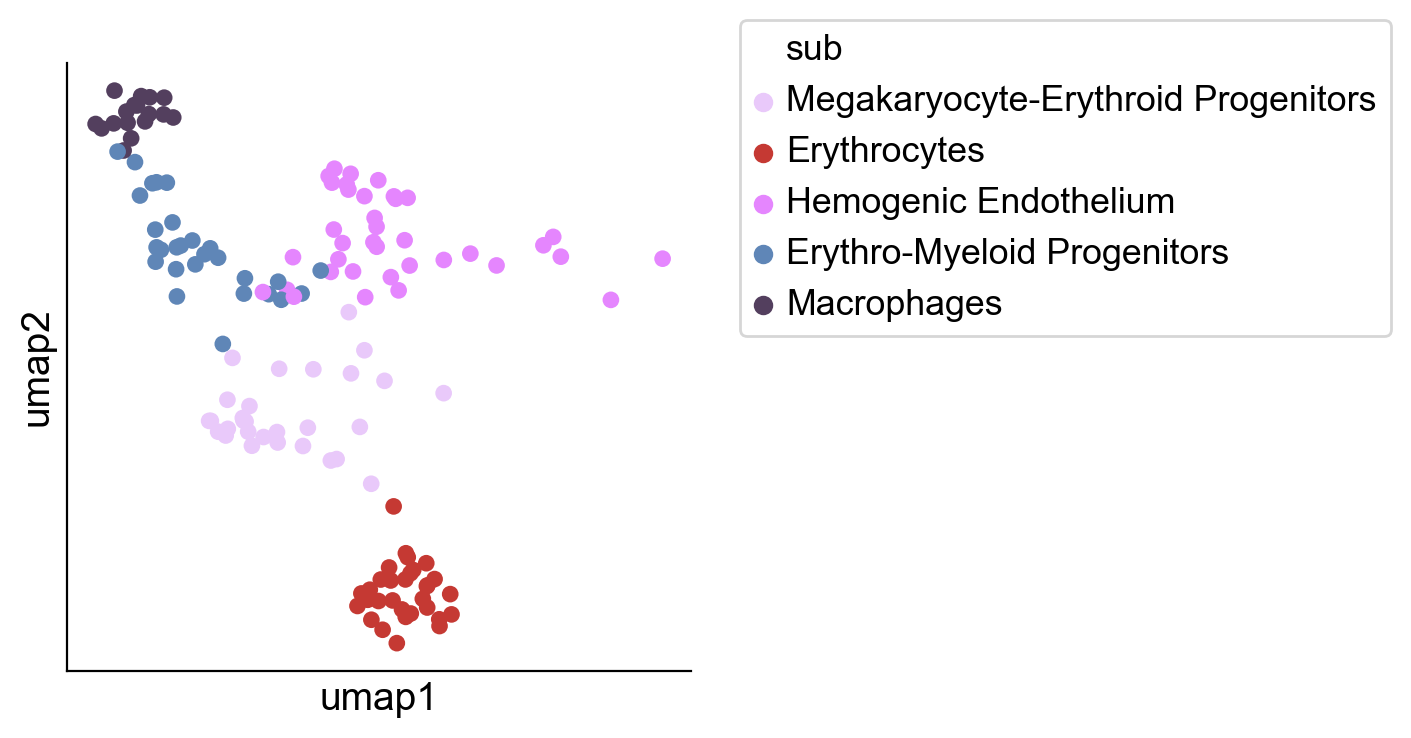

In [208]:
plot_pgc = log_data2[:,"XIST"].to_df()
plot_pgc['Ygenes'] = yexpr
plot_pgc['sub'] = sub
plot_pgc['umap1'] = high_var2.obsm['X_umap'][:,0]
plot_pgc['umap2'] = high_var2.obsm['X_umap'][:,1]

plot_pgc = plot_pgc[plot_pgc['sub'].isin(['Erythrocytes','Hemogenic Endothelium','Macrophages',
                                         'Megakaryocyte-Erythroid Progenitors','Erythro-Myeloid Progenitors'])]
#plot_pgc = pd.melt(plot_pgc, id_vars='sub')
#plot_pgc.colums = ['sub','gene','expression']
'''plot_pgc['sub'].cat.remove_categories(['Axial Mesoderm', 'Ectoderm', 'Endoderm', 'Epiblast','Immature Mesoderm',
       'Mature Mesoderm', 'Nascent Mesoderm', 'Primitive Streak',
       'YS Mesoderm'],inplace=True)
'''
ax =sns.scatterplot(x='umap1',y='umap2',hue='sub',edgecolors=None,linewidth=0,data=plot_pgc,palette=["#e9c9fa","#C53933", "#e586fe",  "#5f86b7","#533f5e"])
ax.grid(False)

# Turns off grid on the secondary (right) Axis.
ax.set_yticks([]) 
ax.set_xticks([]) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.6,1.1))
sns.despine()
plot.savefig('blood_umap.pdf',bbox_extra_artists=(l,), bbox_inches='tight',ax=ax)


In [561]:
with open('Genes/hem_genes.txt', 'r') as f:
    x = f.readlines()
y = []
for x in x:
    y.append(x[:-1])
plot_pgc = log_data2.to_df()
plot_pgc['sub'] =list(log_data2.obs['sub_cl'])

plot_he = plot_pgc[plot_pgc['sub'].isin(['Erythrocytes','Megakaryocyte-Erythroid Progenitors','Hemogenic Endothelium','Macrophages',
                                         'Erythro-Myeloid Progenitors'])]
plot_pgc = plot_he.loc[:,y]
plot_pgc['sub'] = plot_he['sub']
plot_pgc = plot_pgc.sort_values(by='sub')
plot_pgc.cat.reorder_categories(['Erythrocytes','Megakaryocyte-Erythroid Progenitors','Hemogenic Endothelium','Macrophages',
                                         'Erythro-Myeloid Progenitors'])
sub = plot_pgc['sub']
plot_pgc.drop(labels = 'sub',axis=1,inplace=True)

lut = dict(zip(sub.unique(), [ "#5f86b7","#C53933", "#e586fe","#533f5e","#e9c9fa"]))
row_colors = list(sub.map(lut))

#g = sns.clustermap(plot_pgc,row_cluster=False,yticklabels=False,row_colors=row_colors,figsize=(35,35),method='average',metric='correlation',cmap='Reds',standard_scale=1)
sns.heatmap(plot_pgc)



---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
script_7407683295847728429 in <module>
          y.append(x[:-1])
      plot_pgc = log_data2.to_df()
----> plot_pgc['sub'] =list(log_data2.obs['sub_cl'])
      
      plot_he = plot_pgc[plot_pgc['sub'].isin(['Erythrocytes','Megakaryocyte-Erythroid Progenitors','Hemogenic Endothelium','Macrophages',
                                               'Erythro-Myeloid Progenitors'])]

KeyError: sub_cl


In [ ]:
plb = log_data2[log_data2.obs['sub_cl'].isin(['Erythrocytes','Megakaryocyte-Erythroid Progenitors','Hemogenic Endothelium','Macrophages',
                                         'Erythro-Myeloid Progenitors'])]
plb.obs['sub_cl'].cat.reorder_categories(['Erythrocytes','Megakaryocyte-Erythroid Progenitors','Hemogenic Endothelium','Macrophages',
                                         'Erythro-Myeloid Progenitors'],inplace=True)
plb.uns['sub_cl_colors']=[ "#C53933","#e9c9fa", "#e586fe","#533f5e","#5f86b7"]
sc.pl.heatmap(plb,var_names=y,groupby='sub_cl',standard_scale='var',cmap='Reds',save='Fig4d_heatmap.pdf')


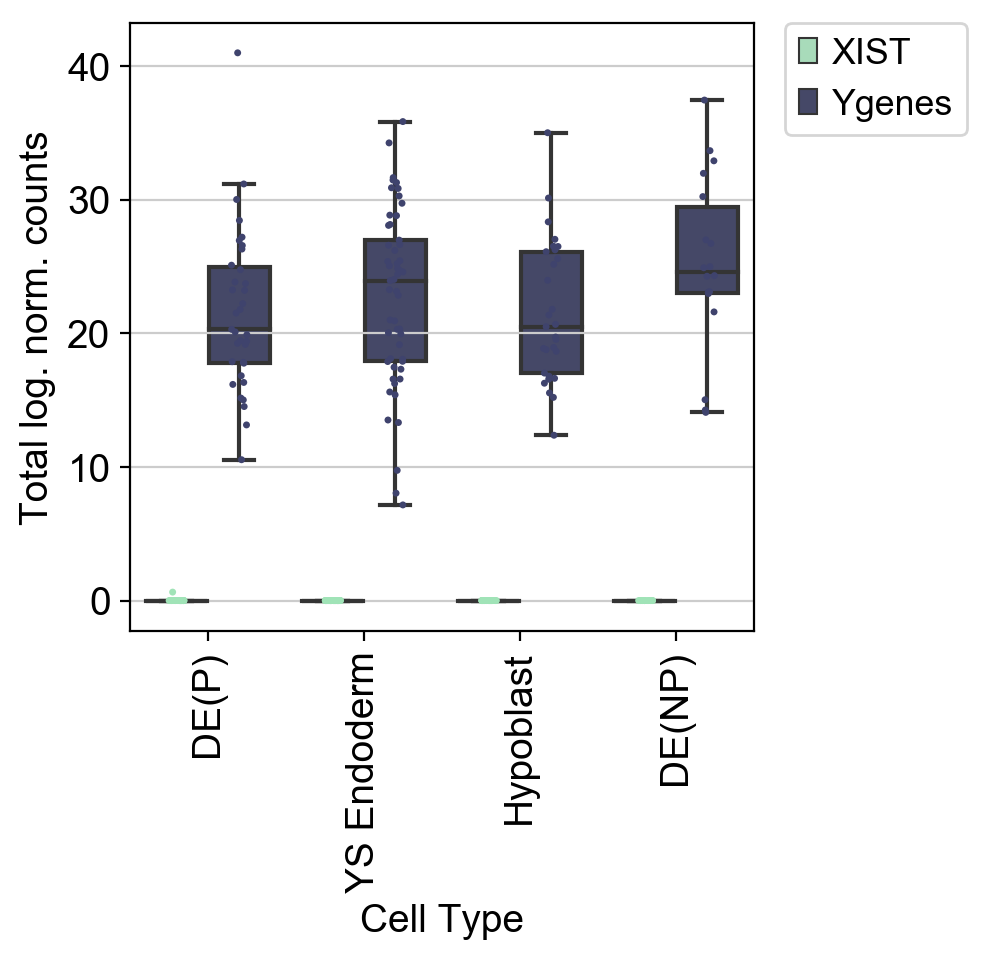

In [223]:
plot_pgc = log_data2[:,"XIST"].to_df()
plot_pgc['Ygenes'] = yexpr
plot_pgc['sub'] = sub
plot_pgc = pd.melt(plot_pgc, id_vars='sub')
plot_pgc.colums = ['sub','gene','expression']
plot_pgc = plot_pgc[plot_pgc['sub'].isin(['Hypoblast','YS Endoderm','DE(NP)','DE(P)'])]

ax = sns.boxplot(x="sub", y="value", hue="variable",
                 data=plot_pgc, palette = ["#a0e3b7", "#3f436d"],fliersize=0)
ax = sns.stripplot(x="sub", y="value", hue="variable",
                   data=plot_pgc,palette = ["#a0e3b7", "#3f436d"],jitter=True,dodge=True,size=2.5)

handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
ax.set_ylabel('Total log. norm. counts')
ax.set_xlabel('Cell Type')
plot.xticks(rotation=90)
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))
l = plot.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plot.savefig('XIST_boxplot_endo.pdf',bbox_extra_artists=(l,), bbox_inches='tight')

In [ ]:
%get hclust --from R
heman.obs['subcluster']= hclust
heman.obs

In [ ]:
import itertools

stuff = list(set(list(exmeso.obs['stage'])))
combs = []
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        combs.append(subset)
combs = combs[8:]
diff_genes = []
for g in combs:
    if len(g)==2:
        sc.tl.rank_genes_groups(exmeso,groupby='stage',groups=g, reference = g[0])
        diff_genes.append(list(exmeso.uns['rank_genes_groups']['names']))
diff_genes

In [ ]:
mouse = sc.read_10x_mtx('atlas/')
meta = pd.read_csv('atlas/meta.tab', sep='\t')
mouse.obs = meta
humnames = list(mouse.var_names)

In [ ]:
with open('Genes/bert_genes.txt', 'r') as f:
    x = f.read().splitlines()
humnames = list(set(x))

In [ ]:
humnames = list(mouse.var_names)

In [ ]:
%get humnames
convertMouseGeneList <- function(x){
 
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
 
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <-genesV2[, 2]
mousex <-genesV2[, 1]
# Print the first 6 genes found to the screen
print(head(humanx))
return(list(v1=humanx,v2=mousex))

}
hmg<-convertMouseGeneList(humnames)

In [ ]:
%get hmg --from R
hgenes = hmg['v1']
mgenes = hmg['v2']
hmg = pd.DataFrame(hmg)
hmg = hmg.drop_duplicates(subset='v1',keep='first')
hmg = hmg.drop_duplicates(subset='v2',keep='first')
hmg = hmg[hmg['v1'].isin(log_data2.var_names)]


In [ ]:
hgenes = hmg['v1']
mgenes = hmg['v2']
log_data2.obs['cluster_id']=high_var2.obs['clust_id']
log_data2.obs['sub']=sub

human = log_data2[:,hgenes]
mouse_mo = mouse[:,mgenes]
mouse_mo

In [ ]:

sc.pp.normalize_total(mouse_mo)

#mouse_mo.obs['typ_st']=list(mouse_mo.obs['stage']+' ' +mouse_mo.obs['celltype'])

m6 = mouse_mo[mouse_mo.obs['stage']=='E7.25']

#m6 = mouse_mo[mouse_mo.obs['stage']=='E7.25']

#m6 = mouse_mo[mouse_mo.obs['stage']=='E7.0']

#m6 = m75.concatenate(m72,m70) 

In [ ]:
#hum.obs['cluster_id']=list(high_var2.obs['cluster_id'])
#sc.pp.log1p(m6)

msdf = m6.to_df()
msdf['typ_st']=list(m6.obs['celltype'])
med_mouse = msdf.groupby('typ_st').median()
#msdf = msdf.drop('cell_type')
m7 = ad.AnnData(med_mouse)
#sc.pp.log1p(m7)
m7.obs

In [ ]:
#mouse.obs=mouse_atlas.obs
#sc.pp.log1p(m6)
#sc.pp.highly_variable(m6)
#mouse_mo = m6[:, m6.var['highly_variable']==True]
#m6 =m6[m6.obs.index!='Rostral neurectoderm']
m7.var_names_make_unique()
annot = list(m7.obs.index)
exmdf = m7.to_df()
human.var_names= list(m7.var_names)
#sc.pp.log1p(human)
lgdf = human[human.obs['cluster_id']=='Hemogenic Endothelial Progenitors']
#lgdf = lgdf[:,hgenes]
#lgdf.var_names = list(mouse_mo.var_names)
lgdf.var_names_make_unique()
lgdf = lgdf.to_df()


In [ ]:
%get exmdf
%get annot
#annn<-as.data.frame(annot)
#row.names(annn)<-rownames(exmdf)
library(SingleCellExperiment)
library(scmap)
#data<-sample_n(t(exmdf), 5000)
sce<-SingleCellExperiment(assays = list(normcounts = t(as.matrix(exmdf))), colData = annot)
logcounts(sce) <- log2(normcounts(sce) + 1)
# use gene names as feature symbols
rowData(sce)$feature_symbol <- rownames(sce)
isSpike(sce, "ERCC") <- grepl("^ERCC-", rownames(sce))
sce <- sce[!duplicated(rownames(sce)), ]


In [ ]:
%get lgdf
#%get ct
sce_pro <- SingleCellExperiment(assays = list(logcounts = t(as.matrix(lgdf))))
sce <- selectFeatures(sce, suppress_plot = TRUE,n_features=4000)

#logcounts(sce_pro) <- log2(normcounts(sce_pro) + 1)

colData(sce)$cell_type <- annot
rowData(sce)$feature_symbol <- rownames(sce)
rowData(sce_pro)$feature_symbol <- rownames(sce_pro)
sce <- indexCluster(sce,cluster_col='cell_type')
scmapCluster_results <- scmapCluster(
  projection = sce_pro, 
  index_list = list(
    yan = metadata(sce)$scmap_cluster_index
  ), threshold = 0
)
map_results<-scmapCluster_results$scmap_cluster_labs
barplot(prop.table(table(as.data.frame(map_results)$yan)),las=2.0, cex.names=0.4)
hep = map_results

In [ ]:
#epi, ps,ecto,nm,im,mm,ysm,endo,noto,ery,hep
'''erydf = as.data.frame(prop.table(table(as.data.frame(ysen)$yan)))
epidf = as.data.frame(prop.table(table(as.data.frame(denp)$yan)))
notodf = as.data.frame(prop.table(table(as.data.frame(dep)$yan)))
psdf = as.data.frame(prop.table(table(as.data.frame(hypo)$yan)))
merged<-Reduce(function(x,y) merge(x,y,by="Var1",all=TRUE) ,list(erydf,epidf,notodf,psdf))

colnames(merged)<-c('mouse_type','Erythro-Myeloid Progenitors','End. Prog.','Macrophage','Megakaryocyte-Erythroid Progenitors')
merged[is.na(merged)]<-0
rownames(merged) <-merged$mouse_type
merged$mouse_type<-NULL
               '''

In [ ]:
erydf = as.data.frame(prop.table(table(as.data.frame(ery)$yan)))
epidf = as.data.frame(prop.table(table(as.data.frame(epi)$yan)))
notodf = as.data.frame(prop.table(table(as.data.frame(noto)$yan)))
psdf = as.data.frame(prop.table(table(as.data.frame(ps)$yan)))
endodf = as.data.frame(prop.table(table(as.data.frame(endo)$yan)))
nmdf = as.data.frame(prop.table(table(as.data.frame(nm)$yan)))
ectodf = as.data.frame(prop.table(table(as.data.frame(ecto)$yan)))
imdf = as.data.frame(prop.table(table(as.data.frame(im)$yan)))
mmdf = as.data.frame(prop.table(table(as.data.frame(mm)$yan)))
ysmdf = as.data.frame(prop.table(table(as.data.frame(ysm)$yan)))
hepdf = as.data.frame(prop.table(table(as.data.frame(hep)$yan)))
merged<-Reduce(function(x,y) merge(x,y,by="Var1",all=TRUE) ,list(erydf,epidf,notodf,psdf,endodf,nmdf, ectodf,imdf,mmdf,ysmdf,hepdf))

colnames(merged)<-c('mouse_type','Erythrocytes','Epiblast','Axial_Mesoderm','PS','Endoderm','Nascent_meso','Ectoderm','Immature_meso','Mature_meso','YS_meso','HEP')
merged[is.na(merged)]<-0
rownames(merged) <-merged$mouse_type
merged$mouse_type<-NULL
               

In [ ]:
write.csv(merged,'Data_plot/E725.csv')


In [ ]:
fig,ax=plot.subplots(figsize=(20,10))

stg=pd.read_csv('Data_plot/E725.csv')
stg = stg.sort_values(by='Unnamed: 0')
stg.index=stg['Unnamed: 0']
stg=stg.drop('Unnamed: 0',axis=1)
ax.set_xlabel('X_axi',fontsize=30);
ax.set_ylabel('Y_axis',fontsize=30);

sns.heatmap(stg.T)

In [ ]:
#mouse_mo[random.choices(list(mouse_mo.obs_names),k=5000)]
import scvelo as scv
scv.read('mouse.loom')

In [ ]:
#human.to_df().to_csv('human_comp.csv')
human.obs.to_csv('hum_annot.csv')

In [ ]:
mouse_mo[mouse_mo.obs['celltype']=='ExE endoderm'].obs

# TBXT CORRELATION

In [ ]:
#human.var_names = mouse_mo.var_names


In [ ]:
h_epi = human[human.obs['cluster_id']=='Epiblast']
h_ps = human[human.obs['cluster_id']=='Primitive Streak']
h_mes = human[human.obs['cluster_id']=='Nascent Mesoderm']
hu = h_epi.concatenate(h_ps,h_mes)

In [ ]:
m75 = mouse_mo[mouse_mo.obs['stage']=='E7.5']
m_epi = m75[m75.obs['celltype']=='Epiblast']
m_ps = m75[m75.obs['celltype']=='Primitive Streak']
m_mes = m75[m75.obs['celltype']=='Nascent mesoderm']
mu = m_epi.concatenate(m_ps,m_mes)
mu

In [ ]:
from collections import defaultdict
m_names= list(mu.var_names)
m_coef = []
m_p = []
m_a = []
for i in range(0,len(mu.var_names)):
    #m_names.append(mu[:,i].var_names)
    rho,pval = scipy.stats.pearsonr(gam_m[:,'Cdh1'].X,gam_m[:,i].X)
    m_coef.append(rho)
    m_p.append(pval)
    m_a.append(np.mean(mu[:,i].X))

In [ ]:
scipy.stats.spearmanr(cme[:,'TBXT'].X,cme[:,'MSGN1'].X)

In [ ]:
%get padm --from R
mcorrdf = pd.DataFrame({'Gene':m_names, 'coef':m_coef,'pval':m_p,'padj':list(padm['padj']),'ave':m_a})
mcorrdf = mcorrdf.sort_values(by='pval',ascending=True)
mscorrdf = mcorrdf[mcorrdf['padj']<0.05]
mscorrdf = mscorrdf[mscorrdf['ave']>0.5]

m_pos = list(mscorrdf[mscorrdf['coef']>0]['Gene'])
m_neg = list(mscorrdf[mscorrdf['coef']<0]['Gene'])

mcorrdf['ave']=np.log(list(mcorrdf['ave']+1))
mcorrdf

In [ ]:
from collections import defaultdict
#h_names= list(hu.var_names)
h_coef = []
h_p = []
h_a = []
sc.pp.filter_genes(cme,min_cells=10)
for i in range(0,len(cme.var_names)):
    #m_names.append(mu[:,i].var_names)
    rho,pval = scipy.stats.pearsonr(cme[:,'TBXT'].X,cme[:,i].X)
    h_coef.append(rho)
    h_p.append(pval)
    h_a.append(np.mean(cme[:,i].X))


In [ ]:
import statsmodels.stats.multitest as multitest
padh= multitest.fdrcorrection(np.nan_to_num(np.array(h_p)))
padh = list(padh[1])
'''
from scipy.stats import gaussian_kde

#scipy.stats.pearsonr(cme[:,'SNAI1'].X,cme[:,'MSGN1'].X)
#sc.pl.scatter(cme,'SNAI1','MSGN1',color='cluster_id')
x = cme[:,'SNAI1'].X
y =cme[:,'MSGN1'].X
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plot.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plot.show()
'''

In [ ]:
hcorrdf = pd.DataFrame({'Gene':list(cme.var_names), 'coef':h_coef,'pval':h_p,'padj':padh,'ave':h_a})
hcorrdf = hcorrdf.sort_values(by='padj',ascending=True)
hcorrdf = hcorrdf.dropna()
hscorrdf = hcorrdf[hcorrdf['padj']<0.1]
#hscorrdf = hscorrdf[hscorrdf['ave']>15]
h_pos = list(hscorrdf[hscorrdf['coef']>0]['Gene'])
h_neg = list(hscorrdf[hscorrdf['coef']<0]['Gene'])
#hcorrdf['ave']=np.log(list(hcorrdf['ave']+1))
hscorrdf[hscorrdf['coef']>0].iloc[:200,:].to_excel("TBXT_correlated.xlsx", sheet_name='Sheet_name_1')  

In [ ]:
#cm.raw=cme
with open('cdh1_pos.txt', 'w') as f:
    for item in h_pos:
        f.write("%s\n" % item)


In [ ]:
sign = pd.read_csv('signal_genes.txt',sep=',')
sign = list(sign['protein_name'])
sig = []
for s in sign:
    sig.append(s[:-6])
set(sig).intersection(set(h_neg))

In [ ]:
%get m_neg
convertMouseGeneList <- function(x){
 
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
 
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <-genesV2[, 2]
mousex <-genesV2[, 1]
# Print the first 6 genes found to the screen
print(head(humanx))
return(list(v1=humanx,v2=mousex))

}
hmg<-convertMouseGeneList(m_neg)



In [ ]:
'''%get hmg --from R
pos_hum = mcorrdf[mcorrdf['Gene'].isin(list(hmg['v2']))]
list(pos_hum[pos_hum['ave']<0.2]['Gene'])'''
hscorrdf

In [ ]:
%get m_neg
convertMouseGeneList <- function(x){
 
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
 
genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
humanx <-genesV2[, 2]
mousex <-genesV2[, 1]
# Print the first 6 genes found to the screen
print(head(humanx))
return(list(v1=humanx,v2=mousex))

}
hmg<-convertMouseGeneList(m_neg)



In [ ]:
'''%get hmg --from R
set(hmg['v1']).intersection(set(h_pos))'''
epi_nam= list(high_var2[high_var2.obs['clust_id']=='Epiblast'].obs_names)
en = []
for e in epi_nam:
    en.append(str(e).replace('.','-')+'.cram')
with open('epi_names.txt', 'w') as f:
    for item in en:
        f.write("%s\n" % item)


In [ ]:
#plot.scatter(pseudoh,gam_h[:,'NODAL'].X)
#plot.scatter(pseudoh,gam_h[:,'CDH1'].X)
#plot.scatter(pseudoh,gam_h[:,'FGF17'].X,c='orange')
#
#sc.pp.log1p(log_data2)
#high_var2.raw=log_data2
#sc.pl.umap(high_var2,color='FGF2')
high_var2[high_var2.obs['Sample_mod']=='Caudal']

In [ ]:
'''sc.pl.heatmap(hu,var_names=['TBXT','NODAL'],groupby='cluster_id',log=True,swap_axes=True,standard_scale='var')
sc.pl.heatmap(mu,var_names=['T','Nodal','Tdgf1'],groupby='celltype',log=True,swap_axes=True,standard_scale='var')
'''
sc.pl.umap(high_var2,color='MAL2',cmap='cividis',raw_=False)
#high_var2[high_var2.obs['clust_id'].isin(['Hemogenic Endothelial Progenitors','Erythrocytes'])].to_df().to_csv('hep_expr.csv')
#sc.pp.log1p(mu)



In [ ]:
mdf = mu.to_df()
hdf = hu.to_df()
mdf['cluster']=list(mu.obs['celltype'])
hdf['cluster']=list(hu.obs['cluster_id'])

mdf = mdf.sort_values(by=['T','cluster'],axis=0)
hdf = hdf.sort_values(by=['TBXT','cluster'],axis=0)
sns.heatmap(hdf[['TBXT','WNT8A','GAL','EFEMP1','DSP','ABLIM1','MSGN1','TUBB2A','CD200']].T,xticklabels=False,cmap="Reds")
#sns.heatmap(mdf[['T','Wnt8a', 'Gal', 'Efemp1', 'Dsp', 'Ablim1', 'Msgn1','Tubb2a', 'Cd200']].T,xticklabels=False,cmap='Reds')

In [685]:
hesc.obs

Unnamed: 0       x
0    3600STDY6077866   naive
1    3600STDY6077867   naive
2    3600STDY6077868   naive
3    3600STDY6077869   naive
4    3600STDY6077870   naive
..               ...     ...
165  3600STDY6078051  primed
166  3600STDY6078052  primed
167  3600STDY6078053  primed
168  3600STDY6078054  primed
169  3600STDY6078055  primed

[170 rows x 2 columns]

In [71]:
hvgs<-load('Hesc_comparison/hvg_hesc.RData')
all_human_high_var

[1] "A1BG"      "ABCB4"     "ABCC6"     "ABCC6P1"   "ABCF2"     "ABCG1"    
   [7] "ABCG2"     "ABHD4"     "ACCSL"     "ACE"       "ACE2"      "ACP5"     
  [13] "ACTC1"     "ACTL8"     "ACY1"      "ADAD1"     "ADAM19"    "ADAM20"   
  [19] "ADAMTS9"   "ADAP1"     "ADAR"      "ADCY5"     "ADCY8"     "ADCY9"    
  [25] "ADCYAP1R1" "ADD3"      "ADORA1"    "ADPRH"     "AFAP1L2"   "AFMID"    
  [31] "AGAP11"    "AGER"      "AGPAT2"    "AHNAK"     "AICDA"     "AKAP11"   
  [37] "AKAP12"    "AKR1B1"    "AKR1B10"   "AKR1C3"    "ALDH1A1"   "ALDH1A2"  
  [43] "ALDH1A3"   "ALDH1L1"   "ALDH2"     "ALDH3A1"   "ALDH3B2"   "ALMS1"    
  [49] "ALOX12P2"  "ALOX15"    "ALOX15B"   "ALOXE3"    "ALPL"      "ALPP"     
  [55] "AMBRA1"    "AMER3"     "AMH"       "AMOT"      "AMOTL2"    "AMPD3"    
  [61] "ANKRD35"   "ANKRD45"   "ANO2"      "ANO6"      "ANP32E"    "ANPEP"    
  [67] "ANXA1"     "ANXA2"     "ANXA2P2"   "ANXA3"     "ANXA6"     "ANXA9"    
  [73] "AOX1"      "APBA1"     "APBA2"     "APCDD1L"   "APLNR"     "APLP1"    
  [79] "APOA1"     "APOA2"     "APOBEC3H"  "APOD"      "APOE"      "APOL2"    
  [85] "APTR"      "AQP3"      "AR"        "ARAP2"     "ARC"       "ARGFX"    
  [91] "ARHGAP10"  "ARHGAP18"  "ARHGAP36"  "ARHGAP4"   "ARHGEF12"  "ARID4A"   
  [97] "ARL13B"    "ARL4A"     "ARL4D"     "ARMC2"     "ARNT2"     "ARTN"     
 [103] "ATAD3C"    "ATG2A"     "ATG9A"     "ATOH8"     "ATP10D"    "ATP1A2"   
 [109] "ATP4A"     "ATP6AP1"   "ATP6V0A4"  "ATP6V0D2"  "ATP6V1B1"  "ATP8A1"   
 [115] "AURKC"     "AVPR1A"    "AVPR2"     "AZIN1"     "B2M"       "B3GAT1"   
 [121] "B3GNT2"    "B3GNT7"    "B4GALT1"   "BACH1"     "BAG4"      "BAIAP2"   
 [127] "BAK1"      "BANCR"     "BASP1"     "BAZ1A"     "BAZ2A"     "BCAR4"    
 [133] "BCL10"     "BCL11A"    "BCL2L10"   "BEND2"     "BEX1"      "BGN"      
 [139] "BHLHE40"   "BHLHE41"   "BICC1"     "BID"       "BIK"       "BLACAT1"  
 [145] "BLOC1S3"   "BMP15"     "BMP4"      "BMP6"      "BNIP2"     "BNIPL"    
 [151] "BOD1"      "BPGM"      "BRDT"      "BST2"      "BTBD17"    "BTG2"     
 [157] "BTG4"      "BTN1A1"    "BTN2A2"    "BTNL3"     "BUB1B"     "C11orf40" 
 [163] "C11orf53"  "C11orf87"  "C12orf77"  "C16orf71"  "C16orf74"  "C16orf91" 
 [169] "C1orf127"  "C1orf210"  "C1orf52"   "C1orf94"   "C20orf144" "C21orf91" 
 [175] "C22orf42"  "C2orf72"   "C3orf56"   "C6orf118"  "C6orf52"   "C6orf62"  
 [181] "C8G"       "CA12"      "CA14"      "CA4"       "CA7"       "CACNA1H"  
 [187] "CACNG5"    "CALCA"     "CALHM3"    "CALML4"    "CALML5"    "CAMK1G"   
 [193] "CAMK2A"    "CAMTA2"    "CAPG"      "CAPN11"    "CAPN13"    "CAPN3"    
 [199] "CAPN6"     "CAPN9"     "CAPS2"     "CAV1"      "CBFA2T3"   "CBLB"     
 [205] "CBS"       "CCDC110"   "CCDC146"   "CCDC25"    "CCDC27"    "CCDC88C"  
 [211] "CCKBR"     "CCL22"     "CCL5"      "CCNA1"     "CCNB3"     "CCND2"    
 [217] "CCNE1"     "CCNE2"     "CCNI"      "CCNJ"      "CCNO"      "CCR1"     
 [223] "CCR4"      "CCR7"      "CCR8"      "CCSAP"     "CD163"     "CD24"     
 [229] "CD248"     "CD300A"    "CD320"     "CD33"      "CD36"      "CD4"      
 [235] "CD48"      "CD53"      "CD81"      "CD83"      "CD8B"      "CDC20B"   
 [241] "CDC25B"    "CDC42BPB"  "CDC42EP4"  "CDH16"     "CDH3"      "CDH5"     
 [247] "CDH6"      "CDH9"      "CDHR1"     "CDK2AP2"   "CDKN1A"    "CDKN1C"   
 [253] "CDKN2AIP"  "CDSN"      "CDV3"      "CDYL2"     "CEACAM1"   "CEACAM6"  
 [259] "CELSR1"    "CEP85L"    "CFD"       "CGA"       "CGB2"      "CGB5"     
 [265] "CHAC1"     "CHAF1A"    "CHGA"      "CHMP4B"    "CHRDL1"    "CHST5"    
 [271] "CIDEB"     "CLCA4"     "CLDN10"    "CLDN18"    "CLDN19"    "CLDN4"    
 [277] "CLEC10A"   "CLEC4E"    "CLEC4G"    "CLIC1"     "CLIC5"     "CLIC6"    
 [283] "CLIP4"     "CLOCK"     "CLU"       "CMPK2"     "CMTM4"     "CNIH3"    
 [289] "CNNM2"     "CNOT6L"    "CNRIP1"    "CNST"      "CNTD2"     "COCH"     
 [295] "COL11A2"   "COL1A2"    "COL22A1"   "COL2A1"    "COL4A6"    "COL6A1"   
 [301] "COL6A4P2"  "COL9A1"    "COL9A2"    "COX4I2"  

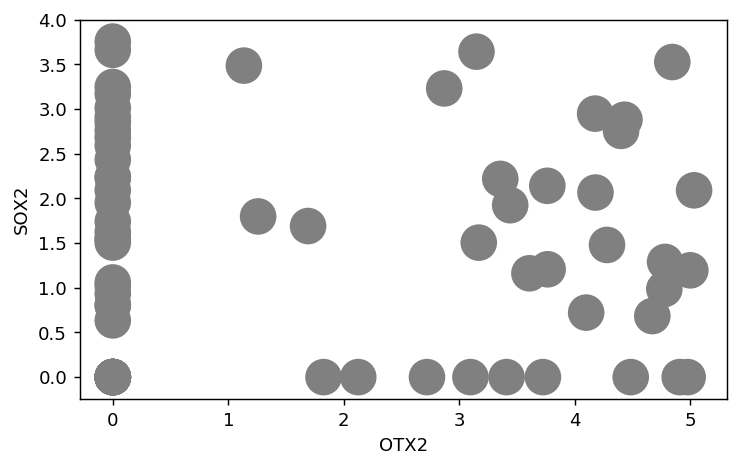

SpearmanrResult(correlation=0.035513992127787705, pvalue=0.765482889156837)

In [47]:
#pre = ad.read_csv('pre_counts.txt',delimiter='\t').T
#sc.pl.violin(epi,keys=['CXCL12','FOXB1'], groupby='Sample_mod')
rost = epi[epi.obs['Sample_mod']=='Caudal']
sc.pl.scatter(rost,x='OTX2',y='SOX2')
from scipy import stats
stats.spearmanr(rost[:,'OTX2'].X, rost[:,'SOX2'].X)

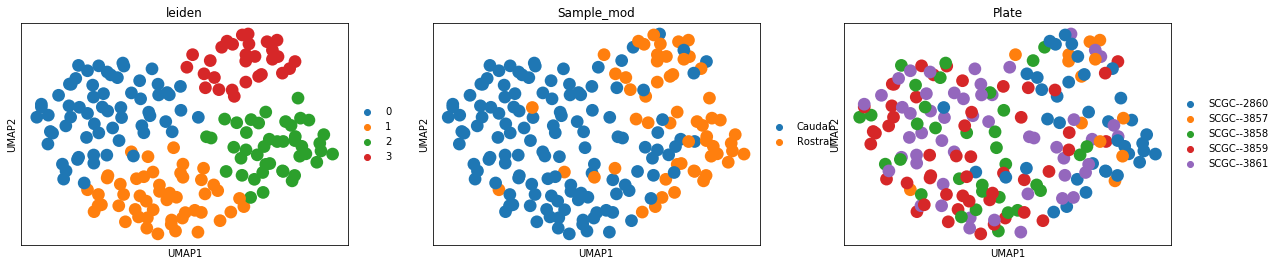

In [4]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

#pre<-load('data/human_pre_imp.rdata')
#hesc<-load('data/hESC.rdata')
#write.csv(early_emb_counts,'hesc_meta.csv',sep=',')
meta = pd.read_csv('meta_hv2.csv')
log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")
log_data2.obs = meta
epi = log_data2[log_data2.obs['clust_id']=='Epiblast']

#sc.pl.violin(epi,keys=['OTX2','SOX2'], groupby='Sample_mod')
sc.tl.rank_genes_groups(epi,groupby='Sample_mod')
pd.DataFrame(epi.uns['rank_genes_groups']['pvals_adj'])

import scipy
heman = log_data2[log_data2.obs['clust_id']=='Emergent Mesoderm']
#sc.pp.log1p(heman)
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));

sc.pp.highly_variable_genes(heman, max_mean=10,n_top_genes=1000)
heman = heman[:, heman.var['highly_variable']]
heman = sc.tl.pca(heman,svd_solver = 'arpack', n_comps = 50,copy=True)
sc.pp.neighbors(heman,n_pcs=10, n_neighbors=20, method = 'umap',metric=spearman_dist)

sc.tl.leiden(heman,resolution=0.5)
sc.tl.umap(heman)
sc.pl.umap(heman,color=['leiden','Sample_mod','Plate'])

## Comparison hesc

In [69]:
hesc=ad.read_csv('Hesc_comparison/hesc_counts.csv',delimiter=',').T
hescm = pd.read_csv('Hesc_comparison/hesc_meta.csv',sep=',')
hesc.obs=hescm
sc.pp.log1p(hesc)
epi = ad.read_csv("script_heart+gastr/norm_true_data.csv")
epi_m = pd.read_csv('ori_gast_umap.csv')
epi.obs['x'] =list(epi_m['cluster_id'])

epi = epi[epi.obs['x']=='Epiblast']
#epi.obs['x']=epi.obs['y']

pre = ad.read_csv('Hesc_comparison/pre_counts.csv',delimiter=',').T
pre.obs['y']='vivo'

x = []
for i in pre.obs.index:
    x.append(i[:2])
    

sc.pp.log1p(pre)
hesg = pd.read_csv('Hesc_comparison/hesc.csv',sep='\t')
intr = list(set(list(hesc.var_names)).intersection(set(list(hesg['Gene stable ID']))))
hesc = hesc[:,intr]
hesg = hesg[hesg['Gene stable ID'].isin(intr)]
hesg = hesg.sort_values(by='Gene stable ID')
hesc = hesc[:,list(hesg['Gene stable ID'])]
hesc.var.index = hesg['Gene name']

emb2 = epi.to_df()
emb3 = hesc.to_df()
emb4 = pre.to_df()
intr = list(set(list(hesc.var_names)).intersection(set(list(epi.var_names))).intersection(set(list(pre.var_names))))
hesc.var_names_make_unique()
hesc = hesc[:,intr]
epi = epi[:,intr]
pre = pre[:,intr]
pre.obs['x']=x
epi.obs['x']='CS7'
epi.obs['y']='in vivo'
hesc.obs['y']='in vitro'
me= epi.concatenate(hesc,pre)
genes_use = list(me.var_names)

pre_stage = list(pre.obs['x'])
hesc_stage = list(hesc.obs['x'])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [13]:
%get emb4
%get emb2
%get pre_stage
%get hesc_stage
%get genes_use
library(Seurat)
library(ggplot2)
library(cowplot)
library(dplyr)
library(harmony)
n_feat = 4000
emb2<-t(emb2)
emb3<- read.csv('hesc_counts.csv',header= TRUE)
emb3<-t(emb3)
colnames(emb3)<-hesc_stage
emb4<-t(emb4)
emb2 <-emb2[all_human_high_var,]
emb3 <-emb3[all_human_high_var,]
emb4 <-emb4[all_human_high_var,]

pbmc <- CreateSeuratObject(counts = cbind(emb2, emb3,emb4), project = "hesc") %>%
    Seurat::NormalizeData(verbose = FALSE) %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 1600) %>% 
    ScaleData(verbose = FALSE) %>% 
    RunPCA(pc.genes = pbmc@var.genes, npcs = 20, verbose = FALSE)
pbmc@meta.data$stage <- c(rep("CS7", ncol(emb2)), hesc_stage,pre_stage)
options(repr.plot.height = 2.5, repr.plot.width = 6)
pbmc <- pbmc %>% 
    RunHarmony("stage", plot_convergence = TRUE)
harmony_embeddings <- Embeddings(pbmc, 'harmony')
options(repr.plot.height = 5, repr.plot.width = 12)



ERROR: Error in DimPlot(object = pbmc, reduction = "harmony", pt.size = 0.1, : formales Argument "pt.size" passt zu mehreren gegebenen Argumenten


In [28]:
pdf("hESC_comp1.pdf") 
library(Seurat)

DimPlot(object = pbmc, reduction = "harmony", pt.size = .8, group.by = "stage", do.return = TRUE,
              ,cols =c('#3C76AF',"#cff27e","#f2dd6e","#e5b25d","#b87d4b","#523a34","#540d6e","#ee4266"))
#p2 <- VlnPlot(object = pbmc, features = "harmony_1", group.by = "stage", do.return = TRUE, )
dev.off() 

pdf 
  2

In [4]:
%get emb4
%get emb2
%get pre_stage
%get hesc_stage
%get genes_use
library(Seurat)
library(ggplot2)
library(cowplot)
n_feat = 4000
emb2<-t(emb2)
emb2 <- CreateSeuratObject(counts = emb2, project = "embryo2")
emb2@meta.data$stage <- "CS7"
emb2$RNA@var.features


emb2 <- subset(emb2, subset = nFeature_RNA > 0)
emb2 <- NormalizeData(emb2, verbose = FALSE)
emb2 <- FindVariableFeatures(emb2, selection.method = "vst", nfeatures = n_feat)
#emb2$RNA@var.features<-all_human_high_var

emb3<- read.csv('hesc_counts.csv',header= TRUE)
emb3<-t(emb3)
colnames(emb3)<-hesc_stage
emb3 <- CreateSeuratObject(counts = emb3, project = "embryo3")
emb3 <- subset(emb3, subset = nFeature_RNA > 0)
emb3 <- NormalizeData(emb3, verbose = FALSE)
emb3 <- FindVariableFeatures(emb3, selection.method = "vst", nfeatures = n_feat)
#emb3$RNA@var.features<-all_human_high_var

emb3@meta.data$stage <- hesc_stage


emb4<-t(emb4)
emb4 <- CreateSeuratObject(counts = emb4, project = "embryo4")
emb4 <- subset(emb4, subset = nFeature_RNA > 0)
emb4 <- NormalizeData(emb4, verbose = FALSE)
emb4 <- FindVariableFeatures(emb4, selection.method = "vst", nfeatures = n_feat)
#emb4$RNA@var.features<-all_human_high_var

emb4@meta.data$stage <- pre_stage
hvgs<-load('Hesc_comparison/hvg_hesc.RData')


Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 600 anchors
Filtering anchors
	Retained 220 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 660 anchors
Filtering anchors
	Retained 68 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 825 anchors
Filtering anchors
	Retained 86 anchors
Extracting within-dataset neighbors
Merging dataset 1 into 2
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data
Merging dataset 2 1 into 3
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data


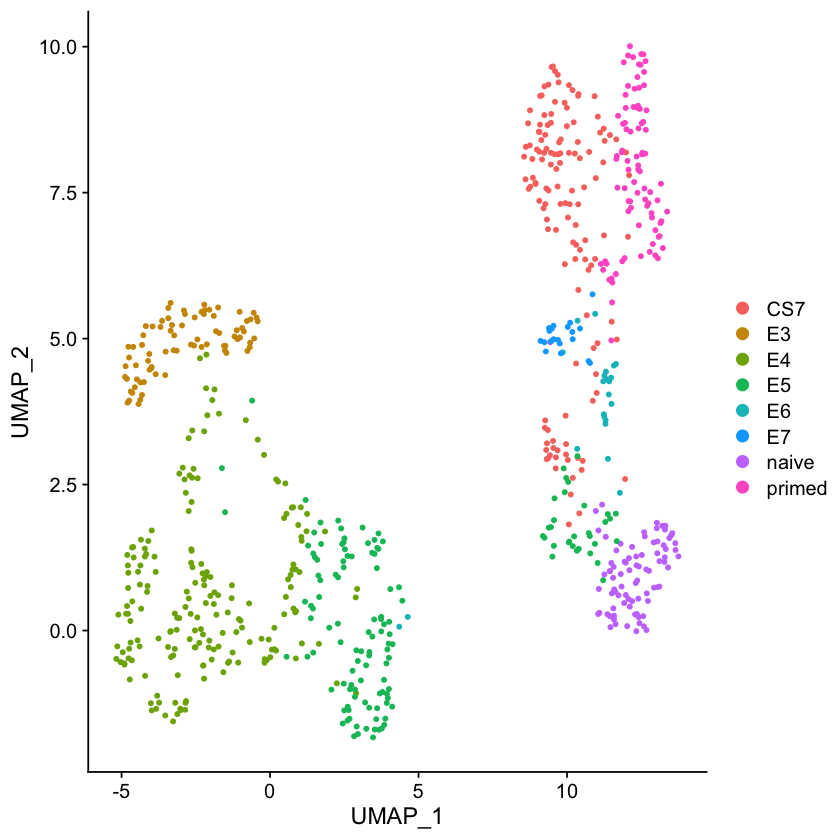

In [57]:
xenopus.anchors <- FindIntegrationAnchors(object.list = list(emb2, emb3, emb4),dims = 1:20, anchor.features = all_human_high_var,k.filter=30)
xenopus.combined <- IntegrateData(anchorset = xenopus.anchors, dims = 1:20)
DefaultAssay(xenopus.combined) <- "integrated"
xenopus.combined <- ScaleData(xenopus.combined, verbose = FALSE)
xenopus.combined <- RunPCA(object = xenopus.combined, npcs = 50, verbose = FALSE)

xenopus.combined <- RunUMAP(object = xenopus.combined, reduction = "pca", 
    dims = 1:20,min.dist=0.5)
DimPlot(object = xenopus.combined, reduction = "umap", group.by = "stage")


In [58]:
integ <- xenopus.combined$integrated[1:length(all_human_high_var)]
integ <- as.data.frame(integ)
write.csv(file='seurat_integrated.csv',integ,sep=',')

Warning message in write.csv(file = "seurat_integrated.csv", integ, sep = ","):
“attempt to set 'sep' ignored”

In [72]:
%get all_human_high_var --from R
seur=ad.read_csv('seurat_integrated.csv').T

seur.obs=me.obs
import mnnpy
 
corr_epi=sc.external.pp.mnn_correct(epi,hesc,pre, k = 20,
                            var_subset=all_human_high_var)
seur =corr_epi[0]
    
sc.tl.pca(seur, n_comps=50,svd_solver='arpack')
sc.pp.neighbors(seur,n_pcs=20,n_neighbors=40,method='umap')

sc.tl.umap(seur)
sc.pl.umap(seur, color = 'x',components='1,2',palette = ["#a1def0", "#2c647e", "#39eec0", "yellow", "red", "#799d10", "#c3de9b", "#24a475", "#5826a6", "#fcc2fb", "#724363", "#427ff5", "#cd71b5", "#ed2bb1", "#8a0458", "#9867f6", "#a417eb", "#4cf32c"])

from IPython import get_ipython

get_ipython().run_line_magic('matplotlib', 'inline')
#seur=ad.read_csv('seurat_integrated.csv').T

#seur.obs=me.obs

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
#X = seur.X

msdf = seur.to_df()
msdf['typ_st']=list(seur.obs['x'])
msdf = msdf.groupby('typ_st').mean()
def spearman_dist(X1,X2):
    return np.sqrt(0.5*(1.0-scipy.stats.spearmanr(X1,X2)[0]));

X = np.array(msdf)
Z = linkage(X, 'average',metric=spearman_dist)


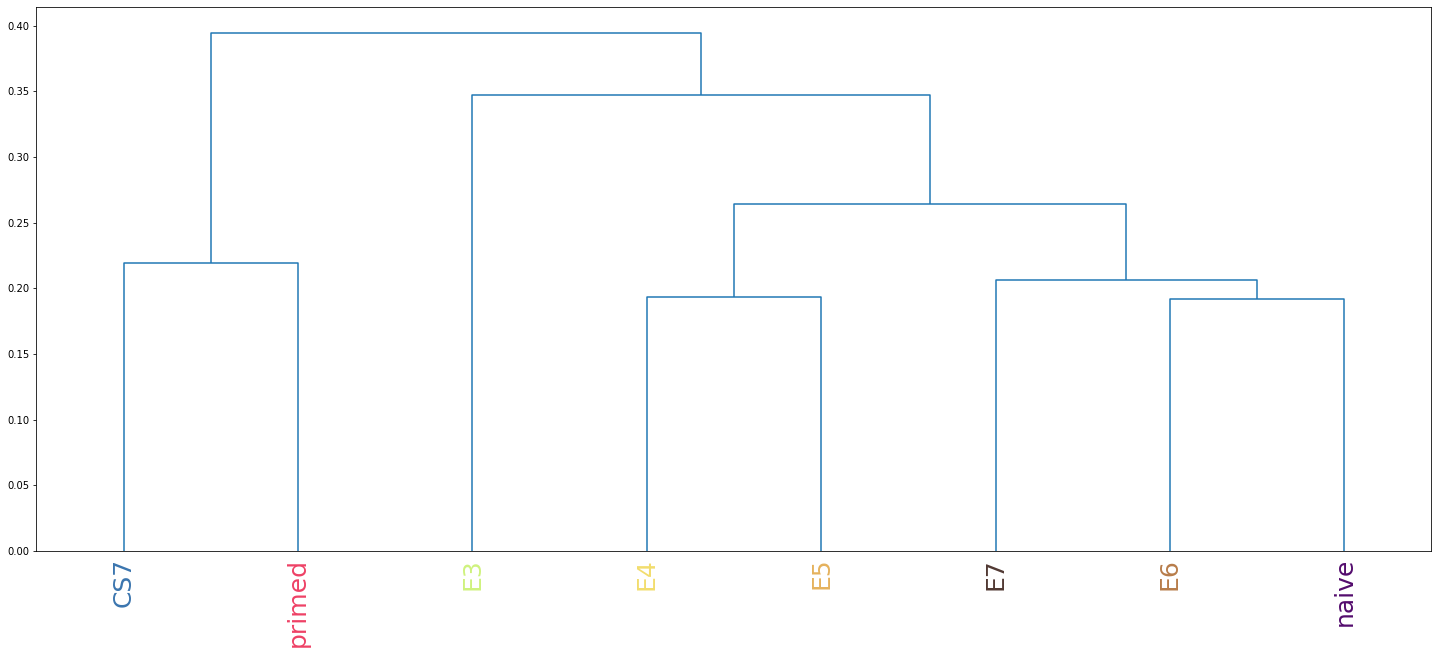

In [58]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=25,
    labels=msdf.index,
    color_threshold = 0)
from scipy.cluster.hierarchy import cut_tree

label_colors = {'E3': '#cff27e', 'E4': '#f2dd6e', 'E5': '#e5b25d', 'E6': '#b87d4b','E7':'#523a34',
                'naive':'#540d6e','primed':'#ee4266','CS7':'#3C76AF'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

#plt.show()
plt.savefig('r_figures/hesc_comp2.pdf',format='pdf',bbox_inches='tight')  


ERROR: Error in ..py.repr(list(all_human_high_var = all_human_high_var)): Objekt 'all_human_high_var' nicht gefunden


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    Gene indices [12230] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    the 1000 top genes correspond to a normalized dispersion cutoff of 1.7083581686019897
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'x' as categorical
... storing 'y' as categorical
... storing 'Unnamed: 0' as categorical


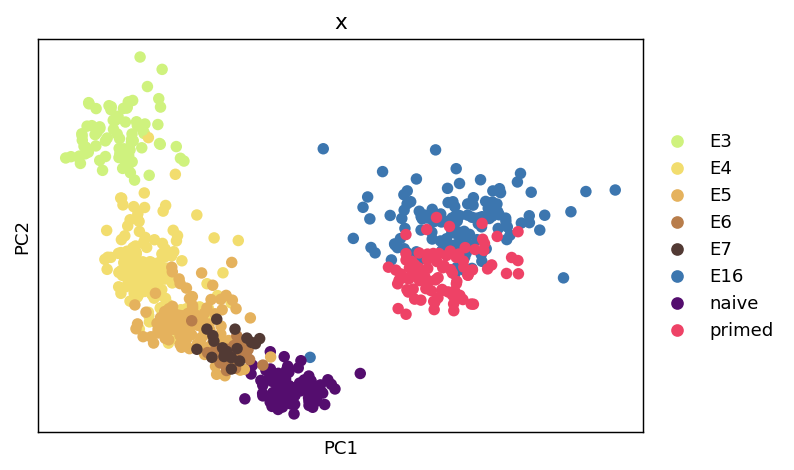

In [86]:
%get all_human_high_var --from R
me= epi.concatenate(hesc,pre)
sc.pp.normalize_total(me)

sc.pp.highly_variable_genes(me, max_mean=10,n_top_genes=1000)
#ps = ps[:,all_human_high_var]
me=me[:,me.var['highly_variable']]
#me = me.concatenate(ps)
me=sc.tl.pca(me,n_comps=20,zero_center=True,copy=True)
#cdata = scbbknn.bbknn(me, n_pcs=15,batch_key='x')
sc.pl.pca(me,color='x',components='1,2',palette=["#cff27e","#f2dd6e","#e5b25d","#b87d4b","#523a34",'#3C76AF',"#540d6e","#ee4266"],save='Fig3_PCA.pdf')



In [104]:
'''mer = epi.concatenate(hesc,pre)
sc.pp.normalize_total(mer)
me.raw= mer 
sc.pl.heatmap(me,groupby='x', var_names = 'NANOG')'''
genes_use = list(me.var_names)

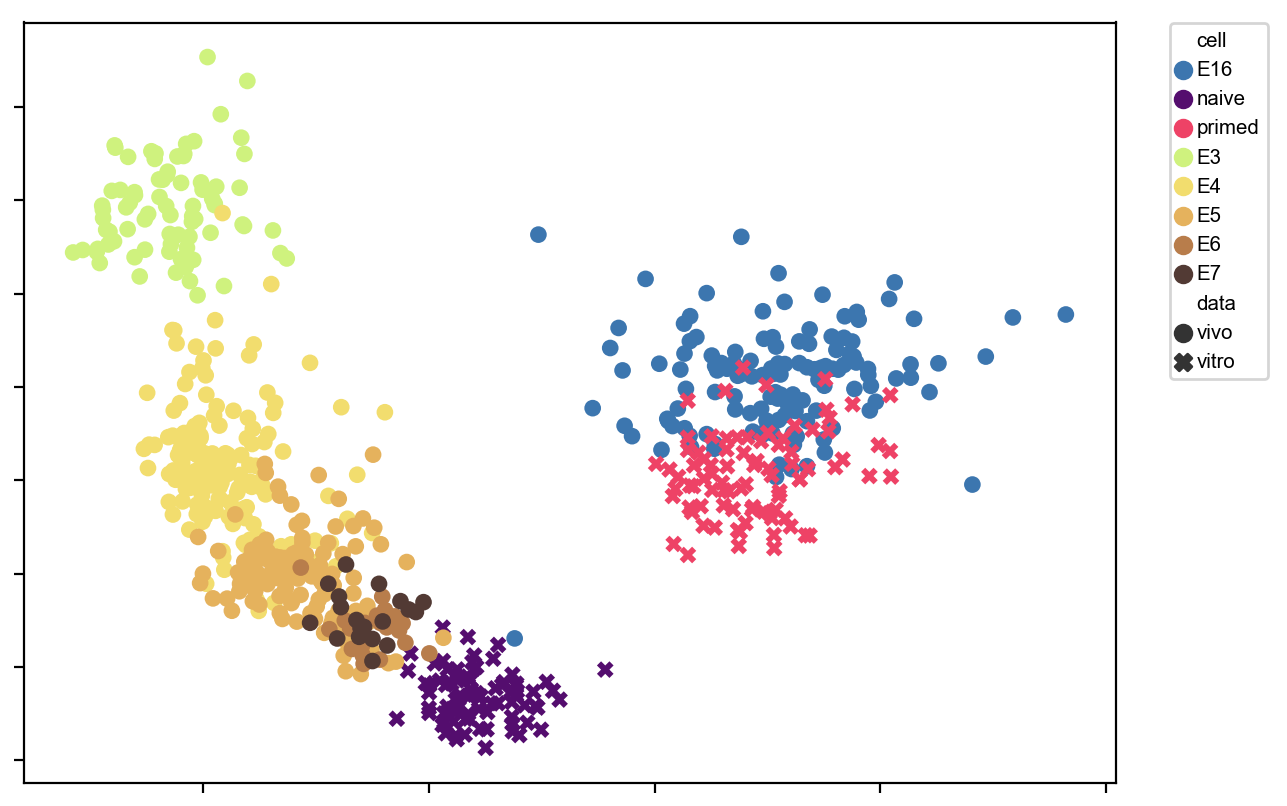

In [702]:
import scvelo as scv
scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')

plot_pca=pd.DataFrame(me.obsm['X_pca'][:,0:2])

#plot_pca[1]=plot_pca[1]*-1
plot_pca['cell']=list(me.obs['x'])
plot_pca.sort_values(by='cell')
plot_pca['data']=list(me.obs['y'])
fig, ax = plot.subplots(1, 1)

g2=sns.scatterplot(x=0,y=1,data=plot_pca,hue='cell',style='data',edgecolor="none",
              ax=ax,  palette=['#3C76AF',"#540d6e","#ee4266","#cff27e","#f2dd6e","#e5b25d","#b87d4b","#523a34"])
g2.set(xticklabels=[],yticklabels=[])

plot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('')    
ax.set_xlabel('')
plot.savefig('pca_hesc.pdf')

In [480]:
me= epi.concatenate(hesc,pre)
sc.pp.normalize_total(me)
sc.pp.highly_variable_genes(me, max_mean=10,n_top_genes=4000)
me=me[:,all_human_high_var]

naive=me[me.obs['x']=='naive']
me=me[me.obs['x']!='naive']

corr_list=[]
for i in list(set(list(me.obs['x']))):
    cor = []
    j = len(naive.X)
    #sns.clustermap(pairwise_distances(human.X,mouse[mouse.obs['stage']==str(i)].X,metric='correlation'),row_cluster=True,col_cluster=False)
    for p in range(j):
        corr = scipy.stats.spearmanr(naive.X[p],np.mean(me[me.obs['x']==str(i)].X,axis=0))
        rho, pval = corr
        cor.append(rho)
    corr_list.append(cor)

#me.raw=epi.concatenate(hesc,pre)
#sc.pl.pca(me,color='ZIC2',components='1,3')


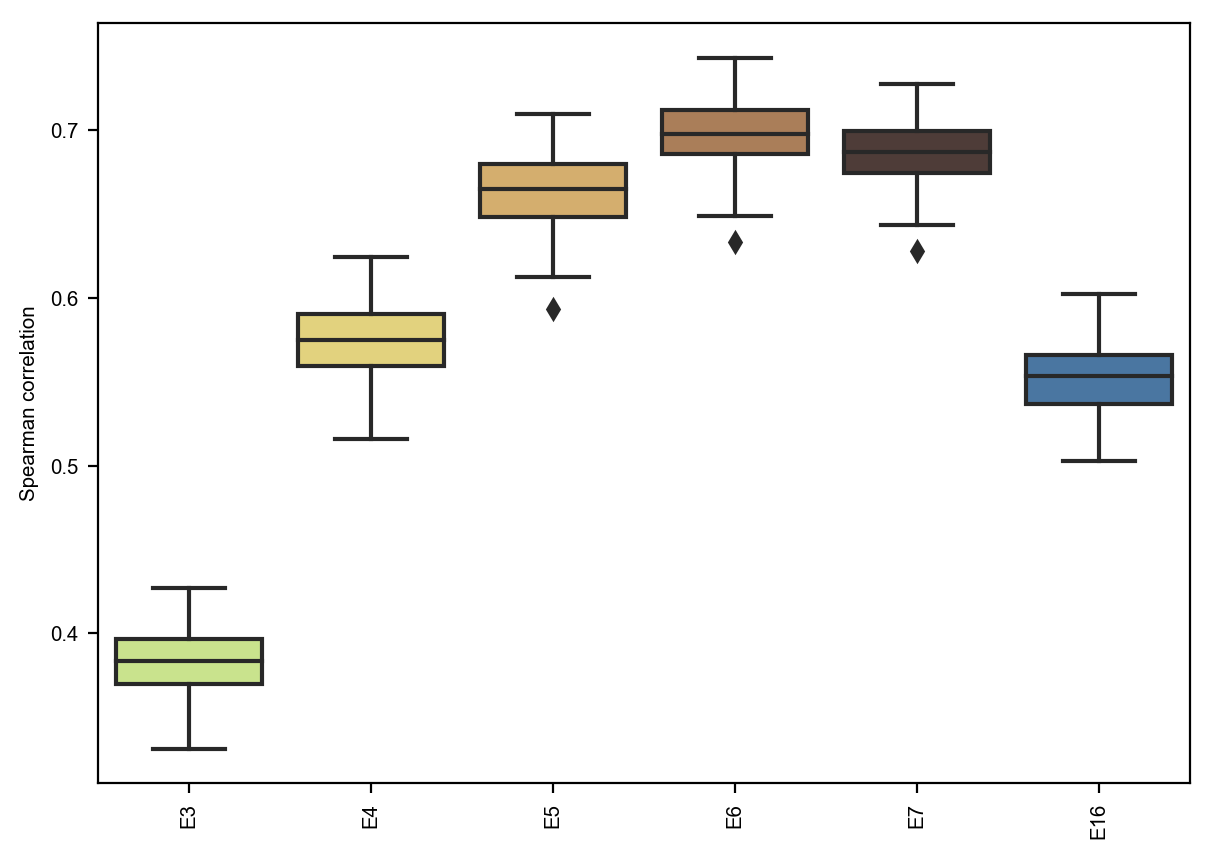

In [481]:
corr_df = pd.DataFrame(corr_list)
corr_df.index =list(set(list(me.obs['x'])))
corr_df = corr_df.sort_index()
#corr_df.loc['E16']=corr_df.loc['E16']+0.04
corr_df = corr_df.T
corr_df = corr_df[['E3','E4','E5','E6','E7','E16']]
ax = sns.boxplot(data = corr_df ,palette=["#cff27e","#f2dd6e","#e5b25d","#b87d4b","#523a34",'#3C76AF'])
ax.set_ylabel('Spearman correlation')
plot.setp(ax.get_xticklabels(), rotation=90)

plot.savefig('corr_naive.pdf')

In [104]:
me= epi.concatenate(hesc,pre)
sc.pp.normalize_total(me)

#ps = ps[:,all_human_high_var]
me=me[:,all_human_high_var]

sc.pp.filter_genes(me,min_counts=900)
e6 = me[me.obs['x']=='E6'].to_df()
e16 =   me[me.obs['x']=='CS7'].to_df()
naive = me[me.obs['x']=='naive'].to_df()
prime = me[me.obs['x']=='primed'].to_df()
pc  = 0.1
e6 = e6.mean(axis=0)
e16 = e16.mean(axis=0)

naive = naive.mean(axis=0)

prime = prime.mean(axis=0)

x = np.log2(e16+pc)-np.log2(e6+pc)
y = np.log2(prime+pc)-np.log2(naive+pc)

gene_log = pd.DataFrame([list(x),list(y)]).T
gene_log['gene']=x.index


Trying to set attribute `.var` of view, copying.


In [105]:
scipy.stats.pearsonr(x,y)cx


(0.6066595797569377, 1.3800184429650005e-76)

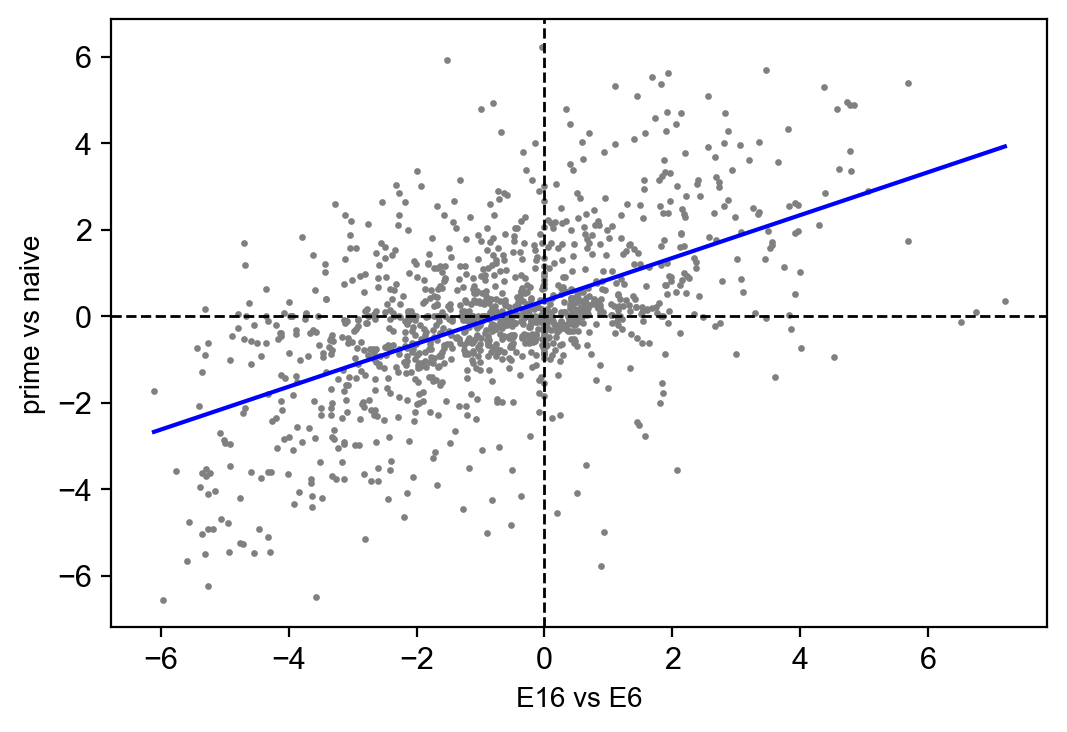

In [87]:
from sklearn.linear_model import LinearRegression
#scv.settings.set_figure_params('scvelo',vector_friendly=False,format='pdf')
plot.scatter(list(x),list(y),c='grey',s=2)
plot.axvline(0,color='black',linestyle='--',linewidth=1)
plot.axhline(0,color='black',linestyle='--',linewidth=1)
plot.xlabel('E16 vs E6',fontsize=10)
plot.ylabel('prime vs naive',fontsize=10)
model = LinearRegression()
model.fit(np.array(x)[:, np.newaxis], np.array(y))

# predict y from the data
x_new = np.linspace(min(x), max(x), 100)
y_new = model.predict(x_new[:, np.newaxis])
plot.plot(x_new,y_new,c='blue',markersize=0.5)
plot.scatter(list(z),list(t),c='#901C14',s=8) 

for w in wolf:
    
    plot.text(gene_log2[gene_log2['gene']==w][0],gene_log2[gene_log2['gene']==w][1],
              w,color='#5E0B15',fontname='Helvetica',fontsize=8,horizontalalignment='center',verticalalignment='bottom',weight="bold")
plot.gca()
plot.savefig('fc_plot.pdf')

In [106]:
gl = pd.concat([gene_log,gene_log2],axis=0)
gl['abs0'] = np.abs(gl[0])
gl['abs1'] = np.abs(gl[1])
gl = gl.sort_values(by=['abs1','abs0'],ascending=[False,False])
gl = gl.drop_duplicates(subset='gene',keep='first')
gl = gl.drop(['abs1','abs0'],axis=1)
quad = []
for index, row in gl.iterrows():
    if row[0]>0 and row[1]>0:
        quad.append('1')
    if row[0]<0 and row[1]<0:
        quad.append('3')
    if row[0]>0 and row[1]<0:
        quad.append('4')
    if row[0]<0 and row[1]>0:
        quad.append('2')
    if row[0]==0 or row[1]==0:
        quad.append('NA')

gl['Quadrant'] = quad
gl1 = gl[gl['Quadrant']=='4']
gl1.to_excel("log_FC4.xlsx", sheet_name='Sheet_name_1')  

In [260]:
tomo = pd.read_excel('gene_lists/tomo.xlsx',sheet_name='Supplementary File 1')
tgenes=list(tomo.iloc[:,0])
tgenes = [x[16:-4] for x in tgenes]
cluster = list(tomo.iloc[:,1])
tomo['gene']=tgenes
tomo = tomo.iloc[:,1:3]
tomo = tomo[-tomo['Hierarchical Cluster'].isin(['0','6','7','8','9','10','11','12','19','20'])]
#tomo.groupby(['Hierarchical Cluster']).size()

In [261]:
log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")
sc.pp.log1p(log_data2)
log_data2.obs['leiden']=high_var2.obs['leiden']
marks = []
sc.pp.filter_genes(log_data2,min_cells=5)
for i in range(11):
    mark = FindMarkers(log_data2,'leiden',str(i),NR_CLUS)
    mark = mark.sort_values(by=['succ_PC','mean_log_pval'],ascending=False)
    marks.append(list(mark.index))
mark =pd.DataFrame(marks).T

Keyboard Interrupt


In [281]:
import random
heatm=[]
mark3 = pd.read_excel('gast_markers_sortedUnique.xlsx')

n= 300
mark2=mark3[:250]

for i in range(max(tomo['Hierarchical Cluster'])+1):
    inter=[]
    t = list(tomo[tomo['Hierarchical Cluster']==i]['gene'])
    for j in range(11):
         
        l=[]
        for k in range(0, n):
            mark2=mark2.values.flatten()
            random.shuffle(mark2)
            mark2 = list(mark2)
            mark2=pd.DataFrame(list(map(lambda x: mark2[11*x:(x+1)*11], range (n))))
            z = list(mark2[j])
            #z = z[:200]
            inter.append(len(set(t).intersection(set(z))))
        l.append(inter)
    heatm.append(inter)
df = pd.DataFrame(heatm)
fc = df[(df.T != 0).any()]
fcc = fc.groupby(np.arange(len(fc.columns))//n, axis=1).mean()
#df
#sns.heatmap(df[(df.T != 0).any()])

In [28]:
with open('backg.txt', 'w') as f:
    for item in list(list(log_data2.var_names)):
        f.write("%s\n" % item)


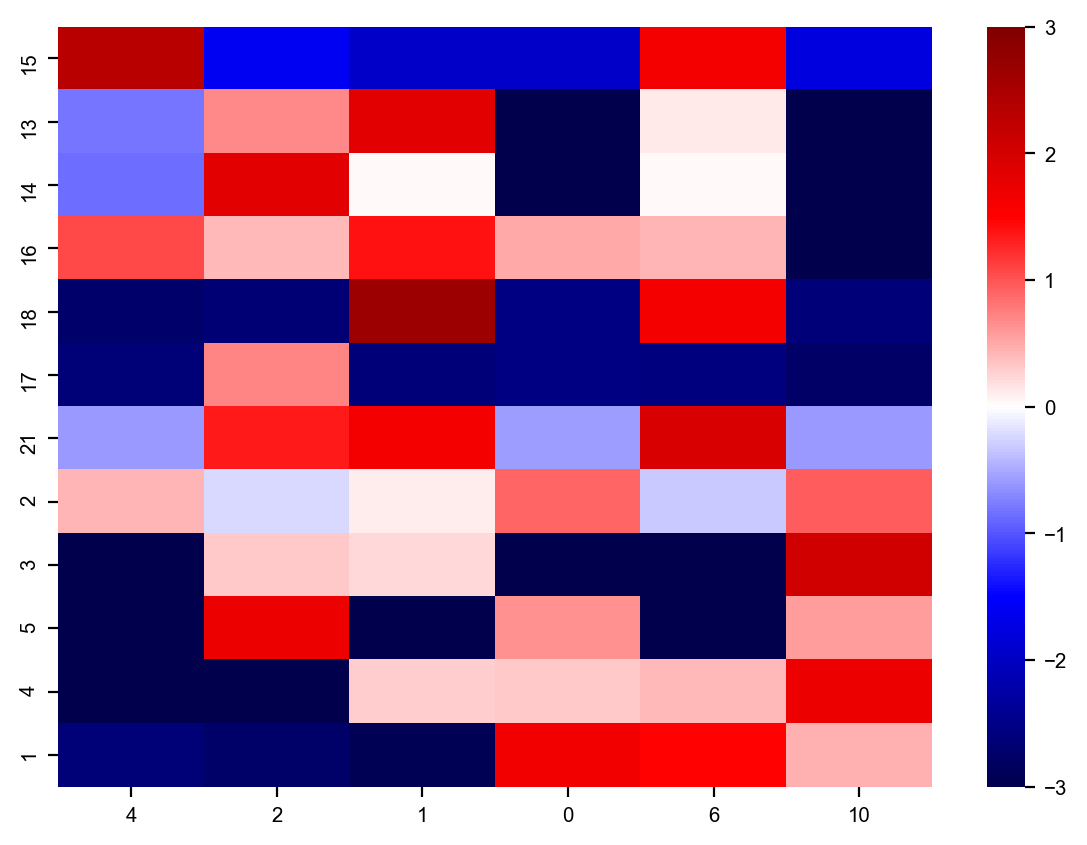

In [443]:
heatm=[]

for i in range(max(tomo['Hierarchical Cluster'])+1):
    inter=[]
    t = list(tomo[tomo['Hierarchical Cluster']==i]['gene'])
    for j in range(11):
         
        mark2=mark3[:250]
        #mark2=mark2.values.flatten()
        #random.shuffle(mark2)
        #mark2 = list(mark2)
        #mark2=pd.DataFrame(list(map(lambda x: mark2[11*x:(x+1)*11], range (200))))
        z = list(mark2[j])
            #z = z[:200]
        inter.append(len(set(t).intersection(set(z))))
       # l.append(inter)
    heatm.append(inter)
df = pd.DataFrame(heatm)
df = df[(df.T != 0).any()]
#df =df.div(fc)
df = np.log2(df+0.1) - np.log2(fcc+0.1)
df = df[[4,2,1,0,6,10]]
df = df.reindex([15,13,14,16,18,17,21,2,3,5,4,1])

sns.heatmap(df,cmap='seismic',vmax=3,vmin=-3)


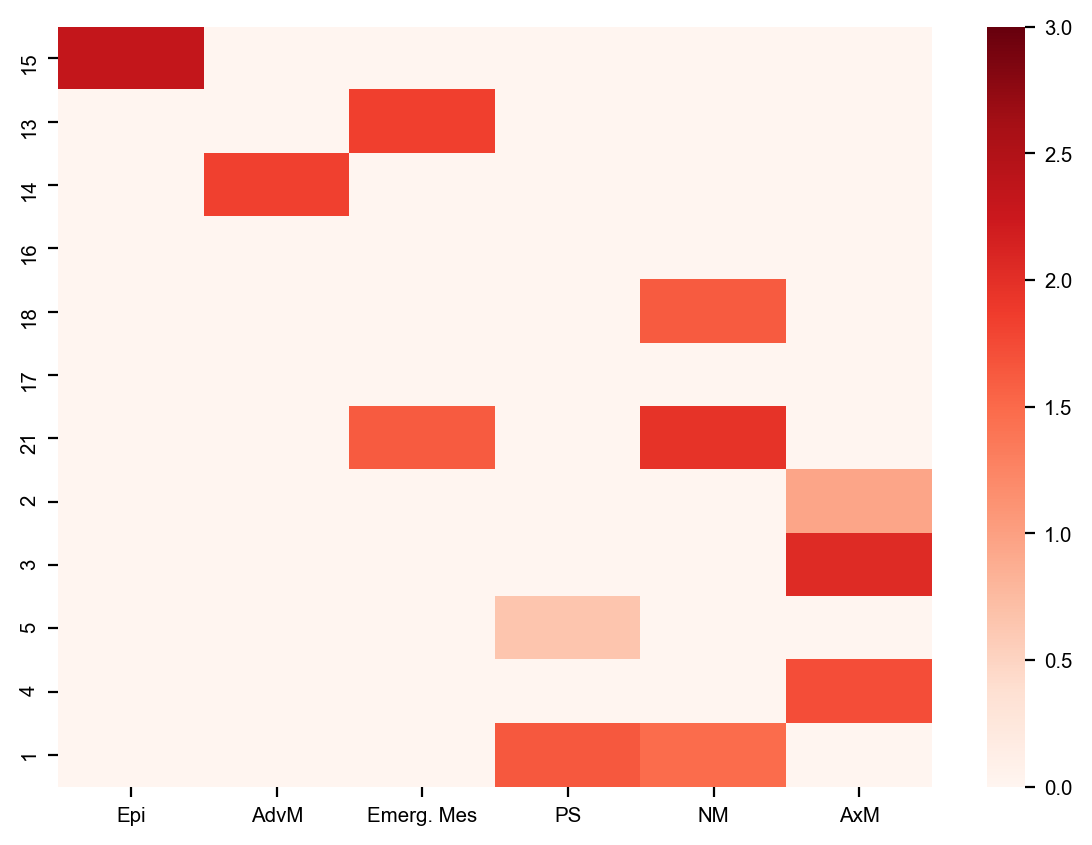

In [452]:
df = pd.DataFrame(heatm)
df = df[(df.T != 0).any()]
#df =df.div(fc)
df = np.log2(df+0.1) - np.log2(fcc+0.1)
df = df[[4,2,1,0,6,10]]
df = df.reindex([15,13,14,16,18,17,21,2,3,5,4,1])

for i in range(len(df.iloc[1:][4])):
    df.iloc[i+1][4]=0
for i in range(len(df.iloc[3:][2])):
    df.iloc[i+3][2]=0
df.iloc[0][2]=0
df.iloc[1][2]=0
df.iloc[0][1]=0
for i in range(len(df.iloc[2:6][1])):
    df.iloc[i+2][1]=0
for i in range(len(df.iloc[7:][1])):
    df.iloc[i+7][1]=0
for i in range(len(df.iloc[0:-3][0])):
    df.iloc[i][0]=0
df.iloc[-2][0]=0
for i in range(len(df.iloc[0:4][6])):
    df.iloc[i][6]=0
df.iloc[-2][6]=0
df.iloc[-1][10]=0
df.iloc[-3][10]=0
df.columns=['Epi','AdvM','Emerg. Mes','PS','NM','AxM']
   
sns.heatmap(df,cmap='Reds',vmax=3,vmin=0)
plt.savefig('gastruloid_comparison.pdf')

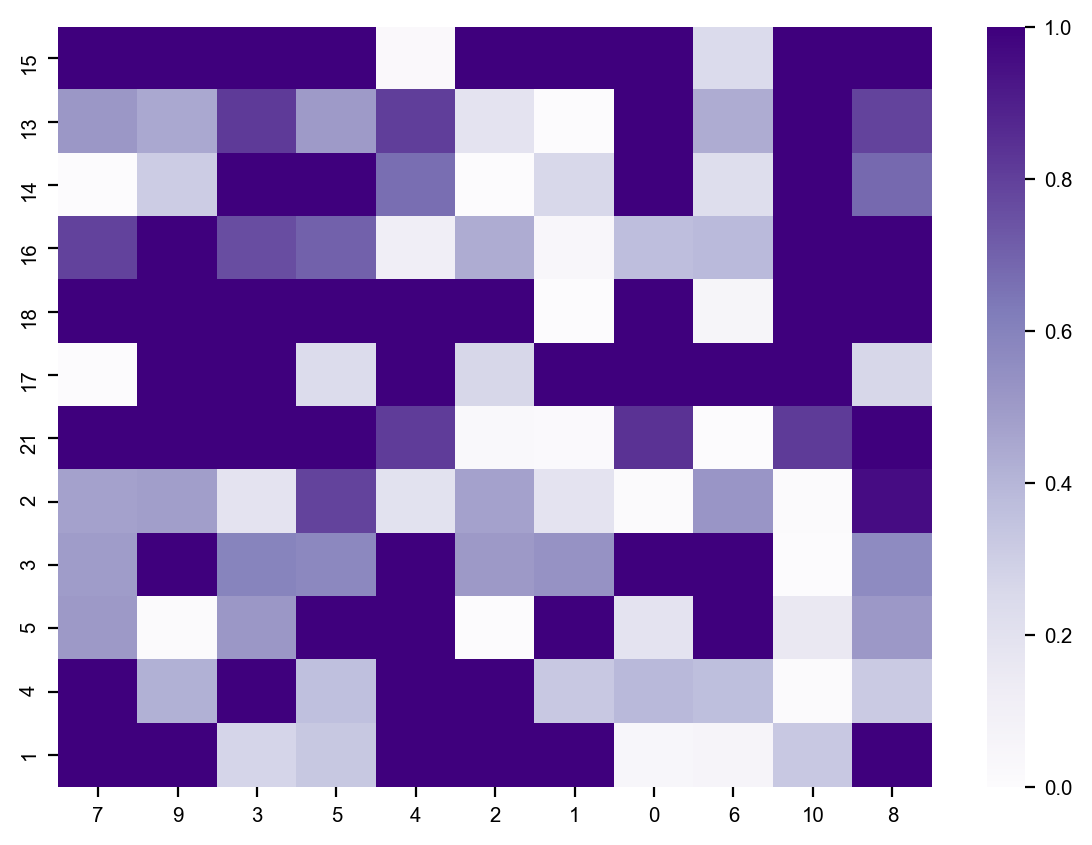

In [273]:
pval = []
for index , row in fc.iterrows():
    data_list = list(row)
    true = list(df.loc[index])
    new_list = [list(data_list)[i:i+n] for i in range(0, len(data_list), n)]
    pv = []
    for j in range(0,len(new_list)):
        pv.append(len([x for x in new_list[j] if x >= true[j]])/len(new_list[j])) 
    pval.append(pv)
pval = pd.DataFrame(pval)[[7,9,3,5,4,2,1,0,6,10,8]]
pval.index=fc.index
pval = pval.reindex([15,13,14,16,18,17,21,2,3,5,4,1])
pval.iloc[-5][4]=0.2
sns.heatmap(pval.reindex([15,13,14,16,18,17,21,2,3,5,4,1]), cmap='Purples')


In [173]:
'''log_data2 = ad.read_csv("script_heart+gastr/norm_true_data.csv")
sc.pp.log1p(log_data2)
log_data2.obs['leiden']=high_var2.obs['leiden']
log_data2[log_data2.obs['leiden']=='4'].to_df().to_csv('epi.csv')'''
#high_var2.obs.to_csv('meta_anno.csv')
pre = ad.read_csv('Hesc_comparison/pre_counts.csv',delimiter=',').T
#pre=ad.read_csv('scial_counts.txt',delimiter=' ').T
qc_metrics = sc.pp.calculate_qc_metrics(pre)

counts_cell = qc_metrics[0]['n_genes_by_counts']
plot.hist(counts_cell)

View of AnnData object with n_obs × n_vars = 1198 × 61448
    obs: 'Run lane', 'Sample', 'Cell#', 'Stage', 'Plate', 'batch', 'gene count', 'fraction mapped', 'fraction mito', 'fraction spike-in', 'total reads (log10)'
    uns: 'Plate_colors'

(array([101., 158., 225., 259., 260., 210., 127.,  68.,  33.,  12.]),
 array([ 2018. ,  3138.1,  4258.2,  5378.3,  6498.4,  7618.5,  8738.6,
         9858.7, 10978.8, 12098.9, 13219. ]),
 <a list of 10 Patch objects>)

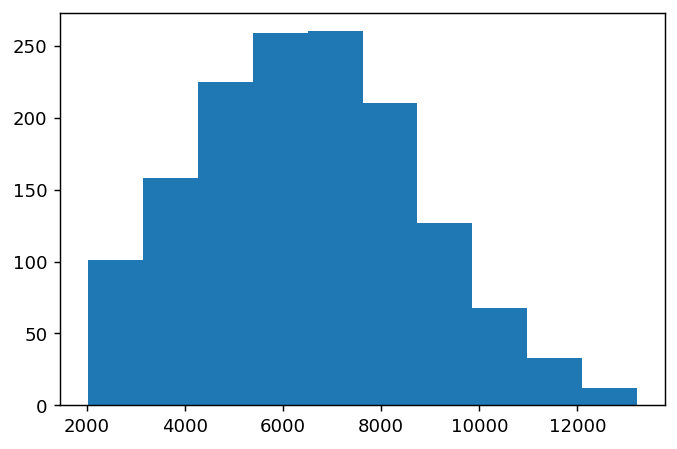

In [66]:
liver = ad.read_csv('liver.csv',delimiter=',').T
qc_liver = sc.pp.calculate_qc_metrics(liver)
plot.hist(qc_liver[0]['n_genes_by_counts'])

#plot.hist(gast_dat.obs['total reads (log10)'])


/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'x' as categorical


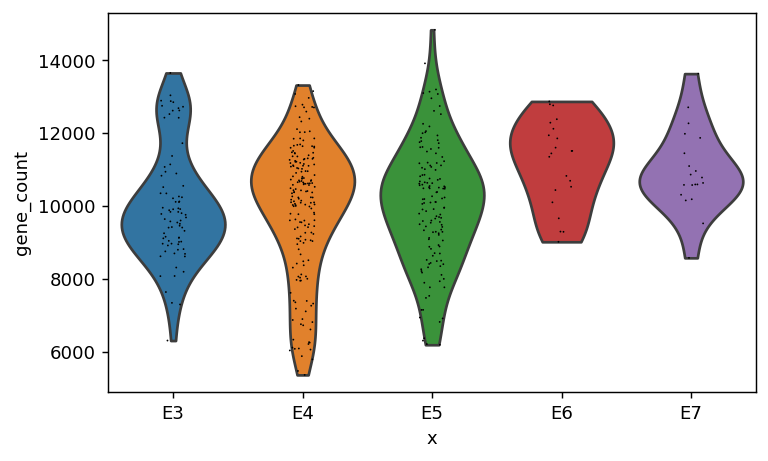

In [63]:
#plot.boxplot(gast_dat.obs['gene count'])
#monkey=ad.read_csv('aax7890-Ma-SM-Table-S5.csv',delimiter=',').T
#qc_mo = sc.pp.calculate_qc_metrics(monkey)
#plot.hist(qc_mo[0]['n_genes_by_counts'])

pre = ad.read_csv('Hesc_comparison/pre_counts.csv',delimiter=',').T
qc_pre = sc.pp.calculate_qc_metrics(pre)
pre.obs['gene_count']=list(qc_pre[0]['n_genes_by_counts'])
x = []
for i in pre.obs.index:
    x.append(i[:2])
pre.obs['x']=x
sc.pl.violin(pre,keys='gene_count',groupby='x')

/Users/elmirmahammadov/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


{'whiskers': [<matplotlib.lines.Line2D at 0x18c875860>,
 'caps': [<matplotlib.lines.Line2D at 0x18c875f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x18c875550>,
 'medians': [<matplotlib.lines.Line2D at 0x18c8806a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x18c880a20>,
 'means': []}

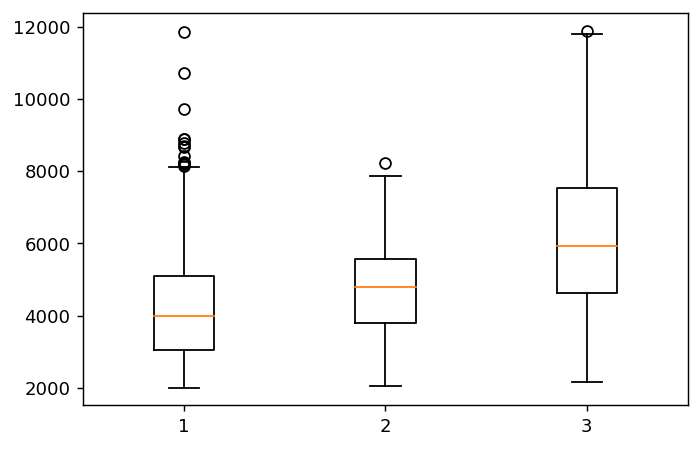

In [70]:
liver = ad.read_csv('liver.csv',delimiter=',').T
qc_liver = sc.pp.calculate_qc_metrics(liver)

liver.obs['gene count'] = qc_liver[0]['n_genes_by_counts']
liver = liver[liver.obs['gene count']>2000]
monkey=ad.read_csv('aax7890-Ma-SM-Table-S5.csv',delimiter=',').T
qc_mo = sc.pp.calculate_qc_metrics(monkey)

gc = [list(liver.obs['gene count']),list(gast_dat.obs['gene count']),
     list(qc_mo[0]['n_genes_by_counts'])]
plot.boxplot(gc)


In [166]:
meta = high_var2.obs.sort_index()
cell_name = []
file_name = []
cell_type = []
spat = []
for c in list(meta['Run lane']):
    cn = c.replace('.','_')
    cell_name.append(cn)
    file_name.append(cn+'_1.fastq.gz')
    cell_name.append(cn)
    file_name.append(cn+'_2.fastq.gz')
for i in list(meta['clust_id']):
    cell_type.extend([i, i])
for i in list(meta['Sample_mod']):
    spat.extend([i, i])
with open('md5.txt', 'r') as f:
    md5 = f.read().splitlines()
md5 = md5[:-1]
len(md5)


---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
script_7641024350669210365 in <module>
      for i in list(meta['Sample_mod']):
          spat.extend([i, i])
----> with open('md5.txt', 'r') as f:
          md5 = f.read().splitlines()
      md5 = md5[:-1]
      len(md5)

FileNotFoundError: 2


In [147]:
#pd.read_csv('Genes/file_names.txt',header=0,names=None)
annotare = pd.read_csv('submission10491_annotare_v1.sdrf.txt',sep = '\t')
aex = pd.DataFrame(cell_name)
aex.columns = ['Source Name']
aex['Characteristics[organism]'] = 'Homo sapiens'
aex['Characteristics[age]'] = '16-19'
aex['Unit[time unit]'] = 'day'
aex['Term Source REF'] = 'EFO'
aex['Term Accession Number'] = 'UO_0000033'
aex['Characteristics[developmental stage]']='CS7'
aex['Characteristics[sex]']='Male'
aex['Characteristics[organism part]']='whole embryo'
aex['Characteristics[individual]']='CS7'
aex['Characteristics[cell type]']= spat
aex['Characteristics[inferred cell type]']= cell_type
aex['Material Type']='cell'
aex['Protocol REF'] = 'Protocol 1'
aex['Protocol REF.1'] = 'Protocol 2'
aex['Protocol REF.2'] = 'Protocol 3'
aex['Extract Name'] = cell_name
aex['Comment[LIBRARY_LAYOUT]']='PAIRED'
aex['Comment[LIBRARY_SELECTION]']='PolyA'
aex['Comment[LIBRARY_SOURCE]']='TRANSCRIPTOMIC SINGLE CELL'
aex['Comment[LIBRARY_STRATEGY]']='RNA-Seq'
aex['Comment[NOMINAL_LENGTH]']='1500'
aex['Comment[NOMINAL_SDEV]'] = '200'
aex['Comment[end bias]']='none'
aex['Comment[input molecule]']='messenger RNA'
aex['Comment[library construction]'] = 'Smart-seq2'
aex['Comment[primer]'] = 'oligo-dT'
aex['Comment[single cell isolation]'] ='FACS' 
aex['Comment[spike in]'] = 'ERCC'
aex['Protocol REF.3'] = 'Protocol 4'
aex['Performer'] = 'Sanger Institute'
aex['Assay Name'] = cell_name
aex['Array Data File'] = file_name
aex['Comment[MD5]'] = md5
aex['Factor Value[inferred cell type]']=cell_type
aex

Source Name Characteristics[organism] Characteristics[age] Unit[time unit]  ...    Assay Name          Array Data File                      Comment[MD5]   Factor Value[inferred cell type]
0     SS_sc7785278              Homo sapiens                16-19             day  ...  SS_sc7785278  SS_sc7785278_1.fastq.gz  ea28adf894f45c1baa3101efcf304773  Hemogenic Endothelial Progenitors
1     SS_sc7785278              Homo sapiens                16-19             day  ...  SS_sc7785278  SS_sc7785278_2.fastq.gz  1917e8c0693ada9880ef1102c77b425c  Hemogenic Endothelial Progenitors
2     SS_sc7785279              Homo sapiens                16-19             day  ...  SS_sc7785279  SS_sc7785279_1.fastq.gz  722967284ab175c05629feb02a4b27ab                        YS Mesoderm
3     SS_sc7785279              Homo sapiens                16-19             day  ...  SS_sc7785279  SS_sc7785279_2.fastq.gz  b37b4a96adad249fefe1920e0249f8c0                        YS Mesoderm
4     SS_sc7785280              Homo sapiens                16-19             day  ...  SS_sc7785280  SS_sc7785280_1.fastq.gz  6b985d5674d260233f55f93a11366f6e                        YS Mesoderm
...            ...                       ...                  ...             ...  ...           ...                      ...                               ...                                ...
2385  SS_sc7788388              Homo sapiens                16-19             day  ...  SS_sc7788388  SS_sc7788388_2.fastq.gz  6d090bddb0a3159249bd83297b5db2fe                           Epiblast
2386  SS_sc7788390              Homo sapiens                16-19             day  ...  SS_sc7788390  SS_sc7788390_1.fastq.gz  712c4d335e7400eb8a62c462f7fc2e4b                   Primitive Streak
2387  SS_sc7788390              Homo sapiens                16-19             day  ...  SS_sc7788390  SS_sc7788390_2.fastq.gz  e300533d9ffbe95ca1645a9d5fbf0ce8                   Primitive Streak
2388  SS_sc7788391              Homo sapiens                16-19             day  ...  SS_sc7788391  SS_sc7788391_1.fastq.gz  06db0d4e2619e88f4af7d4ce528c5a07                   Nascent Mesoderm
2389  SS_sc7788391              Homo sapiens                16-19             day  ...  SS_sc7788391  SS_sc7788391_2.fastq.gz  9ebb06d1b769226abcfbe34d93b4f71c                   Nascent Mesoderm

[2390 rows x 35 columns]

In [467]:
#aex.to_csv('submission10491_annotare_v1.sdrf.txt', header=True, index=False, sep='\t', mode='a')
import pandas as pd
monk = pd.read_csv('monkey.txt',header=0,names=None,sep='\t')
for m in list(monk.columns):
    if m[:3]=='E17':
        print(m)

array([[0.       , 0.       , 1.3862944, ..., 0.       , 0.       ,
        3.912023 ],
       [0.       , 0.       , 3.0910425, ..., 0.       , 0.       ,
        2.4849067],
       [0.       , 0.       , 3.4339871, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [431]:
#high_var2['SS.sc7788388-1'].obs
#np.log10(317147)
sc.pl.violin(pre,color='gene count')

y   x
E3.1.443    vivo  E3
E3.1.444    vivo  E3
E3.1.445    vivo  E3
E3.1.447    vivo  E3
E3.1.448    vivo  E3
...          ...  ..
E3.52.3433  vivo  E3
E3.52.3434  vivo  E3
E3.53.3436  vivo  E3
E3.53.3437  vivo  E3
E3.53.3438  vivo  E3

[442 rows x 2 columns]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

#plt.fill_between(f1,y, hatch = '.')
#plt.show()
pdf = PdfPages('2clcplot.pdf')
#pdf.savefig(fig)
#import matplotlib.pyplot as plot
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats
import numpy as np
import math
from scipy.optimize import curve_fit

f1 = [0.000,0.022,0.206,0.375,0.587,1.016]
f2 = [0.000,0.033,0.196,0.426,0.627,0.975]
f3 = [0.000,0.021,0.125,0.314,0.695,0.814]
f4 = [0.000,0.010,0.105,0.328,0.528,0.798]
f5 = [0.000,0.021,0.116,0.319,0.573,0.864]
f6 = [0.000,0.010,0.084,0.362,0.602,0.871]
t = [3,4,5,6]
f6 = [np.mean(x) for x in zip(f1,f2,f3,f4,f5,f6)]
def func(x, a, d):
    return a*np.exp((-1/12)*x)+d
popt, pcov = curve_fit(func, t, f6[2:], p0=(0.001,0.001))
fig = plt.figure()

xx = np.linspace(3, 6, 100)
yy = func(xx, *popt)
plt.subplot(1,2,1)
plt.scatter(t,f6[2:],color='r')
plt.plot(xx,yy)
plt.xlabel('hours')
plt.ylabel('Fraction of 2-clc')
plt.title('Block release experiment')

fig.add_subplot(1,2,1)

f_g1 = 0.258
f_s = 0.3922
f_g2 = 229/7/100
P1=[f_g1,f_s,f_g2]
f1 = np.linspace(0.00,2,num =100)

log2 = 0.693
def shh(N, T, omphi, P,x):
    P[0] = f_g1
    P[1] = f_s

    P[2] = f_g2
    return  (N*(1/omphi+log2/T)/0.003 - f_s - x*f_g1)/f_g2
y = []
for f in f1:
    y.append(shh(0.01,8,12,P1,f))
fig.add_subplot(1,2,2)
plt.plot(f1,y)
plt.xlim(0,1)
plt.ylim(0,1)
#plot.axhline(linestyle='dashed')
#plot.axvline(linestyle='dashed')
plt.ylabel(r'$f_{g2m}/f_s$',fontsize=14)
plt.xlabel(r'$f_{g1}/f_s$',fontsize=14)
plt.tight_layout()

plt.show()

pdf.savefig(fig)
pdf.close()